In [71]:
import load_data
import numpy as np
import torch as th
import torch.nn as nn
import pandas as pd
import PIL
import matplotlib.pyplot as plt

# Helper Functions

In [72]:
def true_params(cases, recovered, deaths, population):
    X = cases
    R = recovered + deaths

    n = np.array([population] * len(X), dtype=np.float64)

    S = n - X - R

    X_diff = np.array([X[:-1], X[1:]], dtype=np.float64).T
    R_diff = np.array([R[:-1], R[1:]], dtype=np.float64).T


    gamma = (R[1:] - R[:-1]) / (X[:-1])
    beta = n[:-1] * (X[1:] - X[:-1] + R[1:] - R[:-1]) / (X[:-1] * (n[:-1] - X[:-1] - R[:-1]))
    return np.nan_to_num(gamma), np.nan_to_num(beta)

In [73]:
def nan_to_num(t,mynan=0.):
    if th.all(th.isfinite(t)):
        return t
    if len(t.size()) == 0:
        return th.tensor(mynan)
    return th.cat([nan_to_num(l).unsqueeze(0) for l in t],0)

In [74]:
def my_msle(output, target):
    loss = th.mean(((output.add(1)).log() - (target.add(1)).log())**2)
    return loss

In [75]:
def my_msle_ID(I, D, I_label, D_label):
    #I[I != I] = 0.0
    #D[D != D] = 0.0
    #I_label[I_label != I_label] = 0.0
    #D_label[D_label != D_label] = 0.0
    I_loss = ((I.add(1)).log() - (I_label.add(1)).log())**2
    D_loss = ((D.add(1)).log() - (D_label.add(1)).log())**2
    loss = th.mean(th.add(I_loss, D_loss))
    return loss

In [76]:
def sir_1d_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D

    I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
    D_new = th.add(D, th.mul(gamma.view(3142,1), I))

    return I_new, D_new

# Load Data

In [77]:
df = load_data.load_county_level(data_dir='data')
keys = df.keys()

loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [78]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 254):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(300, 422):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie
pop[2076] = 12466 #fixed the population value for Shannon

In [79]:
gamma_lst = []
beta_lst = []
recovered = np.zeros(len(cases[0]))
for i in range(len(cases)):
    gamma, beta = true_params(cases[i], recovered, deaths[i], pop[i])
    gamma_lst.append(gamma)
    beta_lst.append(beta)
gamma_lst = np.nan_to_num(np.stack(gamma_lst,0))
beta_lst = np.nan_to_num(np.stack(beta_lst,0))

/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/ubuntu/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [80]:
out_size = 1
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 1

train_past_cases_1d = []
train_past_deaths_1d = []
train_past_gamma_1d = []
train_past_beta_1d = []
train_labels_cases_1d = []
train_labels_deaths_1d = []
train_labels_gamma_1d = []
train_labels_beta_1d = []

for start in range(train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    train_past_deaths_1d.append(th.tensor(deaths[:,start:end_begin], dtype=th.float32))
    train_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    train_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    train_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    train_labels_deaths_1d.append(th.tensor(deaths[:,end_begin:end], dtype=th.float32))
    train_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    train_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))


valid_past_cases_1d = []
valid_past_deaths_1d = []
valid_past_gamma_1d = []
valid_past_beta_1d = []
valid_labels_cases_1d = []
valid_labels_deaths_1d = []
valid_labels_gamma_1d = []
valid_labels_beta_1d = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    valid_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    valid_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    valid_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    valid_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    valid_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    valid_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    valid_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))
    
test_past_cases_1d = []
test_past_deaths_1d = []
test_past_gamma_1d = []
test_past_beta_1d = []
test_labels_cases_1d = []
test_labels_deaths_1d = []
test_labels_gamma_1d = []
test_labels_beta_1d = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases_1d.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    test_past_deaths_1d.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    test_past_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,start:end_begin], dtype=th.float32),0))
    test_past_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,start:end_begin], dtype=th.float32),0))
    test_labels_cases_1d.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    test_labels_deaths_1d.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    test_labels_gamma_1d.append(nan_to_num(th.tensor(gamma_lst[:,end_begin:end], dtype=th.float32),0))
    test_labels_beta_1d.append(nan_to_num(th.tensor(beta_lst[:,end_begin:end], dtype=th.float32),0))

In [81]:
train_l = len(train_past_cases_1d)
valid_l = len(valid_past_cases_1d)

train_labels_Sacramento = []
for i in range(train_l):
    train_labels_Sacramento.append(train_labels_cases_1d[i][202].cpu().numpy())

train_labels_NYC = []
for i in range(train_l):
    train_labels_NYC.append(train_labels_cases_1d[i][4].cpu().numpy())

train_gamma_Sacramento = []
for i in range(train_l):
    train_gamma_Sacramento.append(train_labels_gamma_1d[i][202].cpu().numpy())

train_gamma_NYC = []
for i in range(train_l):
    train_gamma_NYC.append(train_labels_gamma_1d[i][4].cpu().numpy())

train_beta_Sacramento = []
for i in range(train_l):
    train_beta_Sacramento.append(train_labels_beta_1d[i][202].cpu().numpy())

train_beta_NYC = []
for i in range(train_l):
    train_beta_NYC.append(train_labels_beta_1d[i][4].cpu().numpy())

valid_labels_Sacramento = []
for i in range(valid_l):
    valid_labels_Sacramento.append(valid_labels_cases_1d[i][202].cpu().numpy())

valid_labels_NYC = []
for i in range(valid_l):
    valid_labels_NYC.append(valid_labels_cases_1d[i][4].cpu().numpy())

valid_gamma_Sacramento = []
for i in range(valid_l):
    valid_gamma_Sacramento.append(valid_labels_gamma_1d[i][202].cpu().numpy())

valid_gamma_NYC = []
for i in range(valid_l):
    valid_gamma_NYC.append(valid_labels_gamma_1d[i][4].cpu().numpy())

valid_beta_Sacramento = []
for i in range(valid_l):
    valid_beta_Sacramento.append(valid_labels_beta_1d[i][202].cpu().numpy())

valid_beta_NYC = []
for i in range(valid_l):
    valid_beta_NYC.append(valid_labels_beta_1d[i][4].cpu().numpy())

In [89]:
valid_gamma_Sacramento

[array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.00057372], dtype=float32),
 array([0.], dtype=float32),
 array([0.00167785], dtype=float32),
 array([0.], dtype=float32),
 array([0.00052826], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32),
 array([0.00050582], dtype=float32),
 array([0.], dtype=float32),
 array([0.00049432], dtype=float32),
 array([0.], dtype=float32),
 array([0.], dtype=float32)]

# Models

## MLP - SIR

In [82]:
class Net_SIR(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(Net_SIR, self).__init__()
        self.nn_model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            #nn.BatchNorm1d(num_features=hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.nn_model(x)

## GAT - SIR

### Contiguous Graph

In [83]:
county_names = df['CountyName']
county_code = np.array([int(code) for code in df['countyFIPS']])
county_code_dict = {code:idx for idx, code in enumerate(county_code)}

In [84]:
data_contiguous = pd.read_csv('/home/ubuntu/covid19-severity-prediction/data/neighborcounties.csv')
df_contiguous = pd.DataFrame(data_contiguous, columns= ['orgfips','adjfips','instate'])

In [85]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(len(county_code_dict))
for ind in df_contiguous.index: 
    src = int(df_contiguous['orgfips'][ind])
    dst = int(df_contiguous['adjfips'][ind])
    if src in county_code_dict and dst in county_code_dict:
        g.add_edge(county_code_dict[src],county_code_dict[dst])

In [86]:
from dgl.nn import pytorch as dglnn
import torch.nn.functional as F
import torch.nn as nn

class GAT_SIR(nn.Module):
    def __init__(self, g, input_size, hidden_size, output_size, gcn_nlayers, num_heads=5):
        super(GAT_SIR, self).__init__()
        self.g = g
        self.gcn_layers = nn.ModuleList()
        self.gcn_layers.append(dglnn.conv.GATConv(input_size, hidden_size, num_heads=num_heads,
                                                  residual=True, activation=F.relu))
        for i in range(gcn_nlayers):
            self.gcn_layers.append(dglnn.conv.GATConv(num_heads * hidden_size, hidden_size, num_heads=num_heads,
                                                      residual=True, activation=F.relu))

        self.linear_layers = nn.Sequential(
            nn.Linear(num_heads * hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        h = x
        for layer in self.gcn_layers:
            h = layer(self.g, h).flatten(1)
        return self.linear_layers(h)

# Training

## MLP - SIR (loss = cases label)

In [29]:
hidden_size = 100
learning_rate = 0.0000000005
num_epochs = 200
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)

idx = 0
labels_cases = train_labels_cases_1d[idx]
labels_deaths = train_labels_deaths_1d[idx]
batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
vals = mlp_sir(batch)
I = train_past_cases_1d[idx][:,-1].view(3142,1)
D = train_past_deaths_1d[idx][:,-1].view(3142,1)
I_new, D_new = sir_1d_output(vals, I, D)
loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
loss.backward()
optimizer.step()

#features: 97


In [159]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(len(valid_past_cases_1d)):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=5.585, validation loss = 11.146, test loss=13.092, test mse = 15902578.000, test mae = 735.416
epoch=1, loss=5.524, validation loss = 11.011, test loss=12.921, test mse = 15894498.000, test mae = 733.508
epoch=2, loss=5.459, validation loss = 10.869, test loss=12.738, test mse = 15869191.000, test mae = 731.298
epoch=3, loss=5.393, validation loss = 10.724, test loss=12.550, test mse = 15771282.000, test mae = 727.681
epoch=4, loss=5.325, validation loss = 10.575, test loss=12.358, test mse = 15713365.000, test mae = 724.195
epoch=5, loss=5.255, validation loss = 10.423, test loss=12.161, test mse = 15629600.000, test mae = 720.257
epoch=6, loss=5.185, validation loss = 10.267, test loss=11.958, test mse = 15548033.000, test mae = 715.960
epoch=7, loss=5.114, validation loss = 10.107, test loss=11.753, test mse = 15455734.000, test mae = 711.488
epoch=8, loss=5.042, validation loss = 9.942, test loss=11.544, test mse = 15327513.000, test mae = 705.884
epoch=

epoch=79, loss=2.492, validation loss = 3.387, test loss=3.720, test mse = 8802.969, test mae = 20.481
epoch=80, loss=2.483, validation loss = 3.369, test loss=3.699, test mse = 8843.238, test mae = 20.241
epoch=81, loss=2.475, validation loss = 3.352, test loss=3.678, test mse = 8884.784, test mae = 20.010
epoch=82, loss=2.467, validation loss = 3.334, test loss=3.657, test mse = 8927.284, test mae = 19.787
epoch=83, loss=2.459, validation loss = 3.317, test loss=3.636, test mse = 8970.772, test mae = 19.572
epoch=84, loss=2.452, validation loss = 3.300, test loss=3.616, test mse = 9015.179, test mae = 19.366
epoch=85, loss=2.444, validation loss = 3.283, test loss=3.595, test mse = 9060.248, test mae = 19.167
epoch=86, loss=2.436, validation loss = 3.267, test loss=3.576, test mse = 9105.937, test mae = 18.976
epoch=87, loss=2.428, validation loss = 3.251, test loss=3.556, test mse = 9152.157, test mae = 18.792
epoch=88, loss=2.421, validation loss = 3.234, test loss=3.537, test mse 

epoch=159, loss=2.012, validation loss = 2.432, test loss=2.585, test mse = 11033.300, test mae = 18.284
epoch=160, loss=2.008, validation loss = 2.424, test loss=2.576, test mse = 11034.271, test mae = 18.344
epoch=161, loss=2.003, validation loss = 2.415, test loss=2.566, test mse = 11034.055, test mae = 18.403
epoch=162, loss=1.999, validation loss = 2.407, test loss=2.557, test mse = 11032.631, test mae = 18.461
epoch=163, loss=1.994, validation loss = 2.399, test loss=2.547, test mse = 11030.185, test mae = 18.518
epoch=164, loss=1.990, validation loss = 2.391, test loss=2.538, test mse = 11026.721, test mae = 18.575
epoch=165, loss=1.985, validation loss = 2.383, test loss=2.529, test mse = 11022.073, test mae = 18.630
epoch=166, loss=1.981, validation loss = 2.375, test loss=2.520, test mse = 11016.338, test mae = 18.685
epoch=167, loss=1.977, validation loss = 2.367, test loss=2.511, test mse = 11006.890, test mae = 18.739
epoch=168, loss=1.972, validation loss = 2.360, test lo

epoch=238, loss=1.711, validation loss = 1.912, test loss=1.991, test mse = 8290.699, test mae = 20.658
epoch=239, loss=1.708, validation loss = 1.907, test loss=1.985, test mse = 8271.099, test mae = 20.674
epoch=240, loss=1.705, validation loss = 1.901, test loss=1.979, test mse = 8251.920, test mae = 20.689
epoch=241, loss=1.702, validation loss = 1.896, test loss=1.973, test mse = 8233.233, test mae = 20.703
epoch=242, loss=1.699, validation loss = 1.891, test loss=1.967, test mse = 8215.333, test mae = 20.717
epoch=243, loss=1.695, validation loss = 1.886, test loss=1.961, test mse = 8198.263, test mae = 20.731
epoch=244, loss=1.692, validation loss = 1.881, test loss=1.955, test mse = 8181.743, test mae = 20.744
epoch=245, loss=1.689, validation loss = 1.875, test loss=1.949, test mse = 8165.660, test mae = 20.757
epoch=246, loss=1.686, validation loss = 1.870, test loss=1.944, test mse = 8150.276, test mae = 20.769
epoch=247, loss=1.683, validation loss = 1.865, test loss=1.938,

epoch=318, loss=1.485, validation loss = 1.554, test loss=1.592, test mse = 7593.589, test mae = 21.013
epoch=319, loss=1.483, validation loss = 1.551, test loss=1.588, test mse = 7588.895, test mae = 21.011
epoch=320, loss=1.480, validation loss = 1.547, test loss=1.584, test mse = 7584.316, test mae = 21.008
epoch=321, loss=1.478, validation loss = 1.543, test loss=1.580, test mse = 7579.833, test mae = 21.006
epoch=322, loss=1.476, validation loss = 1.540, test loss=1.576, test mse = 7575.429, test mae = 21.004
epoch=323, loss=1.473, validation loss = 1.536, test loss=1.572, test mse = 7571.045, test mae = 21.002
epoch=324, loss=1.471, validation loss = 1.533, test loss=1.568, test mse = 7566.644, test mae = 21.000
epoch=325, loss=1.469, validation loss = 1.529, test loss=1.564, test mse = 7562.344, test mae = 20.999
epoch=326, loss=1.466, validation loss = 1.526, test loss=1.561, test mse = 7558.141, test mae = 20.998
epoch=327, loss=1.464, validation loss = 1.522, test loss=1.557,

epoch=398, loss=1.319, validation loss = 1.314, test loss=1.330, test mse = 7362.737, test mae = 21.308
epoch=399, loss=1.318, validation loss = 1.312, test loss=1.327, test mse = 7360.323, test mae = 21.309
epoch=400, loss=1.316, validation loss = 1.309, test loss=1.324, test mse = 7357.916, test mae = 21.309
epoch=401, loss=1.314, validation loss = 1.306, test loss=1.321, test mse = 7355.511, test mae = 21.310
epoch=402, loss=1.312, validation loss = 1.304, test loss=1.318, test mse = 7353.105, test mae = 21.311
epoch=403, loss=1.310, validation loss = 1.301, test loss=1.316, test mse = 7350.698, test mae = 21.311
epoch=404, loss=1.308, validation loss = 1.299, test loss=1.313, test mse = 7348.295, test mae = 21.311
epoch=405, loss=1.307, validation loss = 1.296, test loss=1.310, test mse = 7345.891, test mae = 21.311
epoch=406, loss=1.305, validation loss = 1.293, test loss=1.307, test mse = 7343.485, test mae = 21.311
epoch=407, loss=1.303, validation loss = 1.291, test loss=1.304,

epoch=478, loss=1.183, validation loss = 1.126, test loss=1.127, test mse = 7179.754, test mae = 21.049
epoch=479, loss=1.182, validation loss = 1.123, test loss=1.125, test mse = 7177.917, test mae = 21.042
epoch=480, loss=1.180, validation loss = 1.121, test loss=1.123, test mse = 7176.117, test mae = 21.036
epoch=481, loss=1.179, validation loss = 1.119, test loss=1.120, test mse = 7174.332, test mae = 21.030
epoch=482, loss=1.177, validation loss = 1.117, test loss=1.118, test mse = 7172.563, test mae = 21.024
epoch=483, loss=1.176, validation loss = 1.115, test loss=1.116, test mse = 7170.808, test mae = 21.018
epoch=484, loss=1.174, validation loss = 1.113, test loss=1.114, test mse = 7169.062, test mae = 21.011
epoch=485, loss=1.173, validation loss = 1.111, test loss=1.112, test mse = 7167.331, test mae = 21.005
epoch=486, loss=1.171, validation loss = 1.109, test loss=1.109, test mse = 7165.616, test mae = 20.998
epoch=487, loss=1.170, validation loss = 1.107, test loss=1.107,

epoch=558, loss=1.070, validation loss = 0.975, test loss=0.969, test mse = 7071.216, test mae = 20.428
epoch=559, loss=1.068, validation loss = 0.974, test loss=0.967, test mse = 7070.226, test mae = 20.420
epoch=560, loss=1.067, validation loss = 0.972, test loss=0.965, test mse = 7069.244, test mae = 20.411
epoch=561, loss=1.066, validation loss = 0.970, test loss=0.963, test mse = 7068.270, test mae = 20.403
epoch=562, loss=1.064, validation loss = 0.969, test loss=0.962, test mse = 7067.304, test mae = 20.394
epoch=563, loss=1.063, validation loss = 0.967, test loss=0.960, test mse = 7066.346, test mae = 20.386
epoch=564, loss=1.062, validation loss = 0.965, test loss=0.958, test mse = 7065.394, test mae = 20.378
epoch=565, loss=1.061, validation loss = 0.964, test loss=0.957, test mse = 7064.449, test mae = 20.369
epoch=566, loss=1.059, validation loss = 0.962, test loss=0.955, test mse = 7063.511, test mae = 20.361
epoch=567, loss=1.058, validation loss = 0.960, test loss=0.953,

epoch=637, loss=0.974, validation loss = 0.855, test loss=0.844, test mse = 7010.449, test mae = 19.796
epoch=638, loss=0.973, validation loss = 0.854, test loss=0.843, test mse = 7009.838, test mae = 19.788
epoch=639, loss=0.972, validation loss = 0.853, test loss=0.841, test mse = 7009.230, test mae = 19.780
epoch=640, loss=0.971, validation loss = 0.851, test loss=0.840, test mse = 7008.625, test mae = 19.772
epoch=641, loss=0.970, validation loss = 0.850, test loss=0.839, test mse = 7008.025, test mae = 19.764
epoch=642, loss=0.969, validation loss = 0.848, test loss=0.837, test mse = 7007.426, test mae = 19.757
epoch=643, loss=0.968, validation loss = 0.847, test loss=0.836, test mse = 7006.830, test mae = 19.749
epoch=644, loss=0.967, validation loss = 0.846, test loss=0.834, test mse = 7006.233, test mae = 19.741
epoch=645, loss=0.965, validation loss = 0.844, test loss=0.833, test mse = 7005.640, test mae = 19.733
epoch=646, loss=0.964, validation loss = 0.843, test loss=0.831,

epoch=716, loss=0.891, validation loss = 0.754, test loss=0.740, test mse = 6969.688, test mae = 19.195
epoch=717, loss=0.890, validation loss = 0.752, test loss=0.739, test mse = 6969.254, test mae = 19.188
epoch=718, loss=0.889, validation loss = 0.751, test loss=0.738, test mse = 6968.824, test mae = 19.181
epoch=719, loss=0.888, validation loss = 0.750, test loss=0.737, test mse = 6968.396, test mae = 19.173
epoch=720, loss=0.887, validation loss = 0.749, test loss=0.735, test mse = 6967.968, test mae = 19.166
epoch=721, loss=0.886, validation loss = 0.748, test loss=0.734, test mse = 6967.542, test mae = 19.159
epoch=722, loss=0.885, validation loss = 0.746, test loss=0.733, test mse = 6967.120, test mae = 19.152
epoch=723, loss=0.884, validation loss = 0.745, test loss=0.732, test mse = 6966.698, test mae = 19.144
epoch=724, loss=0.883, validation loss = 0.744, test loss=0.731, test mse = 6966.277, test mae = 19.137
epoch=725, loss=0.882, validation loss = 0.743, test loss=0.729,

epoch=795, loss=0.817, validation loss = 0.666, test loss=0.652, test mse = 6938.743, test mae = 18.621
epoch=796, loss=0.816, validation loss = 0.665, test loss=0.651, test mse = 6938.372, test mae = 18.614
epoch=797, loss=0.815, validation loss = 0.664, test loss=0.650, test mse = 6938.000, test mae = 18.606
epoch=798, loss=0.814, validation loss = 0.663, test loss=0.649, test mse = 6937.629, test mae = 18.599
epoch=799, loss=0.813, validation loss = 0.662, test loss=0.648, test mse = 6937.258, test mae = 18.591
epoch=800, loss=0.812, validation loss = 0.661, test loss=0.647, test mse = 6936.888, test mae = 18.583
epoch=801, loss=0.811, validation loss = 0.660, test loss=0.646, test mse = 6936.518, test mae = 18.576
epoch=802, loss=0.811, validation loss = 0.659, test loss=0.645, test mse = 6936.149, test mae = 18.568
epoch=803, loss=0.810, validation loss = 0.658, test loss=0.644, test mse = 6935.780, test mae = 18.561
epoch=804, loss=0.809, validation loss = 0.657, test loss=0.643,

epoch=874, loss=0.749, validation loss = 0.590, test loss=0.577, test mse = 6910.216, test mae = 18.025
epoch=875, loss=0.748, validation loss = 0.589, test loss=0.576, test mse = 6909.863, test mae = 18.018
epoch=876, loss=0.748, validation loss = 0.588, test loss=0.575, test mse = 6909.509, test mae = 18.010
epoch=877, loss=0.747, validation loss = 0.588, test loss=0.574, test mse = 6909.156, test mae = 18.003
epoch=878, loss=0.746, validation loss = 0.587, test loss=0.573, test mse = 6908.803, test mae = 17.995
epoch=879, loss=0.745, validation loss = 0.586, test loss=0.572, test mse = 6908.452, test mae = 17.988
epoch=880, loss=0.744, validation loss = 0.585, test loss=0.571, test mse = 6908.101, test mae = 17.980
epoch=881, loss=0.744, validation loss = 0.584, test loss=0.570, test mse = 6907.750, test mae = 17.973
epoch=882, loss=0.743, validation loss = 0.583, test loss=0.570, test mse = 6907.400, test mae = 17.965
epoch=883, loss=0.742, validation loss = 0.582, test loss=0.569,

epoch=953, loss=0.687, validation loss = 0.523, test loss=0.510, test mse = 6885.129, test mae = 17.444
epoch=954, loss=0.686, validation loss = 0.522, test loss=0.510, test mse = 6884.860, test mae = 17.436
epoch=955, loss=0.686, validation loss = 0.521, test loss=0.509, test mse = 6884.593, test mae = 17.429
epoch=956, loss=0.685, validation loss = 0.521, test loss=0.508, test mse = 6884.327, test mae = 17.421
epoch=957, loss=0.684, validation loss = 0.520, test loss=0.507, test mse = 6884.062, test mae = 17.414
epoch=958, loss=0.683, validation loss = 0.519, test loss=0.506, test mse = 6883.798, test mae = 17.406
epoch=959, loss=0.683, validation loss = 0.518, test loss=0.506, test mse = 6883.536, test mae = 17.399
epoch=960, loss=0.682, validation loss = 0.517, test loss=0.505, test mse = 6883.275, test mae = 17.392
epoch=961, loss=0.681, validation loss = 0.517, test loss=0.504, test mse = 6883.017, test mae = 17.384
epoch=962, loss=0.680, validation loss = 0.516, test loss=0.503,

In [162]:
with th.no_grad():
    mlp1dc_trainp_R0_NYC = []
    mlp1dc_trainp_R0_Sacramento = []
    mlp1dc_trainp_gamma_NYC = []
    mlp1dc_trainp_beta_NYC = []
    mlp1dc_trainp_gamma_Sacramento = []
    mlp1dc_trainp_beta_Sacramento = []
    mlp1dc_trainp_case_vals = []
    mlp1dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dc_trainp_gamma_NYC.append(vals[4][0])
        mlp1dc_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1dc_trainp_beta_NYC.append(vals[4][1])
        mlp1dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1].item(),vals[202][0])
        mlp1dc_trainp_R0_NYC.append(R_NYC_div)
        mlp1dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dc_trainp_case_vals.append(I_new)
        mlp1dc_trainp_death_vals.append(D_new)

    mlp1dc_validp_R0_NYC = []
    mlp1dc_validp_R0_Sacramento = []
    mlp1dc_validp_gamma_NYC = []
    mlp1dc_validp_beta_NYC = []
    mlp1dc_validp_gamma_Sacramento = []
    mlp1dc_validp_beta_Sacramento = []
    mlp1dc_validp_case_vals = []
    mlp1dc_validp_death_vals = []
    for idx in range(len(valid_past_cases_1d)):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dc_validp_gamma_NYC.append(vals[4][0])
        mlp1dc_validp_gamma_Sacramento.append(vals[202][0])
        mlp1dc_validp_beta_NYC.append(vals[4][1])
        mlp1dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dc_validp_R0_NYC.append(R_NYC_div)
        mlp1dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = valid_past_cases_1d[idx][:,-1].view(3142,1)
        D = valid_past_cases_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dc_validp_case_vals.append(I_new)
        mlp1dc_validp_death_vals.append(D_new)

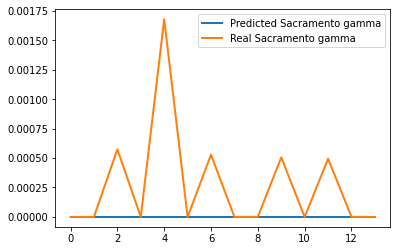

In [163]:
x = range(14)
y1 = mlp1dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

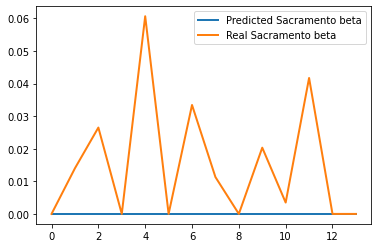

In [164]:
x = range(14)
y1 = mlp1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

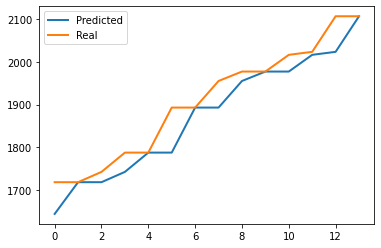

In [165]:
pred_vals = []
for i in range(14):
    pred_vals.append(mlp1dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

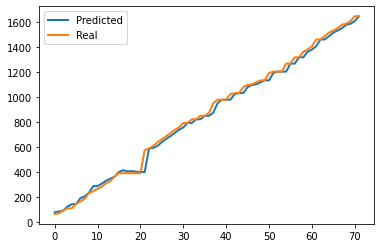

In [167]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(mlp1dc_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## MLP - SIR (loss = gamma)

In [112]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 5000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        loss = th.mean(th.abs(train_labels_gamma_1d[idx] - vals[:,0]))
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(th.abs(valid_labels_gamma_1d[idx] - eval_vals[:,0]))
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(th.abs(test_labels_gamma_1d[idx] - test_vals[:,0]))
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={}, validation loss = {}, test loss={}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=0.34213173389434814, validation loss = 0.23733016848564148, test loss=0.2102014720439911, test mse = 7040.581, test mae = 20.230
epoch=1, loss=0.3417989909648895, validation loss = 0.23689456284046173, test loss=0.20977045595645905, test mse = 7041.227, test mae = 20.251
epoch=2, loss=0.3414449989795685, validation loss = 0.23644781112670898, test loss=0.20932869613170624, test mse = 7041.876, test mae = 20.272
epoch=3, loss=0.34108784794807434, validation loss = 0.23600195348262787, test loss=0.20888791978359222, test mse = 7042.519, test mae = 20.292
epoch=4, loss=0.34073150157928467, validation loss = 0.23555900156497955, test loss=0.20845027267932892, test mse = 7043.152, test mae = 20.313
epoch=5, loss=0.3403768539428711, validation loss = 0.2351192682981491, test loss=0.20801588892936707, test mse = 7043.779, test mae = 20.333
epoch=6, loss=0.34002482891082764, validation loss = 0.23468415439128876, test loss=0.20758633315563202, test mse = 7044.405, t

epoch=57, loss=0.3257893919944763, validation loss = 0.2176811397075653, test loss=0.19092726707458496, test mse = 7073.259, test mae = 21.218
epoch=58, loss=0.32555997371673584, validation loss = 0.2174159735441208, test loss=0.1906694918870926, test mse = 7073.840, test mae = 21.234
epoch=59, loss=0.3253319263458252, validation loss = 0.21715249121189117, test loss=0.19041335582733154, test mse = 7074.419, test mae = 21.250
epoch=60, loss=0.32510489225387573, validation loss = 0.21689032018184662, test loss=0.19015862047672272, test mse = 7074.995, test mae = 21.266
epoch=61, loss=0.3248788118362427, validation loss = 0.21662946045398712, test loss=0.18990518152713776, test mse = 7075.567, test mae = 21.282
epoch=62, loss=0.3246535658836365, validation loss = 0.2163698673248291, test loss=0.18965305387973785, test mse = 7076.138, test mae = 21.298
epoch=63, loss=0.32442930340766907, validation loss = 0.21611157059669495, test loss=0.18940220773220062, test mse = 7076.707, test mae = 

epoch=114, loss=0.31383711099624634, validation loss = 0.20416387915611267, test loss=0.17787019908428192, test mse = 7103.353, test mae = 22.041
epoch=115, loss=0.31364694237709045, validation loss = 0.20395372807979584, test loss=0.1776687353849411, test mse = 7103.878, test mae = 22.055
epoch=116, loss=0.3134573698043823, validation loss = 0.20374427735805511, test loss=0.17746804654598236, test mse = 7104.403, test mae = 22.069
epoch=117, loss=0.3132683336734772, validation loss = 0.20353548228740692, test loss=0.17726799845695496, test mse = 7104.931, test mae = 22.082
epoch=118, loss=0.3130797743797302, validation loss = 0.20332740247249603, test loss=0.17706866562366486, test mse = 7105.459, test mae = 22.096
epoch=119, loss=0.31289181113243103, validation loss = 0.20312006771564484, test loss=0.17687010765075684, test mse = 7105.988, test mae = 22.110
epoch=120, loss=0.3127043545246124, validation loss = 0.20291337370872498, test loss=0.17667217552661896, test mse = 7106.517, t

epoch=171, loss=0.3036397099494934, validation loss = 0.19303078949451447, test loss=0.16725067794322968, test mse = 7135.575, test mae = 22.837
epoch=172, loss=0.30347031354904175, validation loss = 0.19284851849079132, test loss=0.16707757115364075, test mse = 7136.200, test mae = 22.852
epoch=173, loss=0.30330121517181396, validation loss = 0.19266672432422638, test loss=0.16690491139888763, test mse = 7136.826, test mae = 22.866
epoch=174, loss=0.30313241481781006, validation loss = 0.19248531758785248, test loss=0.16673265397548676, test mse = 7137.456, test mae = 22.881
epoch=175, loss=0.30296385288238525, validation loss = 0.19230425357818604, test loss=0.16656073927879333, test mse = 7138.086, test mae = 22.895
epoch=176, loss=0.30279552936553955, validation loss = 0.1921236217021942, test loss=0.16638925671577454, test mse = 7138.722, test mae = 22.910
epoch=177, loss=0.30262744426727295, validation loss = 0.19194330275058746, test loss=0.16621814668178558, test mse = 7139.359

epoch=228, loss=0.2943831980228424, validation loss = 0.18324291706085205, test loss=0.15799139440059662, test mse = 7175.173, test mae = 23.701
epoch=229, loss=0.2942272126674652, validation loss = 0.1830817610025406, test loss=0.15783962607383728, test mse = 7175.925, test mae = 23.716
epoch=230, loss=0.29407140612602234, validation loss = 0.18292100727558136, test loss=0.1576882302761078, test mse = 7176.677, test mae = 23.732
epoch=231, loss=0.29391586780548096, validation loss = 0.1827605962753296, test loss=0.15753719210624695, test mse = 7177.430, test mae = 23.747
epoch=232, loss=0.2937605082988739, validation loss = 0.18260057270526886, test loss=0.15738655626773834, test mse = 7178.180, test mae = 23.763
epoch=233, loss=0.29360532760620117, validation loss = 0.1824408769607544, test loss=0.15723629295825958, test mse = 7178.931, test mae = 23.778
epoch=234, loss=0.29345032572746277, validation loss = 0.18228153884410858, test loss=0.1570863425731659, test mse = 7179.681, test

epoch=285, loss=0.2857852578163147, validation loss = 0.1746058613061905, test loss=0.14989431202411652, test mse = 7213.657, test mae = 24.486
epoch=286, loss=0.28563928604125977, validation loss = 0.17446349561214447, test loss=0.14976143836975098, test mse = 7214.305, test mae = 24.498
epoch=287, loss=0.28549349308013916, validation loss = 0.17432139813899994, test loss=0.14962886273860931, test mse = 7214.958, test mae = 24.511
epoch=288, loss=0.2853478491306305, validation loss = 0.1741795539855957, test loss=0.14949655532836914, test mse = 7215.616, test mae = 24.524
epoch=289, loss=0.28520238399505615, validation loss = 0.17403800785541534, test loss=0.14936448633670807, test mse = 7216.278, test mae = 24.537
epoch=290, loss=0.285057008266449, validation loss = 0.17389671504497528, test loss=0.14923271536827087, test mse = 7216.948, test mae = 24.550
epoch=291, loss=0.2849118411540985, validation loss = 0.1737557202577591, test loss=0.14910122752189636, test mse = 7217.620, test

epoch=342, loss=0.27768242359161377, validation loss = 0.16686639189720154, test loss=0.14270229637622833, test mse = 7256.067, test mae = 25.265
epoch=343, loss=0.2775438129901886, validation loss = 0.16673648357391357, test loss=0.14258214831352234, test mse = 7256.908, test mae = 25.280
epoch=344, loss=0.2774052917957306, validation loss = 0.16660675406455994, test loss=0.14246219396591187, test mse = 7257.751, test mae = 25.295
epoch=345, loss=0.27726686000823975, validation loss = 0.16647717356681824, test loss=0.14234241843223572, test mse = 7258.598, test mae = 25.309
epoch=346, loss=0.27712857723236084, validation loss = 0.16634781658649445, test loss=0.14222286641597748, test mse = 7259.448, test mae = 25.324
epoch=347, loss=0.2769903838634491, validation loss = 0.1662185937166214, test loss=0.14210347831249237, test mse = 7260.302, test mae = 25.339
epoch=348, loss=0.2768523097038269, validation loss = 0.16608956456184387, test loss=0.1419842541217804, test mse = 7261.160, te

epoch=399, loss=0.2699236273765564, validation loss = 0.15969586372375488, test loss=0.13610056042671204, test mse = 7310.566, test mae = 26.155
epoch=400, loss=0.26978936791419983, validation loss = 0.15957330167293549, test loss=0.135988250374794, test mse = 7311.671, test mae = 26.172
epoch=401, loss=0.26965516805648804, validation loss = 0.15945079922676086, test loss=0.13587598502635956, test mse = 7312.779, test mae = 26.189
epoch=402, loss=0.2695210874080658, validation loss = 0.15932835638523102, test loss=0.13576379418373108, test mse = 7313.892, test mae = 26.206
epoch=403, loss=0.2693869173526764, validation loss = 0.15920600295066833, test loss=0.13565170764923096, test mse = 7315.010, test mae = 26.224
epoch=404, loss=0.26925283670425415, validation loss = 0.15908372402191162, test loss=0.1355396807193756, test mse = 7316.133, test mae = 26.241
epoch=405, loss=0.2691187858581543, validation loss = 0.15896151959896088, test loss=0.13542774319648743, test mse = 7317.259, tes

epoch=456, loss=0.26236051321029663, validation loss = 0.1528555452823639, test loss=0.12985314428806305, test mse = 7386.251, test mae = 27.256
epoch=457, loss=0.2622295618057251, validation loss = 0.1527383029460907, test loss=0.12974640727043152, test mse = 7387.903, test mae = 27.279
epoch=458, loss=0.26209867000579834, validation loss = 0.15262112021446228, test loss=0.12963972985744476, test mse = 7389.567, test mae = 27.301
epoch=459, loss=0.26196780800819397, validation loss = 0.15250404179096222, test loss=0.12953317165374756, test mse = 7391.244, test mae = 27.324
epoch=460, loss=0.2618369460105896, validation loss = 0.15238703787326813, test loss=0.12942667305469513, test mse = 7392.930, test mae = 27.347
epoch=461, loss=0.26170614361763, validation loss = 0.15227006375789642, test loss=0.12932027876377106, test mse = 7394.630, test mae = 27.370
epoch=462, loss=0.2615753710269928, validation loss = 0.1521531641483307, test loss=0.12921389937400818, test mse = 7396.342, test 

epoch=513, loss=0.25495079159736633, validation loss = 0.14628706872463226, test loss=0.1238924041390419, test mse = 7507.169, test mae = 28.787
epoch=514, loss=0.25482168793678284, validation loss = 0.14617398381233215, test loss=0.12379009276628494, test mse = 7509.929, test mae = 28.819
epoch=515, loss=0.25469261407852173, validation loss = 0.1460609883069992, test loss=0.12368782609701157, test mse = 7512.714, test mae = 28.852
epoch=516, loss=0.2545635998249054, validation loss = 0.14594806730747223, test loss=0.12358568608760834, test mse = 7515.524, test mae = 28.884
epoch=517, loss=0.25443458557128906, validation loss = 0.14583523571491241, test loss=0.12348361313343048, test mse = 7518.361, test mae = 28.917
epoch=518, loss=0.2543056607246399, validation loss = 0.14572247862815857, test loss=0.12338165193796158, test mse = 7521.223, test mae = 28.951
epoch=519, loss=0.2541767358779907, validation loss = 0.1456098109483719, test loss=0.12327974289655685, test mse = 7524.109, te

epoch=570, loss=0.24765001237392426, validation loss = 0.13996601104736328, test loss=0.11818840354681015, test mse = 7707.056, test mae = 30.945
epoch=571, loss=0.24752277135849, validation loss = 0.13985714316368103, test loss=0.1180904358625412, test mse = 7711.414, test mae = 30.988
epoch=572, loss=0.24739554524421692, validation loss = 0.13974834978580475, test loss=0.11799253523349762, test mse = 7715.805, test mae = 31.032
epoch=573, loss=0.24726836383342743, validation loss = 0.13963960111141205, test loss=0.11789470165967941, test mse = 7720.227, test mae = 31.075
epoch=574, loss=0.24714119732379913, validation loss = 0.13953091204166412, test loss=0.11779693514108658, test mse = 7724.683, test mae = 31.119
epoch=575, loss=0.24701404571533203, validation loss = 0.13942229747772217, test loss=0.11769921332597733, test mse = 7729.171, test mae = 31.163
epoch=576, loss=0.2468869686126709, validation loss = 0.13931377232074738, test loss=0.11760158091783524, test mse = 7733.689, t

epoch=627, loss=0.24042971432209015, validation loss = 0.13384567201137543, test loss=0.11269380897283554, test mse = 8041.384, test mae = 33.898
epoch=628, loss=0.2403034120798111, validation loss = 0.13373951613903046, test loss=0.1125987321138382, test mse = 8050.013, test mae = 33.965
epoch=629, loss=0.24017709493637085, validation loss = 0.13363339006900787, test loss=0.11250366270542145, test mse = 8058.789, test mae = 34.033
epoch=630, loss=0.2400507926940918, validation loss = 0.1335272639989853, test loss=0.11240862309932709, test mse = 8067.713, test mae = 34.102
epoch=631, loss=0.23992449045181274, validation loss = 0.1334211677312851, test loss=0.11231361329555511, test mse = 8076.789, test mae = 34.171
epoch=632, loss=0.2397981733083725, validation loss = 0.13331511616706848, test loss=0.11221866309642792, test mse = 8086.018, test mae = 34.242
epoch=633, loss=0.23967191576957703, validation loss = 0.13320910930633545, test loss=0.11212372034788132, test mse = 8095.411, te

epoch=684, loss=0.2332560271024704, validation loss = 0.12785948812961578, test loss=0.10733955353498459, test mse = 8838.802, test mae = 38.963
epoch=685, loss=0.2331310659646988, validation loss = 0.12775622308254242, test loss=0.10724728554487228, test mse = 8860.310, test mae = 39.076
epoch=686, loss=0.23300616443157196, validation loss = 0.12765304744243622, test loss=0.10715512186288834, test mse = 8882.157, test mae = 39.189
epoch=687, loss=0.23288124799728394, validation loss = 0.1275499314069748, test loss=0.10706301778554916, test mse = 8904.364, test mae = 39.304
epoch=688, loss=0.23275640606880188, validation loss = 0.12744691967964172, test loss=0.10697101801633835, test mse = 8926.929, test mae = 39.419
epoch=689, loss=0.2326316088438034, validation loss = 0.127344012260437, test loss=0.1068790927529335, test mse = 8949.849, test mae = 39.534
epoch=690, loss=0.2325068563222885, validation loss = 0.12724117934703827, test loss=0.10678725689649582, test mse = 8973.143, test

epoch=741, loss=0.2262023240327835, validation loss = 0.12211575359106064, test loss=0.1022181585431099, test mse = 10649.829, test mae = 46.209
epoch=742, loss=0.2260797619819641, validation loss = 0.12201758474111557, test loss=0.10213079303503036, test mse = 10698.412, test mae = 46.361
epoch=743, loss=0.2259572297334671, validation loss = 0.12191947549581528, test loss=0.1020435020327568, test mse = 10748.089, test mae = 46.515
epoch=744, loss=0.22583474218845367, validation loss = 0.12182147055864334, test loss=0.1019563153386116, test mse = 10798.891, test mae = 46.670
epoch=745, loss=0.22571229934692383, validation loss = 0.12172354012727737, test loss=0.10186918079853058, test mse = 10850.844, test mae = 46.828
epoch=746, loss=0.22558991611003876, validation loss = 0.12162571400403976, test loss=0.10178213566541672, test mse = 10904.021, test mae = 46.987
epoch=747, loss=0.2254675179719925, validation loss = 0.12152793258428574, test loss=0.10169516503810883, test mse = 10958.4

epoch=797, loss=0.21939615905284882, validation loss = 0.1167430430650711, test loss=0.09744544327259064, test mse = 19691.895, test mae = 61.692
epoch=798, loss=0.21927578747272491, validation loss = 0.11664942651987076, test loss=0.09736243635416031, test mse = 20641.439, test mae = 62.458
epoch=799, loss=0.21915550529956818, validation loss = 0.11655588448047638, test loss=0.09727948158979416, test mse = 21817.322, test mae = 63.295
epoch=800, loss=0.21903522312641144, validation loss = 0.11646242439746857, test loss=0.09719662368297577, test mse = 23294.764, test mae = 64.212
epoch=801, loss=0.21891501545906067, validation loss = 0.11636904627084732, test loss=0.09711381047964096, test mse = 25172.582, test mae = 65.218
epoch=802, loss=0.2187948375940323, validation loss = 0.11627575010061264, test loss=0.09703110158443451, test mse = 27577.707, test mae = 66.326
epoch=803, loss=0.2186747044324875, validation loss = 0.11618251353502274, test loss=0.09694844484329224, test mse = 306

epoch=853, loss=0.21272048354148865, validation loss = 0.1116170734167099, test loss=0.09290699660778046, test mse = 8184118.500, test mae = 342.669
epoch=854, loss=0.21260231733322144, validation loss = 0.11152757704257965, test loss=0.09282789379358292, test mse = 8494891.000, test mae = 348.100
epoch=855, loss=0.2124841958284378, validation loss = 0.11143815517425537, test loss=0.09274884313344955, test mse = 8731945.000, test mae = 352.618
epoch=856, loss=0.21236610412597656, validation loss = 0.11134880036115646, test loss=0.09266985952854156, test mse = 8866659.000, test mae = 356.360
epoch=857, loss=0.2122480571269989, validation loss = 0.11125952750444412, test loss=0.09259094297885895, test mse = 8936928.000, test mae = 359.704
epoch=858, loss=0.21213003993034363, validation loss = 0.11117032915353775, test loss=0.0925121083855629, test mse = 8983038.000, test mae = 362.894
epoch=859, loss=0.21201208233833313, validation loss = 0.11108116805553436, test loss=0.0924333333969116

epoch=908, loss=0.20627468824386597, validation loss = 0.10679242759943008, test loss=0.08864915370941162, test mse = 9702777.000, test mae = 441.868
epoch=909, loss=0.20615842938423157, validation loss = 0.10670642554759979, test loss=0.0885734036564827, test mse = 9708274.000, test mae = 442.819
epoch=910, loss=0.20604215562343597, validation loss = 0.10662049800157547, test loss=0.08849769830703735, test mse = 9713661.000, test mae = 443.755
epoch=911, loss=0.20592591166496277, validation loss = 0.10653461515903473, test loss=0.08842206746339798, test mse = 9718936.000, test mae = 444.677
epoch=912, loss=0.20580971240997314, validation loss = 0.10644878447055817, test loss=0.08834648877382278, test mse = 9724099.000, test mae = 445.586
epoch=913, loss=0.20569352805614471, validation loss = 0.10636303573846817, test loss=0.08827096968889236, test mse = 9729149.000, test mae = 446.482
epoch=914, loss=0.20557738840579987, validation loss = 0.10627733916044235, test loss=0.0881955102086

epoch=963, loss=0.19993318617343903, validation loss = 0.1021575853228569, test loss=0.08457151800394058, test mse = 9877397.000, test mae = 480.738
epoch=964, loss=0.19981883466243744, validation loss = 0.10207502543926239, test loss=0.08449898660182953, test mse = 9879352.000, test mae = 481.337
epoch=965, loss=0.19970452785491943, validation loss = 0.10199253261089325, test loss=0.08442652225494385, test mse = 9881311.000, test mae = 481.937
epoch=966, loss=0.199590265750885, validation loss = 0.10191009938716888, test loss=0.08435411751270294, test mse = 9883274.000, test mae = 482.536
epoch=967, loss=0.19947601854801178, validation loss = 0.10182773321866989, test loss=0.08428176492452621, test mse = 9885247.000, test mae = 483.140
epoch=968, loss=0.19936180114746094, validation loss = 0.10174541920423508, test loss=0.08420947939157486, test mse = 9887230.000, test mae = 483.748
epoch=969, loss=0.19924762845039368, validation loss = 0.10166317224502563, test loss=0.084137246012687

epoch=1018, loss=0.19369173049926758, validation loss = 0.09770678728818893, test loss=0.08066723495721817, test mse = 11206305.000, test mae = 530.690
epoch=1019, loss=0.19357919692993164, validation loss = 0.09762754291296005, test loss=0.08059783279895782, test mse = 11266821.000, test mae = 532.078
epoch=1020, loss=0.1934666782617569, validation loss = 0.09754835814237595, test loss=0.08052849024534225, test mse = 11345235.000, test mae = 533.275
epoch=1021, loss=0.19335418939590454, validation loss = 0.09746922552585602, test loss=0.08045919239521027, test mse = 11386811.000, test mae = 534.336
epoch=1022, loss=0.19324171543121338, validation loss = 0.09739013761281967, test loss=0.08038995414972305, test mse = 11419539.000, test mae = 535.535
epoch=1023, loss=0.193129301071167, validation loss = 0.0973111242055893, test loss=0.08032076060771942, test mse = 11490978.000, test mae = 536.916
epoch=1024, loss=0.1930169016122818, validation loss = 0.0972321555018425, test loss=0.08025

epoch=1073, loss=0.18755459785461426, validation loss = 0.09343478828668594, test loss=0.07693208009004593, test mse = 13060129.000, test mae = 583.173
epoch=1074, loss=0.18744388222694397, validation loss = 0.09335863590240479, test loss=0.07686561346054077, test mse = 13066064.000, test mae = 583.864
epoch=1075, loss=0.18733321130275726, validation loss = 0.09328252822160721, test loss=0.07679922133684158, test mse = 13072208.000, test mae = 584.554
epoch=1076, loss=0.18722257018089294, validation loss = 0.0932064801454544, test loss=0.07673286646604538, test mse = 13078631.000, test mae = 585.253
epoch=1077, loss=0.187111958861351, validation loss = 0.09313050657510757, test loss=0.07666657865047455, test mse = 13085346.000, test mae = 585.956
epoch=1078, loss=0.18700140714645386, validation loss = 0.09305457025766373, test loss=0.0766003280878067, test mse = 13092323.000, test mae = 586.659
epoch=1079, loss=0.1868908852338791, validation loss = 0.09297870099544525, test loss=0.0765

epoch=1128, loss=0.1815105825662613, validation loss = 0.08932597190141678, test loss=0.07335269451141357, test mse = 13400217.000, test mae = 621.746
epoch=1129, loss=0.18140141665935516, validation loss = 0.08925266563892365, test loss=0.0732889398932457, test mse = 13405401.000, test mae = 622.358
epoch=1130, loss=0.18129226565361023, validation loss = 0.0891793966293335, test loss=0.07322525978088379, test mse = 13410385.000, test mae = 622.958
epoch=1131, loss=0.1811831295490265, validation loss = 0.08910617977380753, test loss=0.07316159456968307, test mse = 13415195.000, test mae = 623.556
epoch=1132, loss=0.18107403814792633, validation loss = 0.08903302252292633, test loss=0.07309798896312714, test mse = 13419851.000, test mae = 624.167
epoch=1133, loss=0.18096496164798737, validation loss = 0.08895990997552872, test loss=0.07303442806005478, test mse = 13424389.000, test mae = 624.777
epoch=1134, loss=0.1808559149503708, validation loss = 0.08888683468103409, test loss=0.0729

epoch=1183, loss=0.17553679645061493, validation loss = 0.0853617861866951, test loss=0.06991247087717056, test mse = 13675453.000, test mae = 654.157
epoch=1184, loss=0.17542849481105804, validation loss = 0.08529082685709, test loss=0.06985103338956833, test mse = 13679725.000, test mae = 654.694
epoch=1185, loss=0.17532022297382355, validation loss = 0.08521991223096848, test loss=0.06978963315486908, test mse = 13684146.000, test mae = 655.232
epoch=1186, loss=0.17521198093891144, validation loss = 0.08514903485774994, test loss=0.0697282925248146, test mse = 13688823.000, test mae = 655.776
epoch=1187, loss=0.17510375380516052, validation loss = 0.08507819473743439, test loss=0.06966696679592133, test mse = 13693923.000, test mae = 656.326
epoch=1188, loss=0.174995556473732, validation loss = 0.08500742167234421, test loss=0.06960570067167282, test mse = 13699690.000, test mae = 656.881
epoch=1189, loss=0.17488738894462585, validation loss = 0.08493667840957642, test loss=0.069544

epoch=1238, loss=0.1696157455444336, validation loss = 0.08152132481336594, test loss=0.06659328192472458, test mse = 14025459.000, test mae = 683.342
epoch=1239, loss=0.16950862109661102, validation loss = 0.08145260810852051, test loss=0.06653402000665665, test mse = 14030267.000, test mae = 683.771
epoch=1240, loss=0.16940148174762726, validation loss = 0.08138392120599747, test loss=0.0664747804403305, test mse = 14035103.000, test mae = 684.189
epoch=1241, loss=0.1692943572998047, validation loss = 0.08131527900695801, test loss=0.06641559302806854, test mse = 14039698.000, test mae = 684.592
epoch=1242, loss=0.1691872924566269, validation loss = 0.08124667406082153, test loss=0.06635643541812897, test mse = 14043851.000, test mae = 684.977
epoch=1243, loss=0.1690802276134491, validation loss = 0.08117811381816864, test loss=0.06629733741283417, test mse = 14047471.000, test mae = 685.345
epoch=1244, loss=0.1689731776714325, validation loss = 0.08110959082841873, test loss=0.06623

epoch=1293, loss=0.16374921798706055, validation loss = 0.07779836654663086, test loss=0.06338931620121002, test mse = 14141341.000, test mae = 699.938
epoch=1294, loss=0.16364309191703796, validation loss = 0.07773173600435257, test loss=0.06333209574222565, test mse = 14142081.000, test mae = 700.177
epoch=1295, loss=0.16353699564933777, validation loss = 0.07766515761613846, test loss=0.06327491253614426, test mse = 14142786.000, test mae = 700.410
epoch=1296, loss=0.16343091428279877, validation loss = 0.07759861648082733, test loss=0.06321778148412704, test mse = 14143447.000, test mae = 700.629
epoch=1297, loss=0.16332486271858215, validation loss = 0.077532097697258, test loss=0.06316068023443222, test mse = 14144110.000, test mae = 700.845
epoch=1298, loss=0.16321882605552673, validation loss = 0.07746563106775284, test loss=0.06310360133647919, test mse = 14145089.000, test mae = 701.158
epoch=1299, loss=0.1631128191947937, validation loss = 0.07739917933940887, test loss=0.06

epoch=1348, loss=0.15794631838798523, validation loss = 0.07418974488973618, test loss=0.0602961964905262, test mse = 14643635.000, test mae = 724.649
epoch=1349, loss=0.1578415036201477, validation loss = 0.07412523776292801, test loss=0.0602409802377224, test mse = 14647861.000, test mae = 724.949
epoch=1350, loss=0.15773668885231018, validation loss = 0.07406075298786163, test loss=0.06018581613898277, test mse = 14651514.000, test mae = 725.230
epoch=1351, loss=0.15763188898563385, validation loss = 0.07399632036685944, test loss=0.060130681842565536, test mse = 14654534.000, test mae = 725.496
epoch=1352, loss=0.1575271189212799, validation loss = 0.07393193244934082, test loss=0.060075581073760986, test mse = 14656990.000, test mae = 725.749
epoch=1353, loss=0.15742236375808716, validation loss = 0.0738675594329834, test loss=0.060020510107278824, test mse = 14659003.000, test mae = 725.991
epoch=1354, loss=0.1573176383972168, validation loss = 0.07380324602127075, test loss=0.05

epoch=1402, loss=0.15231384336948395, validation loss = 0.07075663655996323, test loss=0.05736387148499489, test mse = 14698899.000, test mae = 734.711
epoch=1403, loss=0.15220993757247925, validation loss = 0.07069399207830429, test loss=0.05731046944856644, test mse = 14699377.000, test mae = 734.845
epoch=1404, loss=0.15210607647895813, validation loss = 0.07063136249780655, test loss=0.05725710466504097, test mse = 14699848.000, test mae = 734.977
epoch=1405, loss=0.1520022302865982, validation loss = 0.07056878507137299, test loss=0.057203762233257294, test mse = 14700314.000, test mae = 735.109
epoch=1406, loss=0.15189841389656067, validation loss = 0.070506252348423, test loss=0.057150453329086304, test mse = 14700773.000, test mae = 735.239
epoch=1407, loss=0.15179459750652313, validation loss = 0.07044373452663422, test loss=0.057097192853689194, test mse = 14701227.000, test mae = 735.368
epoch=1408, loss=0.15169082581996918, validation loss = 0.0703812688589096, test loss=0.

epoch=1456, loss=0.14673712849617004, validation loss = 0.06742657721042633, test loss=0.05452974885702133, test mse = 14717970.000, test mae = 740.351
epoch=1457, loss=0.14663462340831757, validation loss = 0.06736598908901215, test loss=0.05447826534509659, test mse = 14718162.000, test mae = 740.422
epoch=1458, loss=0.14653216302394867, validation loss = 0.06730543822050095, test loss=0.05442682281136513, test mse = 14718343.000, test mae = 740.492
epoch=1459, loss=0.14642974734306335, validation loss = 0.06724493205547333, test loss=0.05437541380524635, test mse = 14718519.000, test mae = 740.561
epoch=1460, loss=0.14632733166217804, validation loss = 0.0671844556927681, test loss=0.054324038326740265, test mse = 14718682.000, test mae = 740.629
epoch=1461, loss=0.1462249755859375, validation loss = 0.06712402403354645, test loss=0.054272688925266266, test mse = 14718842.000, test mae = 740.696
epoch=1462, loss=0.14612261950969696, validation loss = 0.06706360727548599, test loss=0

epoch=1510, loss=0.14123310148715973, validation loss = 0.0642038956284523, test loss=0.05179610103368759, test mse = 14722526.000, test mae = 743.314
epoch=1511, loss=0.14113157987594604, validation loss = 0.06414509564638138, test loss=0.051746319979429245, test mse = 14722567.000, test mae = 743.359
epoch=1512, loss=0.14103005826473236, validation loss = 0.06408633291721344, test loss=0.051696572452783585, test mse = 14722608.000, test mae = 743.404
epoch=1513, loss=0.14092858135700226, validation loss = 0.06402759253978729, test loss=0.05164685845375061, test mse = 14722647.000, test mae = 743.448
epoch=1514, loss=0.14082711935043335, validation loss = 0.06396888196468353, test loss=0.05159716680645943, test mse = 14722688.000, test mae = 743.492
epoch=1515, loss=0.14072567224502563, validation loss = 0.06391020864248276, test loss=0.05154750496149063, test mse = 14722727.000, test mae = 743.536
epoch=1516, loss=0.1406242549419403, validation loss = 0.06385155767202377, test loss=0

epoch=1564, loss=0.13578087091445923, validation loss = 0.06107296422123909, test loss=0.049151089042425156, test mse = 14724262.000, test mae = 745.470
epoch=1565, loss=0.13568054139614105, validation loss = 0.06101588159799576, test loss=0.049102962017059326, test mse = 14724288.000, test mae = 745.506
epoch=1566, loss=0.13558024168014526, validation loss = 0.060958825051784515, test loss=0.04905487224459648, test mse = 14724313.000, test mae = 745.541
epoch=1567, loss=0.13547995686531067, validation loss = 0.060901809483766556, test loss=0.04900679737329483, test mse = 14724337.000, test mae = 745.577
epoch=1568, loss=0.13537971675395966, validation loss = 0.060844819992780685, test loss=0.048958759754896164, test mse = 14724363.000, test mae = 745.613
epoch=1569, loss=0.13527949154376984, validation loss = 0.0607878677546978, test loss=0.04891076311469078, test mse = 14724389.000, test mae = 745.648
epoch=1570, loss=0.1351792812347412, validation loss = 0.0607309527695179, test los

epoch=1618, loss=0.13039760291576385, validation loss = 0.05803756043314934, test loss=0.046596575528383255, test mse = 14725497.000, test mae = 747.243
epoch=1619, loss=0.13029858469963074, validation loss = 0.05798226594924927, test loss=0.04655012488365173, test mse = 14725519.000, test mae = 747.273
epoch=1620, loss=0.1301996111869812, validation loss = 0.057927001267671585, test loss=0.046503711491823196, test mse = 14725537.000, test mae = 747.302
epoch=1621, loss=0.13010066747665405, validation loss = 0.05787176638841629, test loss=0.04645732790231705, test mse = 14725558.000, test mae = 747.332
epoch=1622, loss=0.1300017237663269, validation loss = 0.05781656131148338, test loss=0.04641097038984299, test mse = 14725576.000, test mae = 747.361
epoch=1623, loss=0.12990280985832214, validation loss = 0.05776139721274376, test loss=0.04636465385556221, test mse = 14725595.000, test mae = 747.390
epoch=1624, loss=0.12980394065380096, validation loss = 0.057706259191036224, test loss

epoch=1672, loss=0.12508106231689453, validation loss = 0.05509548634290695, test loss=0.044130269438028336, test mse = 14726432.000, test mae = 748.698
epoch=1673, loss=0.12498319149017334, validation loss = 0.0550418384373188, test loss=0.044085390865802765, test mse = 14726448.000, test mae = 748.722
epoch=1674, loss=0.12488535046577454, validation loss = 0.05498821660876274, test loss=0.044040534645318985, test mse = 14726463.000, test mae = 748.747
epoch=1675, loss=0.12478750199079514, validation loss = 0.05493461713194847, test loss=0.043995704501867294, test mse = 14726477.000, test mae = 748.771
epoch=1676, loss=0.12468971312046051, validation loss = 0.05488104373216629, test loss=0.043950896710157394, test mse = 14726491.000, test mae = 748.795
epoch=1677, loss=0.12459190934896469, validation loss = 0.0548275001347065, test loss=0.043906114995479584, test mse = 14726506.000, test mae = 748.819
epoch=1678, loss=0.12449415773153305, validation loss = 0.05477399379014969, test lo

epoch=1726, loss=0.11982923001050949, validation loss = 0.05223969370126724, test loss=0.04174608364701271, test mse = 14727123.000, test mae = 749.908
epoch=1727, loss=0.11973251402378082, validation loss = 0.052187591791152954, test loss=0.04170267656445503, test mse = 14727134.000, test mae = 749.928
epoch=1728, loss=0.11963585019111633, validation loss = 0.052135515958070755, test loss=0.04165929555892944, test mse = 14727143.000, test mae = 749.949
epoch=1729, loss=0.11953917890787125, validation loss = 0.05208345875144005, test loss=0.041615940630435944, test mse = 14727154.000, test mae = 749.969
epoch=1730, loss=0.11944254487752914, validation loss = 0.052031438797712326, test loss=0.04157261177897453, test mse = 14727165.000, test mae = 749.989
epoch=1731, loss=0.11934595555067062, validation loss = 0.05197945237159729, test loss=0.041529323905706406, test mse = 14727176.000, test mae = 750.009
epoch=1732, loss=0.1192493587732315, validation loss = 0.05192750692367554, test lo

epoch=1780, loss=0.11464682966470718, validation loss = 0.049470312893390656, test loss=0.03944314643740654, test mse = 14727621.000, test mae = 750.935
epoch=1781, loss=0.11455163359642029, validation loss = 0.049419891089200974, test loss=0.03940130025148392, test mse = 14727627.000, test mae = 750.952
epoch=1782, loss=0.11445649713277817, validation loss = 0.04936950281262398, test loss=0.039359476417303085, test mse = 14727637.000, test mae = 750.970
epoch=1783, loss=0.11436137557029724, validation loss = 0.04931914061307907, test loss=0.03931768611073494, test mse = 14727645.000, test mae = 750.987
epoch=1784, loss=0.11426626145839691, validation loss = 0.049268804490566254, test loss=0.039275918155908585, test mse = 14727651.000, test mae = 751.005
epoch=1785, loss=0.11417118459939957, validation loss = 0.049218494445085526, test loss=0.03923416510224342, test mse = 14727658.000, test mae = 751.022
epoch=1786, loss=0.11407613754272461, validation loss = 0.049168217927217484, test

epoch=1834, loss=0.10952690243721008, validation loss = 0.04678007587790489, test loss=0.03721524029970169, test mse = 14727979.000, test mae = 751.812
epoch=1835, loss=0.10943268239498138, validation loss = 0.04673096537590027, test loss=0.037174660712480545, test mse = 14727985.000, test mae = 751.828
epoch=1836, loss=0.10933850705623627, validation loss = 0.04668188467621803, test loss=0.03713410347700119, test mse = 14727991.000, test mae = 751.842
epoch=1837, loss=0.10924433916807175, validation loss = 0.046632830053567886, test loss=0.037093572318553925, test mse = 14727998.000, test mae = 751.857
epoch=1838, loss=0.10915021598339081, validation loss = 0.046583808958530426, test loss=0.03705307096242905, test mse = 14728001.000, test mae = 751.872
epoch=1839, loss=0.10905612260103226, validation loss = 0.04653482884168625, test loss=0.03701259568333626, test mse = 14728008.000, test mae = 751.887
epoch=1840, loss=0.1089620515704155, validation loss = 0.046485889703035355, test lo

epoch=1888, loss=0.10448009520769119, validation loss = 0.04417124390602112, test loss=0.03506285697221756, test mse = 14728245.000, test mae = 752.560
epoch=1889, loss=0.10438739508390427, validation loss = 0.04412370175123215, test loss=0.035023704171180725, test mse = 14728250.000, test mae = 752.573
epoch=1890, loss=0.10429473966360092, validation loss = 0.04407619312405586, test loss=0.03498458117246628, test mse = 14728255.000, test mae = 752.586
epoch=1891, loss=0.10420209914445877, validation loss = 0.04402870684862137, test loss=0.03494549170136452, test mse = 14728258.000, test mae = 752.598
epoch=1892, loss=0.1041094958782196, validation loss = 0.043981246650218964, test loss=0.03490642085671425, test mse = 14728262.000, test mae = 752.611
epoch=1893, loss=0.10401692986488342, validation loss = 0.04393382743000984, test loss=0.034867383539676666, test mse = 14728266.000, test mae = 752.624
epoch=1894, loss=0.10392437875270844, validation loss = 0.043886441737413406, test los

epoch=1942, loss=0.09951676428318024, validation loss = 0.04164459556341171, test loss=0.032985854893922806, test mse = 14728447.000, test mae = 753.194
epoch=1943, loss=0.09942568093538284, validation loss = 0.04159857705235481, test loss=0.03294810280203819, test mse = 14728449.000, test mae = 753.204
epoch=1944, loss=0.09933464974164963, validation loss = 0.0415525920689106, test loss=0.032910365611314774, test mse = 14728451.000, test mae = 753.215
epoch=1945, loss=0.0992436408996582, validation loss = 0.04150662198662758, test loss=0.03287266567349434, test mse = 14728455.000, test mae = 753.226
epoch=1946, loss=0.09915267676115036, validation loss = 0.04146070405840874, test loss=0.032834988087415695, test mse = 14728458.000, test mae = 753.236
epoch=1947, loss=0.0990617424249649, validation loss = 0.04141479358077049, test loss=0.03279733285307884, test mse = 14728462.000, test mae = 753.247
epoch=1948, loss=0.09897083789110184, validation loss = 0.04136890918016434, test loss=0

epoch=1996, loss=0.09464334696531296, validation loss = 0.03920050710439682, test loss=0.030983692035079002, test mse = 14728602.000, test mae = 753.737
epoch=1997, loss=0.09455394744873047, validation loss = 0.039156049489974976, test loss=0.030947329476475716, test mse = 14728606.000, test mae = 753.747
epoch=1998, loss=0.09446457028388977, validation loss = 0.03911159187555313, test loss=0.030910983681678772, test mse = 14728608.000, test mae = 753.756
epoch=1999, loss=0.09437521547079086, validation loss = 0.03906716778874397, test loss=0.03087465837597847, test mse = 14728611.000, test mae = 753.766
epoch=2000, loss=0.09428587555885315, validation loss = 0.039022766053676605, test loss=0.03083835169672966, test mse = 14728614.000, test mae = 753.775
epoch=2001, loss=0.09419658780097961, validation loss = 0.038978397846221924, test loss=0.030802074819803238, test mse = 14728615.000, test mae = 753.784
epoch=2002, loss=0.09410732239484787, validation loss = 0.03893405199050903, test

epoch=2050, loss=0.08985703438520432, validation loss = 0.03683973476290703, test loss=0.02905641868710518, test mse = 14728731.000, test mae = 754.223
epoch=2051, loss=0.08976925909519196, validation loss = 0.03679680824279785, test loss=0.02902144193649292, test mse = 14728734.000, test mae = 754.232
epoch=2052, loss=0.08968152105808258, validation loss = 0.03675391897559166, test loss=0.028986496850848198, test mse = 14728737.000, test mae = 754.240
epoch=2053, loss=0.0895938128232956, validation loss = 0.03671104833483696, test loss=0.028951574116945267, test mse = 14728739.000, test mae = 754.249
epoch=2054, loss=0.08950614184141159, validation loss = 0.036668211221694946, test loss=0.028916677460074425, test mse = 14728741.000, test mae = 754.257
epoch=2055, loss=0.08941850066184998, validation loss = 0.036625392735004425, test loss=0.028881803154945374, test mse = 14728743.000, test mae = 754.266
epoch=2056, loss=0.08933089673519135, validation loss = 0.036582596600055695, test 

epoch=2104, loss=0.08516497164964676, validation loss = 0.034563515335321426, test loss=0.027205253019928932, test mse = 14728834.000, test mae = 754.638
epoch=2105, loss=0.08507905900478363, validation loss = 0.03452223911881447, test loss=0.02717173472046852, test mse = 14728837.000, test mae = 754.645
epoch=2106, loss=0.08499319106340408, validation loss = 0.0344809927046299, test loss=0.0271382387727499, test mse = 14728838.000, test mae = 754.652
epoch=2107, loss=0.08490735292434692, validation loss = 0.034439779818058014, test loss=0.027104774489998817, test mse = 14728839.000, test mae = 754.658
epoch=2108, loss=0.08482155203819275, validation loss = 0.034398600459098816, test loss=0.027071338146924973, test mse = 14728841.000, test mae = 754.665
epoch=2109, loss=0.08473579585552216, validation loss = 0.034357450902462006, test loss=0.027037929743528366, test mse = 14728843.000, test mae = 754.672
epoch=2110, loss=0.08465007692575455, validation loss = 0.034316327422857285, test

epoch=2158, loss=0.0805811882019043, validation loss = 0.03237908333539963, test loss=0.025434235110878944, test mse = 14728914.000, test mae = 754.972
epoch=2159, loss=0.08049733191728592, validation loss = 0.03233947232365608, test loss=0.025402169674634933, test mse = 14728917.000, test mae = 754.978
epoch=2160, loss=0.08041349798440933, validation loss = 0.03229989483952522, test loss=0.02537013404071331, test mse = 14728918.000, test mae = 754.984
epoch=2161, loss=0.08032972365617752, validation loss = 0.03226033225655556, test loss=0.025338122621178627, test mse = 14728918.000, test mae = 754.990
epoch=2162, loss=0.0802459716796875, validation loss = 0.032220806926488876, test loss=0.025306129828095436, test mse = 14728920.000, test mae = 754.995
epoch=2163, loss=0.08016225695610046, validation loss = 0.03218129649758339, test loss=0.025274163112044334, test mse = 14728920.000, test mae = 755.001
epoch=2164, loss=0.08007856458425522, validation loss = 0.032141782343387604, test l

epoch=2212, loss=0.07611061632633209, validation loss = 0.03028205968439579, test loss=0.023739857599139214, test mse = 14728982.000, test mae = 755.271
epoch=2213, loss=0.076028972864151, validation loss = 0.03024406172335148, test loss=0.023709211498498917, test mse = 14728983.000, test mae = 755.276
epoch=2214, loss=0.0759473666548729, validation loss = 0.030206097289919853, test loss=0.02367859147489071, test mse = 14728984.000, test mae = 755.282
epoch=2215, loss=0.07586579769849777, validation loss = 0.030168164521455765, test loss=0.023648003116250038, test mse = 14728986.000, test mae = 755.287
epoch=2216, loss=0.07578427344560623, validation loss = 0.030130261555314064, test loss=0.023617440834641457, test mse = 14728987.000, test mae = 755.292
epoch=2217, loss=0.07570279389619827, validation loss = 0.030092386528849602, test loss=0.023586900904774666, test mse = 14728989.000, test mae = 755.298
epoch=2218, loss=0.0756213590502739, validation loss = 0.030054543167352676, test 

epoch=2266, loss=0.07176575064659119, validation loss = 0.02827666699886322, test loss=0.02212485671043396, test mse = 14729043.000, test mae = 755.556
epoch=2267, loss=0.07168654352426529, validation loss = 0.028240418061614037, test loss=0.022095710039138794, test mse = 14729045.000, test mae = 755.562
epoch=2268, loss=0.07160738855600357, validation loss = 0.028204208239912987, test loss=0.022066595032811165, test mse = 14729047.000, test mae = 755.567
epoch=2269, loss=0.07152827829122543, validation loss = 0.028168024495244026, test loss=0.022037506103515625, test mse = 14729047.000, test mae = 755.572
epoch=2270, loss=0.07144922763109207, validation loss = 0.0281318761408329, test loss=0.022008446976542473, test mse = 14729047.000, test mae = 755.577
epoch=2271, loss=0.0713702142238617, validation loss = 0.02809576317667961, test loss=0.02197941206395626, test mse = 14729049.000, test mae = 755.582
epoch=2272, loss=0.0712912455201149, validation loss = 0.02805968001484871, test lo

epoch=2320, loss=0.06755995750427246, validation loss = 0.026366127654910088, test loss=0.02059119939804077, test mse = 14729099.000, test mae = 755.819
epoch=2321, loss=0.06748352199792862, validation loss = 0.026331668719649315, test loss=0.020563581958413124, test mse = 14729099.000, test mae = 755.824
epoch=2322, loss=0.06740716099739075, validation loss = 0.02629724144935608, test loss=0.020535992458462715, test mse = 14729102.000, test mae = 755.828
epoch=2323, loss=0.06733082234859467, validation loss = 0.02626284770667553, test loss=0.020508427172899246, test mse = 14729102.000, test mae = 755.833
epoch=2324, loss=0.06725453585386276, validation loss = 0.026228485628962517, test loss=0.020480897277593613, test mse = 14729102.000, test mae = 755.837
epoch=2325, loss=0.06717830151319504, validation loss = 0.026194153353571892, test loss=0.020453384146094322, test mse = 14729103.000, test mae = 755.842
epoch=2326, loss=0.0671021118760109, validation loss = 0.026159850880503654, te

epoch=2374, loss=0.06350132077932358, validation loss = 0.024551035836338997, test loss=0.019138531759381294, test mse = 14729144.000, test mae = 756.050
epoch=2375, loss=0.06342748552560806, validation loss = 0.024518297985196114, test loss=0.019112367182970047, test mse = 14729146.000, test mae = 756.054
epoch=2376, loss=0.06335371732711792, validation loss = 0.02448558807373047, test loss=0.019086230546236038, test mse = 14729146.000, test mae = 756.058
epoch=2377, loss=0.06327999383211136, validation loss = 0.02445291168987751, test loss=0.01906011812388897, test mse = 14729147.000, test mae = 756.062
epoch=2378, loss=0.06320631504058838, validation loss = 0.02442026697099209, test loss=0.01903403364121914, test mse = 14729149.000, test mae = 756.066
epoch=2379, loss=0.06313268840312958, validation loss = 0.024387653917074203, test loss=0.019007977098226547, test mse = 14729149.000, test mae = 756.070
epoch=2380, loss=0.06305910646915436, validation loss = 0.024355070665478706, tes

epoch=2428, loss=0.05958602949976921, validation loss = 0.022827789187431335, test loss=0.01776348613202572, test mse = 14729183.000, test mae = 756.254
epoch=2429, loss=0.05951489880681038, validation loss = 0.02279673144221306, test loss=0.017738742753863335, test mse = 14729185.000, test mae = 756.258
epoch=2430, loss=0.059443823993206024, validation loss = 0.02276570536196232, test loss=0.01771402731537819, test mse = 14729185.000, test mae = 756.261
epoch=2431, loss=0.05937279760837555, validation loss = 0.022734714671969414, test loss=0.017689337953925133, test mse = 14729185.000, test mae = 756.265
epoch=2432, loss=0.059301819652318954, validation loss = 0.022703753784298897, test loss=0.017664680257439613, test mse = 14729186.000, test mae = 756.268
epoch=2433, loss=0.05923089757561684, validation loss = 0.02267282083630562, test loss=0.017640043050050735, test mse = 14729186.000, test mae = 756.272
epoch=2434, loss=0.059160035103559494, validation loss = 0.022641923278570175, 

epoch=2482, loss=0.05581522732973099, validation loss = 0.021193236112594604, test loss=0.01646333560347557, test mse = 14729216.000, test mae = 756.436
epoch=2483, loss=0.055746693164110184, validation loss = 0.021163765341043472, test loss=0.016439931467175484, test mse = 14729216.000, test mae = 756.439
epoch=2484, loss=0.05567820742726326, validation loss = 0.02113432064652443, test loss=0.016416551545262337, test mse = 14729217.000, test mae = 756.443
epoch=2485, loss=0.055609770119190216, validation loss = 0.021104911342263222, test loss=0.01639319397509098, test mse = 14729218.000, test mae = 756.446
epoch=2486, loss=0.05554138869047165, validation loss = 0.021075526252388954, test loss=0.016369862481951714, test mse = 14729218.000, test mae = 756.449
epoch=2487, loss=0.055473048239946365, validation loss = 0.021046170964837074, test loss=0.016346558928489685, test mse = 14729219.000, test mae = 756.452
epoch=2488, loss=0.05540476366877556, validation loss = 0.02101684734225273,

epoch=2536, loss=0.052187126129865646, validation loss = 0.019643578678369522, test loss=0.015234602615237236, test mse = 14729245.000, test mae = 756.602
epoch=2537, loss=0.0521213673055172, validation loss = 0.01961568370461464, test loss=0.01521251816302538, test mse = 14729245.000, test mae = 756.604
epoch=2538, loss=0.052055664360523224, validation loss = 0.019587818533182144, test loss=0.015190458856523037, test mse = 14729245.000, test mae = 756.607
epoch=2539, loss=0.05199000611901283, validation loss = 0.019559985026717186, test loss=0.015168423764407635, test mse = 14729247.000, test mae = 756.610
epoch=2540, loss=0.05192439630627632, validation loss = 0.019532177597284317, test loss=0.015146411955356598, test mse = 14729247.000, test mae = 756.613
epoch=2541, loss=0.051858849823474884, validation loss = 0.019504398107528687, test loss=0.015124424360692501, test mse = 14729247.000, test mae = 756.616
epoch=2542, loss=0.05179334804415703, validation loss = 0.019476648420095444

epoch=2590, loss=0.04870639741420746, validation loss = 0.01817762292921543, test loss=0.01407561544328928, test mse = 14729270.000, test mae = 756.755
epoch=2591, loss=0.04864325746893883, validation loss = 0.018151234835386276, test loss=0.014054783619940281, test mse = 14729271.000, test mae = 756.758
epoch=2592, loss=0.048580169677734375, validation loss = 0.01812487468123436, test loss=0.014033973217010498, test mse = 14729271.000, test mae = 756.760
epoch=2593, loss=0.0485171340405941, validation loss = 0.018098538741469383, test loss=0.01401318609714508, test mse = 14729272.000, test mae = 756.763
epoch=2594, loss=0.04845414683222771, validation loss = 0.018072234466671944, test loss=0.013992422260344028, test mse = 14729272.000, test mae = 756.766
epoch=2595, loss=0.04839120805263519, validation loss = 0.018045956268906593, test loss=0.013971681706607342, test mse = 14729272.000, test mae = 756.769
epoch=2596, loss=0.048328325152397156, validation loss = 0.018019704148173332, t

epoch=2644, loss=0.04536738619208336, validation loss = 0.0167902372777462, test loss=0.012982087209820747, test mse = 14729294.000, test mae = 756.898
epoch=2645, loss=0.045306939631700516, validation loss = 0.016765285283327103, test loss=0.012962447479367256, test mse = 14729294.000, test mae = 756.901
epoch=2646, loss=0.04524655267596245, validation loss = 0.016740357503294945, test loss=0.012942835688591003, test mse = 14729294.000, test mae = 756.904
epoch=2647, loss=0.04518621414899826, validation loss = 0.016715465113520622, test loss=0.012923243455588818, test mse = 14729294.000, test mae = 756.906
epoch=2648, loss=0.04512592777609825, validation loss = 0.01669059693813324, test loss=0.012903674505650997, test mse = 14729294.000, test mae = 756.909
epoch=2649, loss=0.04506569355726242, validation loss = 0.016665756702423096, test loss=0.012884129770100117, test mse = 14729295.000, test mae = 756.911
epoch=2650, loss=0.04500551521778107, validation loss = 0.01664094626903534, t

epoch=2698, loss=0.04217706248164177, validation loss = 0.015481960959732533, test loss=0.011953762732446194, test mse = 14729313.000, test mae = 757.032
epoch=2699, loss=0.04211938753724098, validation loss = 0.01545847300440073, test loss=0.011935325339436531, test mse = 14729313.000, test mae = 757.034
epoch=2700, loss=0.04206176474690437, validation loss = 0.015435010194778442, test loss=0.01191690843552351, test mse = 14729313.000, test mae = 757.036
epoch=2701, loss=0.04200420156121254, validation loss = 0.015411579050123692, test loss=0.011898514814674854, test mse = 14729313.000, test mae = 757.039
epoch=2702, loss=0.04194668307900429, validation loss = 0.015388170257210732, test loss=0.011880142614245415, test mse = 14729314.000, test mae = 757.041
epoch=2703, loss=0.04188922047615051, validation loss = 0.015364793129265308, test loss=0.01186179369688034, test mse = 14729314.000, test mae = 757.043
epoch=2704, loss=0.041831810027360916, validation loss = 0.015341440215706825, 

epoch=2752, loss=0.039133958518505096, validation loss = 0.014250536449253559, test loss=0.010988275520503521, test mse = 14729330.000, test mae = 757.156
epoch=2753, loss=0.039078984409570694, validation loss = 0.014228440821170807, test loss=0.01097097434103489, test mse = 14729331.000, test mae = 757.158
epoch=2754, loss=0.03902406990528107, validation loss = 0.014206374064087868, test loss=0.010953695513308048, test mse = 14729331.000, test mae = 757.160
epoch=2755, loss=0.03896920382976532, validation loss = 0.014184336178004742, test loss=0.010936439968645573, test mse = 14729331.000, test mae = 757.162
epoch=2756, loss=0.03891439735889435, validation loss = 0.014162324368953705, test loss=0.010919204913079739, test mse = 14729331.000, test mae = 757.164
epoch=2757, loss=0.03885964676737785, validation loss = 0.014140336774289608, test loss=0.010901992209255695, test mse = 14729331.000, test mae = 757.167
epoch=2758, loss=0.03880494087934494, validation loss = 0.01411837805062532

epoch=2806, loss=0.036240603774785995, validation loss = 0.013094858266413212, test loss=0.010084274224936962, test mse = 14729349.000, test mae = 757.272
epoch=2807, loss=0.03618844226002693, validation loss = 0.013074152171611786, test loss=0.010068097151815891, test mse = 14729349.000, test mae = 757.274
epoch=2808, loss=0.036136336624622345, validation loss = 0.01305346842855215, test loss=0.010051936842501163, test mse = 14729349.000, test mae = 757.276
epoch=2809, loss=0.03608427196741104, validation loss = 0.013032807968556881, test loss=0.010035796090960503, test mse = 14729350.000, test mae = 757.279
epoch=2810, loss=0.03603225573897362, validation loss = 0.013012166135013103, test loss=0.010019670240581036, test mse = 14729350.000, test mae = 757.281
epoch=2811, loss=0.03598029538989067, validation loss = 0.012991553172469139, test loss=0.010003568604588509, test mse = 14729350.000, test mae = 757.283
epoch=2812, loss=0.035928383469581604, validation loss = 0.0129709606990218

epoch=2860, loss=0.0334952287375927, validation loss = 0.012011053040623665, test loss=0.00923848059028387, test mse = 14729365.000, test mae = 757.383
epoch=2861, loss=0.03344576805830002, validation loss = 0.011991644278168678, test loss=0.009223352186381817, test mse = 14729365.000, test mae = 757.385
epoch=2862, loss=0.03339635580778122, validation loss = 0.011972260661423206, test loss=0.00920824147760868, test mse = 14729365.000, test mae = 757.387
epoch=2863, loss=0.0333469957113266, validation loss = 0.011952899396419525, test loss=0.009193153120577335, test mse = 14729365.000, test mae = 757.389
epoch=2864, loss=0.03329768776893616, validation loss = 0.011933564208447933, test loss=0.009178082458674908, test mse = 14729365.000, test mae = 757.391
epoch=2865, loss=0.033248428255319595, validation loss = 0.011914250440895557, test loss=0.009163032285869122, test mse = 14729365.000, test mae = 757.393
epoch=2866, loss=0.03319922089576721, validation loss = 0.01189496461302042, te

epoch=2914, loss=0.030897637829184532, validation loss = 0.010997715406119823, test loss=0.008449366316199303, test mse = 14729376.000, test mae = 757.486
epoch=2915, loss=0.03085096925497055, validation loss = 0.010979619808495045, test loss=0.008435288444161415, test mse = 14729376.000, test mae = 757.487
epoch=2916, loss=0.030804352834820747, validation loss = 0.010961542837321758, test loss=0.008421226404607296, test mse = 14729376.000, test mae = 757.489
epoch=2917, loss=0.030757784843444824, validation loss = 0.010943491943180561, test loss=0.008407183922827244, test mse = 14729377.000, test mae = 757.491
epoch=2918, loss=0.03071127086877823, validation loss = 0.01092546246945858, test loss=0.008393160067498684, test mse = 14729377.000, test mae = 757.493
epoch=2919, loss=0.030664801597595215, validation loss = 0.010907458141446114, test loss=0.008379156701266766, test mse = 14729377.000, test mae = 757.495
epoch=2920, loss=0.030618390068411827, validation loss = 0.01088947709649

epoch=2968, loss=0.028447721153497696, validation loss = 0.010052372701466084, test loss=0.007714682258665562, test mse = 14729389.000, test mae = 757.582
epoch=2969, loss=0.028403732925653458, validation loss = 0.010035485960543156, test loss=0.0077015734277665615, test mse = 14729389.000, test mae = 757.584
epoch=2970, loss=0.02835979126393795, validation loss = 0.010018622502684593, test loss=0.007688482291996479, test mse = 14729390.000, test mae = 757.586
epoch=2971, loss=0.028315898030996323, validation loss = 0.010001781396567822, test loss=0.007675409782677889, test mse = 14729390.000, test mae = 757.588
epoch=2972, loss=0.028272053226828575, validation loss = 0.009984960779547691, test loss=0.007662353105843067, test mse = 14729390.000, test mae = 757.589
epoch=2973, loss=0.028228256851434708, validation loss = 0.009968161582946777, test loss=0.0076493145897984505, test mse = 14729390.000, test mae = 757.591
epoch=2974, loss=0.028184503316879272, validation loss = 0.0099513847

epoch=3021, loss=0.02618379332125187, validation loss = 0.00918757077306509, test loss=0.007044021040201187, test mse = 14729402.000, test mae = 757.676
epoch=3022, loss=0.026142416521906853, validation loss = 0.009171844460070133, test loss=0.00703183701261878, test mse = 14729402.000, test mae = 757.678
epoch=3023, loss=0.026101091876626015, validation loss = 0.00915614515542984, test loss=0.007019673939794302, test mse = 14729403.000, test mae = 757.680
epoch=3024, loss=0.026059823110699654, validation loss = 0.009140470065176487, test loss=0.007007531356066465, test mse = 14729403.000, test mae = 757.682
epoch=3025, loss=0.02601860649883747, validation loss = 0.00912481639534235, test loss=0.006995404604822397, test mse = 14729403.000, test mae = 757.683
epoch=3026, loss=0.02597743645310402, validation loss = 0.009109185077250004, test loss=0.006983294617384672, test mse = 14729403.000, test mae = 757.685
epoch=3027, loss=0.025936314836144447, validation loss = 0.009093576110899448

epoch=3075, loss=0.024018794298171997, validation loss = 0.00836899783462286, test loss=0.00641033286228776, test mse = 14729415.000, test mae = 757.771
epoch=3076, loss=0.023980000987648964, validation loss = 0.008354407735168934, test loss=0.006399047095328569, test mse = 14729415.000, test mae = 757.773
epoch=3077, loss=0.02394125610589981, validation loss = 0.0083398362621665, test loss=0.006387777626514435, test mse = 14729415.000, test mae = 757.775
epoch=3078, loss=0.02390255779027939, validation loss = 0.008325287140905857, test loss=0.006376524921506643, test mse = 14729415.000, test mae = 757.776
epoch=3079, loss=0.023863907903432846, validation loss = 0.00831075944006443, test loss=0.006365290377289057, test mse = 14729415.000, test mae = 757.778
epoch=3080, loss=0.023825308308005333, validation loss = 0.008296252228319645, test loss=0.0063540698029100895, test mse = 14729415.000, test mae = 757.780
epoch=3081, loss=0.0237867534160614, validation loss = 0.008281764574348927,

epoch=3129, loss=0.021991383284330368, validation loss = 0.0076099359430372715, test loss=0.005823770072311163, test mse = 14729424.000, test mae = 757.863
epoch=3130, loss=0.021955134347081184, validation loss = 0.007596428971737623, test loss=0.0058133420534431934, test mse = 14729424.000, test mae = 757.865
epoch=3131, loss=0.021918930113315582, validation loss = 0.007582944817841053, test loss=0.00580293033272028, test mse = 14729424.000, test mae = 757.866
epoch=3132, loss=0.02188277244567871, validation loss = 0.007569477893412113, test loss=0.005792534910142422, test mse = 14729424.000, test mae = 757.868
epoch=3133, loss=0.02184666134417057, validation loss = 0.007556031458079815, test loss=0.005782152991741896, test mse = 14729424.000, test mae = 757.870
epoch=3134, loss=0.02181059867143631, validation loss = 0.007542605511844158, test loss=0.005771787371486425, test mse = 14729425.000, test mae = 757.871
epoch=3135, loss=0.02177457883954048, validation loss = 0.00752920005470

epoch=3183, loss=0.020099885761737823, validation loss = 0.006908408831804991, test loss=0.005282557103782892, test mse = 14729435.000, test mae = 757.952
epoch=3184, loss=0.020066112279891968, validation loss = 0.006895941682159901, test loss=0.005272946320474148, test mse = 14729437.000, test mae = 757.954
epoch=3185, loss=0.02003238908946514, validation loss = 0.006883492227643728, test loss=0.005263349507004023, test mse = 14729437.000, test mae = 757.955
epoch=3186, loss=0.019998708739876747, validation loss = 0.0068710618652403355, test loss=0.005253767129033804, test mse = 14729437.000, test mae = 757.957
epoch=3187, loss=0.019965073093771935, validation loss = 0.006858652923256159, test loss=0.00524420291185379, test mse = 14729437.000, test mae = 757.958
epoch=3188, loss=0.019931482151150703, validation loss = 0.006846257951110601, test loss=0.005234650336205959, test mse = 14729437.000, test mae = 757.960
epoch=3189, loss=0.019897932186722755, validation loss = 0.006833883933

epoch=3236, loss=0.01837053894996643, validation loss = 0.006272768136113882, test loss=0.0047929356805980206, test mse = 14729445.000, test mae = 758.036
epoch=3237, loss=0.018339060246944427, validation loss = 0.0062612504698336124, test loss=0.004784070886671543, test mse = 14729445.000, test mae = 758.038
epoch=3238, loss=0.018307628110051155, validation loss = 0.0062497504986822605, test loss=0.004775219596922398, test mse = 14729445.000, test mae = 758.039
epoch=3239, loss=0.018276240676641464, validation loss = 0.0062382700853049755, test loss=0.004766384605318308, test mse = 14729446.000, test mae = 758.041
epoch=3240, loss=0.018244896084070206, validation loss = 0.006226805038750172, test loss=0.004757561255246401, test mse = 14729446.000, test mae = 758.043
epoch=3241, loss=0.01821359246969223, validation loss = 0.006215359084308147, test loss=0.004748753271996975, test mse = 14729446.000, test mae = 758.044
epoch=3242, loss=0.018182333558797836, validation loss = 0.006203930

epoch=3289, loss=0.016761725768446922, validation loss = 0.005686507560312748, test loss=0.004342032130807638, test mse = 14729454.000, test mae = 758.118
epoch=3290, loss=0.01673252135515213, validation loss = 0.005675909109413624, test loss=0.0043338872492313385, test mse = 14729454.000, test mae = 758.120
epoch=3291, loss=0.016703356057405472, validation loss = 0.005665328819304705, test loss=0.004325756803154945, test mse = 14729454.000, test mae = 758.121
epoch=3292, loss=0.016674233600497246, validation loss = 0.005654764361679554, test loss=0.004317637532949448, test mse = 14729454.000, test mae = 758.123
epoch=3293, loss=0.016645153984427452, validation loss = 0.005644217599183321, test loss=0.004309532232582569, test mse = 14729454.000, test mae = 758.124
epoch=3294, loss=0.01661611534655094, validation loss = 0.0056336852721869946, test loss=0.004301439505070448, test mse = 14729454.000, test mae = 758.126
epoch=3295, loss=0.016587117686867714, validation loss = 0.00562317296

epoch=3342, loss=0.015271412208676338, validation loss = 0.005147785879671574, test loss=0.003928318154066801, test mse = 14729463.000, test mae = 758.197
epoch=3343, loss=0.015244401060044765, validation loss = 0.005138061940670013, test loss=0.003920856863260269, test mse = 14729463.000, test mae = 758.199
epoch=3344, loss=0.0152174336835742, validation loss = 0.005128352902829647, test loss=0.003913405817002058, test mse = 14729463.000, test mae = 758.200
epoch=3345, loss=0.015190503560006618, validation loss = 0.005118659231811762, test loss=0.003905968042090535, test mse = 14729463.000, test mae = 758.202
epoch=3346, loss=0.015163613483309746, validation loss = 0.005108980927616358, test loss=0.003898541210219264, test mse = 14729463.000, test mae = 758.203
epoch=3347, loss=0.015136763453483582, validation loss = 0.0050993189215660095, test loss=0.0038911274168640375, test mse = 14729463.000, test mae = 758.205
epoch=3348, loss=0.015109951607882977, validation loss = 0.00508967041

epoch=3395, loss=0.013893653638660908, validation loss = 0.004653477109968662, test loss=0.003549237037077546, test mse = 14729471.000, test mae = 758.274
epoch=3396, loss=0.013868696056306362, validation loss = 0.004644556902348995, test loss=0.003542401362210512, test mse = 14729471.000, test mae = 758.275
epoch=3397, loss=0.01384377758949995, validation loss = 0.004635651130229235, test loss=0.00353557663038373, test mse = 14729471.000, test mae = 758.277
epoch=3398, loss=0.013818896375596523, validation loss = 0.004626759793609381, test loss=0.0035287633072584867, test mse = 14729471.000, test mae = 758.278
epoch=3399, loss=0.01379405241459608, validation loss = 0.00461788522079587, test loss=0.003521963255479932, test mse = 14729471.000, test mae = 758.280
epoch=3400, loss=0.013769246637821198, validation loss = 0.004609024617820978, test loss=0.0035151727497577667, test mse = 14729471.000, test mae = 758.281
epoch=3401, loss=0.013744478113949299, validation loss = 0.0046001789160

epoch=3448, loss=0.01262100413441658, validation loss = 0.004200282972306013, test loss=0.0032021792139858007, test mse = 14729478.000, test mae = 758.351
epoch=3449, loss=0.012597985565662384, validation loss = 0.0041921124793589115, test loss=0.0031959263142198324, test mse = 14729478.000, test mae = 758.352
epoch=3450, loss=0.012575004249811172, validation loss = 0.0041839550249278545, test loss=0.003189684124663472, test mse = 14729480.000, test mae = 758.354
epoch=3451, loss=0.012552059255540371, validation loss = 0.004175812937319279, test loss=0.0031834538094699383, test mse = 14729480.000, test mae = 758.355
epoch=3452, loss=0.012529151514172554, validation loss = 0.004167684353888035, test loss=0.0031772342044860125, test mse = 14729480.000, test mae = 758.357
epoch=3453, loss=0.012506281957030296, validation loss = 0.0041595702059566975, test loss=0.0031710253097116947, test mse = 14729480.000, test mae = 758.358
epoch=3454, loss=0.012483449652791023, validation loss = 0.0041

epoch=3501, loss=0.011451156809926033, validation loss = 0.0037863131146878004, test loss=0.002885564463213086, test mse = 14729486.000, test mae = 758.428
epoch=3502, loss=0.011430036276578903, validation loss = 0.003778862999752164, test loss=0.0028798698913306, test mse = 14729486.000, test mae = 758.430
epoch=3503, loss=0.011408951133489609, validation loss = 0.003771427320316434, test loss=0.0028741867281496525, test mse = 14729486.000, test mae = 758.431
epoch=3504, loss=0.01138790138065815, validation loss = 0.003764003049582243, test loss=0.0028685133438557386, test mse = 14729486.000, test mae = 758.433
epoch=3505, loss=0.011366885155439377, validation loss = 0.0037565925158560276, test loss=0.0028628497384488583, test mse = 14729487.000, test mae = 758.434
epoch=3506, loss=0.01134590432047844, validation loss = 0.003749195486307144, test loss=0.0028571963775902987, test mse = 14729487.000, test mae = 758.435
epoch=3507, loss=0.011324957944452763, validation loss = 0.003741811

epoch=3554, loss=0.0103789446875453, validation loss = 0.0034091498237103224, test loss=0.0025974682066589594, test mse = 14729493.000, test mae = 758.502
epoch=3555, loss=0.010359616950154305, validation loss = 0.0034023686312139034, test loss=0.00259229214861989, test mse = 14729493.000, test mae = 758.504
epoch=3556, loss=0.010340319946408272, validation loss = 0.0033955981489270926, test loss=0.0025871247053146362, test mse = 14729494.000, test mae = 758.505
epoch=3557, loss=0.01032105553895235, validation loss = 0.003388840239495039, test loss=0.0025819672737270594, test mse = 14729494.000, test mae = 758.506
epoch=3558, loss=0.010301823727786541, validation loss = 0.0033820942044258118, test loss=0.0025768186897039413, test mse = 14729494.000, test mae = 758.508
epoch=3559, loss=0.010282622650265694, validation loss = 0.003375360742211342, test loss=0.002571679884567857, test mse = 14729494.000, test mae = 758.509
epoch=3560, loss=0.010263454169034958, validation loss = 0.0033686

epoch=3607, loss=0.009398107416927814, validation loss = 0.0030659728217869997, test loss=0.0023356671445071697, test mse = 14729499.000, test mae = 758.572
epoch=3608, loss=0.009380453266203403, validation loss = 0.0030598135199397802, test loss=0.002330971183255315, test mse = 14729499.000, test mae = 758.573
epoch=3609, loss=0.009362831711769104, validation loss = 0.0030536665581166744, test loss=0.0023262840695679188, test mse = 14729501.000, test mae = 758.575
epoch=3610, loss=0.009345239959657192, validation loss = 0.003047530772164464, test loss=0.0023216060362756252, test mse = 14729501.000, test mae = 758.576
epoch=3611, loss=0.009327682666480541, validation loss = 0.0030414073262363672, test loss=0.002316937316209078, test mse = 14729501.000, test mae = 758.577
epoch=3612, loss=0.009310155175626278, validation loss = 0.0030352945905178785, test loss=0.002312277676537633, test mse = 14729501.000, test mae = 758.578
epoch=3613, loss=0.009292659349739552, validation loss = 0.003

epoch=3660, loss=0.008504903875291348, validation loss = 0.002755140420049429, test loss=0.002098801312968135, test mse = 14729506.000, test mae = 758.638
epoch=3661, loss=0.008488857187330723, validation loss = 0.0027495722752064466, test loss=0.0020945603027939796, test mse = 14729506.000, test mae = 758.639
epoch=3662, loss=0.008472840301692486, validation loss = 0.0027440146077424288, test loss=0.0020903272088617086, test mse = 14729506.000, test mae = 758.641
epoch=3663, loss=0.008456851355731487, validation loss = 0.0027384681161493063, test loss=0.002086102729663253, test mse = 14729506.000, test mae = 758.642
epoch=3664, loss=0.008440892212092876, validation loss = 0.0027329314034432173, test loss=0.002081886399537325, test mse = 14729506.000, test mae = 758.643
epoch=3665, loss=0.00842496007680893, validation loss = 0.0027274058666080236, test loss=0.002077677985653281, test mse = 14729506.000, test mae = 758.644
epoch=3666, loss=0.008409056812524796, validation loss = 0.00272

epoch=3713, loss=0.007693333551287651, validation loss = 0.002474101260304451, test loss=0.0018848504405468702, test mse = 14729512.000, test mae = 758.703
epoch=3714, loss=0.007678769528865814, validation loss = 0.0024690686259418726, test loss=0.0018810207257047296, test mse = 14729512.000, test mae = 758.704
epoch=3715, loss=0.0076642283238470554, validation loss = 0.002464045537635684, test loss=0.0018771981121972203, test mse = 14729512.000, test mae = 758.705
epoch=3716, loss=0.007649714592844248, validation loss = 0.0024590310640633106, test loss=0.0018733824836090207, test mse = 14729512.000, test mae = 758.706
epoch=3717, loss=0.007635226007550955, validation loss = 0.002454025438055396, test loss=0.0018695732578635216, test mse = 14729513.000, test mae = 758.707
epoch=3718, loss=0.007620764896273613, validation loss = 0.002449028892442584, test loss=0.0018657712498679757, test mse = 14729513.000, test mae = 758.708
epoch=3719, loss=0.007606329396367073, validation loss = 0.00

epoch=3766, loss=0.006958257872611284, validation loss = 0.002220566151663661, test loss=0.0016919859917834401, test mse = 14729517.000, test mae = 758.765
epoch=3767, loss=0.006945094093680382, validation loss = 0.0022160359658300877, test loss=0.0016885414952412248, test mse = 14729517.000, test mae = 758.766
epoch=3768, loss=0.006931955460458994, validation loss = 0.0022115136962383986, test loss=0.0016851028194651008, test mse = 14729517.000, test mae = 758.768
epoch=3769, loss=0.006918843369930983, validation loss = 0.0022070014383643866, test loss=0.0016816722927615047, test mse = 14729517.000, test mae = 758.769
epoch=3770, loss=0.006905756890773773, validation loss = 0.0022024977952241898, test loss=0.0016782478196546435, test mse = 14729517.000, test mae = 758.770
epoch=3771, loss=0.006892696022987366, validation loss = 0.002198003465309739, test loss=0.001674831029959023, test mse = 14729517.000, test mae = 758.771
epoch=3772, loss=0.006879659369587898, validation loss = 0.00

epoch=3819, loss=0.006294975057244301, validation loss = 0.0019925585947930813, test loss=0.0015186992241069674, test mse = 14729522.000, test mae = 758.826
epoch=3820, loss=0.006283115595579147, validation loss = 0.001988485921174288, test loss=0.0015156058361753821, test mse = 14729522.000, test mae = 758.827
epoch=3821, loss=0.006271278485655785, validation loss = 0.001984422327950597, test loss=0.0015125192003324628, test mse = 14729522.000, test mae = 758.828
epoch=3822, loss=0.006259464658796787, validation loss = 0.00198036665096879, test loss=0.001509438967332244, test mse = 14729522.000, test mae = 758.829
epoch=3823, loss=0.006247674580663443, validation loss = 0.001976319821551442, test loss=0.001506365486420691, test mse = 14729522.000, test mae = 758.831
epoch=3824, loss=0.006235908251255751, validation loss = 0.0019722816068679094, test loss=0.001503298059105873, test mse = 14729522.000, test mae = 758.832
epoch=3825, loss=0.006224166136234999, validation loss = 0.0019682

epoch=3872, loss=0.005698570050299168, validation loss = 0.0017881684470921755, test loss=0.0013635143404826522, test mse = 14729527.000, test mae = 758.884
epoch=3873, loss=0.005687935743480921, validation loss = 0.0017845297697931528, test loss=0.001360753201879561, test mse = 14729527.000, test mae = 758.885
epoch=3874, loss=0.005677324254065752, validation loss = 0.001780899241566658, test loss=0.0013579980004578829, test mse = 14729527.000, test mae = 758.886
epoch=3875, loss=0.005666735116392374, validation loss = 0.0017772763967514038, test loss=0.0013552486198022962, test mse = 14729528.000, test mae = 758.887
epoch=3876, loss=0.0056561678647994995, validation loss = 0.0017736612353473902, test loss=0.0013525054091587663, test mse = 14729528.000, test mae = 758.888
epoch=3877, loss=0.005645622964948416, validation loss = 0.0017700543394312263, test loss=0.0013497682521119714, test mse = 14729528.000, test mae = 758.890
epoch=3878, loss=0.005635099485516548, validation loss = 0.

epoch=3925, loss=0.005164870992302895, validation loss = 0.001605787081643939, test loss=0.0012251774314790964, test mse = 14729531.000, test mae = 758.940
epoch=3926, loss=0.005155371036380529, validation loss = 0.0016025445656850934, test loss=0.0012227193219587207, test mse = 14729531.000, test mae = 758.941
epoch=3927, loss=0.005145891569554806, validation loss = 0.001599309267476201, test loss=0.0012202664511278272, test mse = 14729531.000, test mae = 758.942
epoch=3928, loss=0.005136432591825724, validation loss = 0.001596081187017262, test loss=0.0012178190518170595, test mse = 14729531.000, test mae = 758.943
epoch=3929, loss=0.005126993637531996, validation loss = 0.0015928598586469889, test loss=0.001215376891195774, test mse = 14729533.000, test mae = 758.944
epoch=3930, loss=0.005117575637996197, validation loss = 0.0015896462136879563, test loss=0.0012129402020946145, test mse = 14729533.000, test mae = 758.945
epoch=3931, loss=0.005108177661895752, validation loss = 0.001

epoch=3978, loss=0.004688906949013472, validation loss = 0.0014434878248721361, test loss=0.0011021726531907916, test mse = 14729536.000, test mae = 758.993
epoch=3979, loss=0.0046804482117295265, validation loss = 0.0014406064292415977, test loss=0.001099989633075893, test mse = 14729536.000, test mae = 758.994
epoch=3980, loss=0.004672008100897074, validation loss = 0.0014377309707924724, test loss=0.001097811502404511, test mse = 14729536.000, test mae = 758.995
epoch=3981, loss=0.004663586150854826, validation loss = 0.0014348626136779785, test loss=0.0010956382611766458, test mse = 14729536.000, test mae = 758.996
epoch=3982, loss=0.0046551828272640705, validation loss = 0.0014319996116682887, test loss=0.00109346944373101, test mse = 14729536.000, test mae = 758.997
epoch=3983, loss=0.004646798130124807, validation loss = 0.0014291437109932303, test loss=0.0010913058649748564, test mse = 14729536.000, test mae = 758.998
epoch=3984, loss=0.004638431593775749, validation loss = 0.0

epoch=4031, loss=0.00426560640335083, validation loss = 0.0012993632117286325, test loss=0.0009930309606716037, test mse = 14729538.000, test mae = 759.044
epoch=4032, loss=0.0042580957524478436, validation loss = 0.0012968068476766348, test loss=0.00099109613802284, test mse = 14729538.000, test mae = 759.045
epoch=4033, loss=0.004250602796673775, validation loss = 0.0012942564208060503, test loss=0.0009891659719869494, test mse = 14729538.000, test mae = 759.046
epoch=4034, loss=0.004243126139044762, validation loss = 0.0012917118147015572, test loss=0.0009872399969026446, test mse = 14729538.000, test mae = 759.047
epoch=4035, loss=0.004235667642205954, validation loss = 0.0012891733786091208, test loss=0.0009853187948465347, test mse = 14729539.000, test mae = 759.048
epoch=4036, loss=0.004228224977850914, validation loss = 0.0012866405304521322, test loss=0.0009834020165726542, test mse = 14729539.000, test mae = 759.049
epoch=4037, loss=0.004220799542963505, validation loss = 0.0

epoch=4084, loss=0.0038904654793441296, validation loss = 0.001171753741800785, test loss=0.0008964758599177003, test mse = 14729543.000, test mae = 759.093
epoch=4085, loss=0.0038838228210806847, validation loss = 0.001169495633803308, test loss=0.0008947677561081946, test mse = 14729543.000, test mae = 759.094
epoch=4086, loss=0.0038771959953010082, validation loss = 0.0011672426480799913, test loss=0.0008930632611736655, test mse = 14729543.000, test mae = 759.095
epoch=4087, loss=0.0038705840706825256, validation loss = 0.0011649949010461569, test loss=0.0008913628989830613, test mse = 14729543.000, test mae = 759.096
epoch=4088, loss=0.003863988211378455, validation loss = 0.0011627525091171265, test loss=0.0008896664949133992, test mse = 14729543.000, test mae = 759.097
epoch=4089, loss=0.003857407718896866, validation loss = 0.001160515588708222, test loss=0.0008879745146259665, test mse = 14729544.000, test mae = 759.098
epoch=4090, loss=0.0038508425932377577, validation loss =

epoch=4137, loss=0.0035589097533375025, validation loss = 0.0010591011960059404, test loss=0.0008112671202979982, test mse = 14729546.000, test mae = 759.142
epoch=4138, loss=0.003553042421117425, validation loss = 0.0010571081656962633, test loss=0.0008097602403722703, test mse = 14729546.000, test mae = 759.143
epoch=4139, loss=0.0035471890587359667, validation loss = 0.0010551197919994593, test loss=0.00080825702752918, test mse = 14729546.000, test mae = 759.144
epoch=4140, loss=0.0035413503646850586, validation loss = 0.0010531365405768156, test loss=0.0008067573071457446, test mse = 14729546.000, test mae = 759.145
epoch=4141, loss=0.0035355249419808388, validation loss = 0.0010511580621823668, test loss=0.0008052614866755903, test mse = 14729546.000, test mae = 759.146
epoch=4142, loss=0.003529713721945882, validation loss = 0.0010491837747395039, test loss=0.000803769042249769, test mse = 14729546.000, test mae = 759.147
epoch=4143, loss=0.0035239169374108315, validation loss =

epoch=4190, loss=0.0032666781917214394, validation loss = 0.0009598705219104886, test loss=0.0007362691103480756, test mse = 14729550.000, test mae = 759.190
epoch=4191, loss=0.0032615186646580696, validation loss = 0.0009581190533936024, test loss=0.0007349461666308343, test mse = 14729550.000, test mae = 759.191
epoch=4192, loss=0.00325637124478817, validation loss = 0.0009563718922436237, test loss=0.0007336263661272824, test mse = 14729550.000, test mae = 759.192
epoch=4193, loss=0.0032512368634343147, validation loss = 0.0009546290966682136, test loss=0.0007323099416680634, test mse = 14729550.000, test mae = 759.193
epoch=4194, loss=0.003246115054935217, validation loss = 0.0009528905502520502, test loss=0.0007309966604225338, test mse = 14729550.000, test mae = 759.194
epoch=4195, loss=0.0032410058192908764, validation loss = 0.0009511563694104552, test loss=0.0007296868716366589, test mse = 14729550.000, test mae = 759.195
epoch=4196, loss=0.003235909156501293, validation loss 

epoch=4243, loss=0.0030095328111201525, validation loss = 0.0008725689840503037, test loss=0.0006703356048092246, test mse = 14729553.000, test mae = 759.237
epoch=4244, loss=0.0030049942433834076, validation loss = 0.0008710291585884988, test loss=0.0006691729067824781, test mse = 14729553.000, test mae = 759.238
epoch=4245, loss=0.003000466385856271, validation loss = 0.0008694934658706188, test loss=0.0006680134683847427, test mse = 14729553.000, test mae = 759.239
epoch=4246, loss=0.002995948540046811, validation loss = 0.0008679611491970718, test loss=0.0006668564747087657, test mse = 14729553.000, test mae = 759.239
epoch=4247, loss=0.002991440473124385, validation loss = 0.0008664323249831796, test loss=0.0006657023914158344, test mse = 14729554.000, test mae = 759.240
epoch=4248, loss=0.0029869398567825556, validation loss = 0.0008649043156765401, test loss=0.000664549064822495, test mse = 14729554.000, test mae = 759.241
epoch=4249, loss=0.0029824450612068176, validation loss 

epoch=4296, loss=0.0027836610097438097, validation loss = 0.0007959323702380061, test loss=0.0006124938954599202, test mse = 14729557.000, test mae = 759.281
epoch=4297, loss=0.0027796896174550056, validation loss = 0.0007945849793031812, test loss=0.0006114772404544055, test mse = 14729557.000, test mae = 759.282
epoch=4298, loss=0.002775728004053235, validation loss = 0.0007932412554509938, test loss=0.0006104633212089539, test mse = 14729557.000, test mae = 759.283
epoch=4299, loss=0.0027717771008610725, validation loss = 0.0007919008494354784, test loss=0.0006094520213082433, test mse = 14729557.000, test mae = 759.284
epoch=4300, loss=0.002767836209386587, validation loss = 0.0007905639358796179, test loss=0.0006084433989599347, test mse = 14729557.000, test mae = 759.285
epoch=4301, loss=0.002763905795291066, validation loss = 0.0007892307476140559, test loss=0.0006074375123716891, test mse = 14729557.000, test mae = 759.285
epoch=4302, loss=0.002759985625743866, validation loss 

epoch=4349, loss=0.002587015274912119, validation loss = 0.0007292147492989898, test loss=0.0005621692398563027, test mse = 14729559.000, test mae = 759.324
epoch=4350, loss=0.002583565888926387, validation loss = 0.000728044135030359, test loss=0.0005612862296402454, test mse = 14729560.000, test mae = 759.324
epoch=4351, loss=0.0025801253505051136, validation loss = 0.0007268768385984004, test loss=0.0005604057805612683, test mse = 14729560.000, test mae = 759.325
epoch=4352, loss=0.0025766941253095865, validation loss = 0.0007257125689648092, test loss=0.0005595276015810668, test mse = 14729560.000, test mae = 759.326
epoch=4353, loss=0.002573271980509162, validation loss = 0.0007245513843372464, test loss=0.0005586518673226237, test mse = 14729560.000, test mae = 759.327
epoch=4354, loss=0.002569859381765127, validation loss = 0.000723393342923373, test loss=0.0005577784613706172, test mse = 14729560.000, test mae = 759.328
epoch=4355, loss=0.0025664556305855513, validation loss = 

epoch=4402, loss=0.0024164600763469934, validation loss = 0.0006713321199640632, test loss=0.0005185183836147189, test mse = 14729561.000, test mae = 759.364
epoch=4403, loss=0.0024134728591889143, validation loss = 0.0006703183171339333, test loss=0.0005177539424039423, test mse = 14729561.000, test mae = 759.365
epoch=4404, loss=0.0024104940239340067, validation loss = 0.0006693067844025791, test loss=0.0005169914220459759, test mse = 14729562.000, test mae = 759.366
epoch=4405, loss=0.002407522639259696, validation loss = 0.0006682979874312878, test loss=0.0005162309389561415, test mse = 14729562.000, test mae = 759.366
epoch=4406, loss=0.002404558937996626, validation loss = 0.0006672918680123985, test loss=0.0005154722603037953, test mse = 14729562.000, test mae = 759.367
epoch=4407, loss=0.00240160315297544, validation loss = 0.000666288600768894, test loss=0.0005147158517502248, test mse = 14729562.000, test mae = 759.368
epoch=4408, loss=0.0023986552841961384, validation loss =

epoch=4455, loss=0.0022689024917781353, validation loss = 0.0006212396547198296, test loss=0.0004807496734429151, test mse = 14729563.000, test mae = 759.403
epoch=4456, loss=0.002266322262585163, validation loss = 0.0006203632219694555, test loss=0.00048008892918005586, test mse = 14729563.000, test mae = 759.404
epoch=4457, loss=0.002263748785480857, validation loss = 0.0006194892921485007, test loss=0.0004794300184585154, test mse = 14729563.000, test mae = 759.404
epoch=4458, loss=0.002261182526126504, validation loss = 0.0006186179234646261, test loss=0.00047877305769361556, test mse = 14729563.000, test mae = 759.405
epoch=4459, loss=0.002258623717352748, validation loss = 0.000617748883087188, test loss=0.00047811781405471265, test mse = 14729563.000, test mae = 759.406
epoch=4460, loss=0.0022560718934983015, validation loss = 0.0006168821710161865, test loss=0.0004774644039571285, test mse = 14729563.000, test mae = 759.407
epoch=4461, loss=0.0022535270545631647, validation los

epoch=4507, loss=0.0021439273841679096, validation loss = 0.0005788036505691707, test loss=0.0004487528931349516, test mse = 14729565.000, test mae = 759.439
epoch=4508, loss=0.0021417001262307167, validation loss = 0.0005780476494692266, test loss=0.00044818277820013463, test mse = 14729565.000, test mae = 759.440
epoch=4509, loss=0.0021394796203821898, validation loss = 0.000577293976675719, test loss=0.0004476144094951451, test mse = 14729565.000, test mae = 759.441
epoch=4510, loss=0.002137264935299754, validation loss = 0.0005765422829426825, test loss=0.0004470476123970002, test mse = 14729565.000, test mae = 759.441
epoch=4511, loss=0.0021350570023059845, validation loss = 0.0005757928593084216, test loss=0.0004464823578018695, test mse = 14729565.000, test mae = 759.442
epoch=4512, loss=0.00213285512290895, validation loss = 0.0005750454729422927, test loss=0.0004459187912289053, test mse = 14729565.000, test mae = 759.443
epoch=4513, loss=0.002130659529939294, validation loss 

epoch=4559, loss=0.0020361447241157293, validation loss = 0.0005422320682555437, test loss=0.0004211691557429731, test mse = 14729568.000, test mae = 759.475
epoch=4560, loss=0.0020342236384749413, validation loss = 0.0005415806663222611, test loss=0.0004206779121886939, test mse = 14729568.000, test mae = 759.475
epoch=4561, loss=0.002032308606430888, validation loss = 0.0005409311852417886, test loss=0.0004201881238259375, test mse = 14729568.000, test mae = 759.476
epoch=4562, loss=0.002030398929491639, validation loss = 0.0005402835085988045, test loss=0.00041969981975853443, test mse = 14729568.000, test mae = 759.477
epoch=4563, loss=0.002028494840487838, validation loss = 0.0005396379274316132, test loss=0.0004192129708826542, test mse = 14729568.000, test mae = 759.477
epoch=4564, loss=0.002026596339419484, validation loss = 0.0005389940342865884, test loss=0.0004187274316791445, test mse = 14729568.000, test mae = 759.478
epoch=4565, loss=0.0020247031934559345, validation loss

epoch=4611, loss=0.0019433448323979974, validation loss = 0.0005107681499794126, test loss=0.0003974553837906569, test mse = 14729569.000, test mae = 759.508
epoch=4612, loss=0.0019416945287957788, validation loss = 0.0005102084833197296, test loss=0.0003970338439103216, test mse = 14729569.000, test mae = 759.509
epoch=4613, loss=0.0019400487653911114, validation loss = 0.0005096506210975349, test loss=0.00039661364280618727, test mse = 14729569.000, test mae = 759.510
epoch=4614, loss=0.0019384080078452826, validation loss = 0.0005090940394438803, test loss=0.00039619437302462757, test mse = 14729569.000, test mae = 759.510
epoch=4615, loss=0.0019367720233276486, validation loss = 0.0005085391458123922, test loss=0.00039577638381160796, test mse = 14729569.000, test mae = 759.511
epoch=4616, loss=0.0019351409282535315, validation loss = 0.0005079858819954097, test loss=0.0003953595587518066, test mse = 14729569.000, test mae = 759.512
epoch=4617, loss=0.0019335146062076092, validatio

epoch=4663, loss=0.0018637488828971982, validation loss = 0.00048378619248978794, test loss=0.0003771267656702548, test mse = 14729570.000, test mae = 759.541
epoch=4664, loss=0.0018623372307047248, validation loss = 0.00048330784193240106, test loss=0.00037676646024920046, test mse = 14729570.000, test mae = 759.542
epoch=4665, loss=0.001860929885879159, validation loss = 0.00048283100477419794, test loss=0.000376407231669873, test mse = 14729570.000, test mae = 759.542
epoch=4666, loss=0.0018595268484205008, validation loss = 0.0004823556519113481, test loss=0.0003760491090361029, test mse = 14729570.000, test mae = 759.543
epoch=4667, loss=0.0018581280019134283, validation loss = 0.0004818817542400211, test loss=0.0003756921214517206, test mse = 14729570.000, test mae = 759.543
epoch=4668, loss=0.0018567335791885853, validation loss = 0.0004814092826563865, test loss=0.0003753362107090652, test mse = 14729570.000, test mae = 759.544
epoch=4669, loss=0.001855343347415328, validation 

epoch=4715, loss=0.0017957695527002215, validation loss = 0.00046077437582425773, test loss=0.0003597898466978222, test mse = 14729574.000, test mae = 759.572
epoch=4716, loss=0.0017945654690265656, validation loss = 0.0004603672423399985, test loss=0.00035948309232480824, test mse = 14729574.000, test mae = 759.573
epoch=4717, loss=0.001793365110643208, validation loss = 0.0004599615349434316, test loss=0.0003591773856896907, test mse = 14729574.000, test mae = 759.574
epoch=4718, loss=0.0017921687103807926, validation loss = 0.00045955696259625256, test loss=0.0003588725230656564, test mse = 14729574.000, test mae = 759.574
epoch=4719, loss=0.0017909756861627102, validation loss = 0.0004591536708176136, test loss=0.00035856864997185767, test mse = 14729574.000, test mae = 759.575
epoch=4720, loss=0.001789786503650248, validation loss = 0.0004587516305036843, test loss=0.000358265737304464, test mse = 14729574.000, test mae = 759.575
epoch=4721, loss=0.0017886010464280844, validation 

epoch=4767, loss=0.0017378622433170676, validation loss = 0.0004412112175486982, test loss=0.00034505242365412414, test mse = 14729575.000, test mae = 759.603
epoch=4768, loss=0.0017368379049003124, validation loss = 0.0004408656095620245, test loss=0.0003447921189945191, test mse = 14729575.000, test mae = 759.603
epoch=4769, loss=0.001735817058943212, validation loss = 0.0004405211075209081, test loss=0.00034453257103450596, test mse = 14729575.000, test mae = 759.604
epoch=4770, loss=0.0017347992397844791, validation loss = 0.00044017768232151866, test loss=0.00034427386708557606, test mse = 14729575.000, test mae = 759.605
epoch=4771, loss=0.0017337847966700792, validation loss = 0.000439835392171517, test loss=0.00034401603625155985, test mse = 14729575.000, test mae = 759.605
epoch=4772, loss=0.0017327734967693686, validation loss = 0.00043949417886324227, test loss=0.000343758991220966, test mse = 14729575.000, test mae = 759.606
epoch=4773, loss=0.0017317653400823474, validatio

epoch=4819, loss=0.0016886655939742923, validation loss = 0.00042463114368729293, test loss=0.00033256225287914276, test mse = 14729576.000, test mae = 759.632
epoch=4820, loss=0.0016877967864274979, validation loss = 0.0004243387666065246, test loss=0.00033234202419407666, test mse = 14729576.000, test mae = 759.633
epoch=4821, loss=0.0016869306564331055, validation loss = 0.0004240474954713136, test loss=0.00033212252310477197, test mse = 14729576.000, test mae = 759.633
epoch=4822, loss=0.001686067320406437, validation loss = 0.000423756951931864, test loss=0.0003319037496112287, test mse = 14729576.000, test mae = 759.634
epoch=4823, loss=0.001685206894762814, validation loss = 0.0004234674561303109, test loss=0.0003316856746096164, test mse = 14729576.000, test mae = 759.634
epoch=4824, loss=0.0016843490302562714, validation loss = 0.00042317892075516284, test loss=0.0003314682689961046, test mse = 14729576.000, test mae = 759.635
epoch=4825, loss=0.0016834938433021307, validation

epoch=4871, loss=0.0016469827387481928, validation loss = 0.00041062882519327104, test loss=0.00032201269641518593, test mse = 14729577.000, test mae = 759.660
epoch=4872, loss=0.0016462478088214993, validation loss = 0.0004103823739569634, test loss=0.0003218270430807024, test mse = 14729577.000, test mae = 759.661
epoch=4873, loss=0.0016455153236165643, validation loss = 0.00041013682493939996, test loss=0.00032164197182282805, test mse = 14729577.000, test mae = 759.662
epoch=4874, loss=0.0016447851667180657, validation loss = 0.00040989203262142837, test loss=0.00032145754084922373, test mse = 14729577.000, test mae = 759.662
epoch=4875, loss=0.0016440573381260037, validation loss = 0.00040964808431454003, test loss=0.000321273721056059, test mse = 14729577.000, test mae = 759.663
epoch=4876, loss=0.0016433318378403783, validation loss = 0.00040940498001873493, test loss=0.0003210904833395034, test mse = 14729577.000, test mae = 759.663
epoch=4877, loss=0.0016426087822765112, valid

epoch=4923, loss=0.0016117612831294537, validation loss = 0.000398847070755437, test loss=0.00031312982900999486, test mse = 14729578.000, test mae = 759.687
epoch=4924, loss=0.0016111410222947598, validation loss = 0.00039863999700173736, test loss=0.0003129736869595945, test mse = 14729578.000, test mae = 759.688
epoch=4925, loss=0.0016105225076898932, validation loss = 0.0003984335344284773, test loss=0.00031281806877814233, test mse = 14729578.000, test mae = 759.688
epoch=4926, loss=0.0016099059721454978, validation loss = 0.00039822788676247, test loss=0.00031266294536180794, test mse = 14729579.000, test mae = 759.689
epoch=4927, loss=0.0016092915320768952, validation loss = 0.0003980228502769023, test loss=0.0003125083458144218, test mse = 14729579.000, test mae = 759.689
epoch=4928, loss=0.0016086793038994074, validation loss = 0.0003978184540756047, test loss=0.00031235424103215337, test mse = 14729579.000, test mae = 759.690
epoch=4929, loss=0.0016080687055364251, validation

epoch=4975, loss=0.0015820584958419204, validation loss = 0.0003889543586410582, test loss=0.00030567115754820406, test mse = 14729581.000, test mae = 759.713
epoch=4976, loss=0.0015815357910469174, validation loss = 0.0003887806669808924, test loss=0.0003055403067264706, test mse = 14729581.000, test mae = 759.714
epoch=4977, loss=0.001581014832481742, validation loss = 0.00038860764470882714, test loss=0.0003054098633583635, test mse = 14729581.000, test mae = 759.714
epoch=4978, loss=0.0015804958529770374, validation loss = 0.00038843523361720145, test loss=0.0003052798565477133, test mse = 14729581.000, test mae = 759.715
epoch=4979, loss=0.0015799782704561949, validation loss = 0.0003882633172906935, test loss=0.0003051503445021808, test mse = 14729581.000, test mae = 759.715
epoch=4980, loss=0.0015794626669958234, validation loss = 0.0003880920703522861, test loss=0.00030502118170261383, test mse = 14729581.000, test mae = 759.715
epoch=4981, loss=0.0015789485769346356, validatio

In [113]:
with th.no_grad():
    mlp1dg_trainp_R0_NYC = []
    mlp1dg_trainp_R0_Sacramento = []
    mlp1dg_trainp_gamma_NYC = []
    mlp1dg_trainp_beta_NYC = []
    mlp1dg_trainp_gamma_Sacramento = []
    mlp1dg_trainp_beta_Sacramento = []
    mlp1dg_trainp_case_vals = []
    mlp1dg_trainp_death_vals = []
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dg_trainp_gamma_NYC.append(vals[4][0])
        mlp1dg_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1dg_trainp_beta_NYC.append(vals[4][1])
        mlp1dg_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dg_trainp_R0_NYC.append(R_NYC_div)
        mlp1dg_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dg_trainp_case_vals.append(I_new)
        mlp1dg_trainp_death_vals.append(D_new)
        loss = th.mean(th.abs(train_labels_gamma_1d[idx] - vals[:,0]))
        losses.append(loss.detach().cpu().numpy())

    mlp1dg_validp_R0_NYC = []
    mlp1dg_validp_R0_Sacramento = []
    mlp1dg_validp_gamma_NYC = []
    mlp1dg_validp_beta_NYC = []
    mlp1dg_validp_gamma_Sacramento = []
    mlp1dg_validp_beta_Sacramento = []
    mlp1dg_validp_case_vals = []
    mlp1dg_validp_death_vals = []
    valid_losses = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dg_validp_gamma_NYC.append(vals[4][0])
        mlp1dg_validp_gamma_Sacramento.append(vals[202][0])
        mlp1dg_validp_beta_NYC.append(vals[4][1])
        mlp1dg_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dg_validp_R0_NYC.append(R_NYC_div)
        mlp1dg_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dg_validp_case_vals.append(I_new)
        mlp1dg_validp_death_vals.append(D_new)
        valid_loss = th.mean(th.abs(valid_labels_gamma_1d[idx] - vals[:,0]))
        valid_losses.append(valid_loss.detach().cpu().numpy())

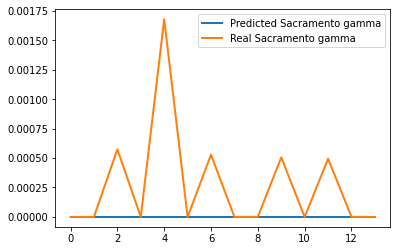

In [114]:
x = range(valid_l)
y1 = mlp1dg_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

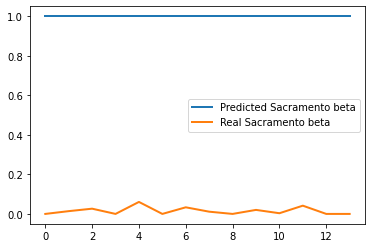

In [115]:
x = range(valid_l)
y1 = mlp1dg_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

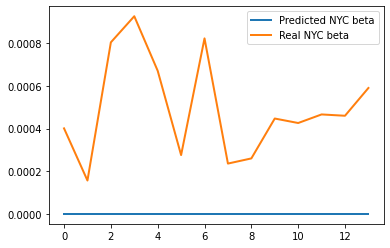

In [116]:
x = range(valid_l)
y1 = mlp1dg_validp_gamma_NYC
y2 = valid_gamma_NYC
plt.plot(x, y1, ls="-", lw=2, label="Predicted NYC beta")
plt.plot(x, y2, ls="-", lw=2, label="Real NYC beta")
plt.legend()
plt.show()

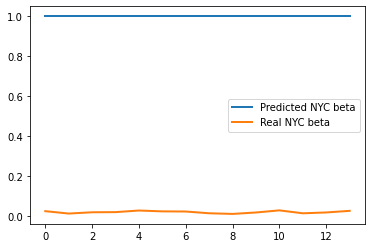

In [117]:
x = range(valid_l)
y1 = mlp1dg_validp_beta_NYC
y2 = valid_beta_NYC
plt.plot(x, y1, ls="-", lw=2, label="Predicted NYC beta")
plt.plot(x, y2, ls="-", lw=2, label="Real NYC beta")
plt.legend()
plt.show()

## MLP - SIR (loss = beta)

In [119]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 5000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        loss = th.mean(th.abs((train_labels_beta_1d[idx] - vals[:,1])))
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(th.abs(valid_labels_beta_1d[idx] - eval_vals[:,1]))
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(th.abs(test_labels_beta_1d[idx] - test_vals[:,1]))
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={}, validation loss = {}, test loss={}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=0.5434439182281494, validation loss = 0.6378679275512695, test loss=0.6441681981086731, test mse = 14484915.000, test mae = 709.780
epoch=1, loss=0.5412108302116394, validation loss = 0.6351361274719238, test loss=0.6406487822532654, test mse = 14456752.000, test mae = 706.329
epoch=2, loss=0.5387184619903564, validation loss = 0.632215142250061, test loss=0.6367899179458618, test mse = 14166343.000, test mae = 698.076
epoch=3, loss=0.5361136198043823, validation loss = 0.6291799545288086, test loss=0.6328616738319397, test mse = 14116735.000, test mae = 693.657
epoch=4, loss=0.5334656238555908, validation loss = 0.626042366027832, test loss=0.62885582447052, test mse = 14087391.000, test mae = 690.146
epoch=5, loss=0.5307945609092712, validation loss = 0.6227861642837524, test loss=0.6247641444206238, test mse = 14080415.000, test mae = 687.331
epoch=6, loss=0.528125524520874, validation loss = 0.6194082498550415, test loss=0.6205570101737976, test mse = 14

epoch=57, loss=0.4086916744709015, validation loss = 0.36211660504341125, test loss=0.33508411049842834, test mse = 7516.935, test mae = 25.732
epoch=58, loss=0.40773606300354004, validation loss = 0.3602781295776367, test loss=0.3331424295902252, test mse = 7476.927, test mae = 25.266
epoch=59, loss=0.4068009555339813, validation loss = 0.35849282145500183, test loss=0.3312600255012512, test mse = 7440.856, test mae = 24.828
epoch=60, loss=0.4058854579925537, validation loss = 0.35675424337387085, test loss=0.3294296860694885, test mse = 7408.189, test mae = 24.412
epoch=61, loss=0.4049862027168274, validation loss = 0.355056494474411, test loss=0.3276449143886566, test mse = 7378.485, test mae = 24.017
epoch=62, loss=0.4041021466255188, validation loss = 0.353397399187088, test loss=0.3259030878543854, test mse = 7351.423, test mae = 23.643
epoch=63, loss=0.40323272347450256, validation loss = 0.3517756164073944, test loss=0.32420262694358826, test mse = 7326.747, test mae = 23.286
e

epoch=115, loss=0.37079137563705444, validation loss = 0.29655030369758606, test loss=0.2676342725753784, test mse = 7099.375, test mae = 16.194
epoch=116, loss=0.37030941247940063, validation loss = 0.2957938611507416, test loss=0.2668754756450653, test mse = 7101.296, test mae = 16.167
epoch=117, loss=0.36983075737953186, validation loss = 0.2950443923473358, test loss=0.2661239802837372, test mse = 7103.296, test mae = 16.142
epoch=118, loss=0.3693554103374481, validation loss = 0.29430174827575684, test loss=0.2653796076774597, test mse = 7105.370, test mae = 16.120
epoch=119, loss=0.36888328194618225, validation loss = 0.2935657501220703, test loss=0.2646423280239105, test mse = 7107.514, test mae = 16.099
epoch=120, loss=0.36841437220573425, validation loss = 0.2928362488746643, test loss=0.2639119029045105, test mse = 7109.734, test mae = 16.082
epoch=121, loss=0.3679485321044922, validation loss = 0.29211315512657166, test loss=0.26318827271461487, test mse = 7112.027, test mae

epoch=172, loss=0.34746626019477844, validation loss = 0.2617586553096771, test loss=0.2331104427576065, test mse = 7321.918, test mae = 17.934
epoch=173, loss=0.3471161127090454, validation loss = 0.26126179099082947, test loss=0.23262323439121246, test mse = 7328.624, test mae = 18.012
epoch=174, loss=0.3467675447463989, validation loss = 0.26076799631118774, test loss=0.23213909566402435, test mse = 7335.502, test mae = 18.090
epoch=175, loss=0.3464204967021942, validation loss = 0.26027700304985046, test loss=0.2316579520702362, test mse = 7342.565, test mae = 18.169
epoch=176, loss=0.34607502818107605, validation loss = 0.2597889304161072, test loss=0.2311798483133316, test mse = 7349.819, test mae = 18.248
epoch=177, loss=0.34573113918304443, validation loss = 0.25930362939834595, test loss=0.2307046800851822, test mse = 7357.276, test mae = 18.328
epoch=178, loss=0.3453887701034546, validation loss = 0.25882118940353394, test loss=0.23023243248462677, test mse = 7364.946, test m

epoch=229, loss=0.32963916659355164, validation loss = 0.2372911125421524, test loss=0.20933730900287628, test mse = 8280.837, test mae = 23.079
epoch=230, loss=0.32935893535614014, validation loss = 0.23691870272159576, test loss=0.20897945761680603, test mse = 8312.163, test mae = 23.185
epoch=231, loss=0.32907968759536743, validation loss = 0.23654794692993164, test loss=0.20862330496311188, test mse = 8344.091, test mae = 23.292
epoch=232, loss=0.32880139350891113, validation loss = 0.23617875576019287, test loss=0.2082688808441162, test mse = 8376.632, test mae = 23.399
epoch=233, loss=0.328524112701416, validation loss = 0.23581121861934662, test loss=0.20791614055633545, test mse = 8409.804, test mae = 23.507
epoch=234, loss=0.3282477557659149, validation loss = 0.23544523119926453, test loss=0.2075650840997696, test mse = 8443.448, test mae = 23.616
epoch=235, loss=0.32797229290008545, validation loss = 0.235080748796463, test loss=0.20721565186977386, test mse = 8477.705, test

epoch=286, loss=0.3150006830692291, validation loss = 0.21830587089061737, test loss=0.19130714237689972, test mse = 16991.654, test mae = 32.120
epoch=287, loss=0.31476518511772156, validation loss = 0.2180083692073822, test loss=0.19102807343006134, test mse = 17416.809, test mae = 32.399
epoch=288, loss=0.31453031301498413, validation loss = 0.217711940407753, test loss=0.1907500922679901, test mse = 17910.662, test mae = 32.690
epoch=289, loss=0.31429603695869446, validation loss = 0.21741655468940735, test loss=0.19047322869300842, test mse = 18476.941, test mae = 32.992
epoch=290, loss=0.3140624463558197, validation loss = 0.21712224185466766, test loss=0.19019745290279388, test mse = 19116.566, test mae = 33.307
epoch=291, loss=0.3138294816017151, validation loss = 0.21682898700237274, test loss=0.1899227797985077, test mse = 19831.090, test mae = 33.634
epoch=292, loss=0.313597172498703, validation loss = 0.21653680503368378, test loss=0.18964920938014984, test mse = 20626.832,

epoch=342, loss=0.3027293384075165, validation loss = 0.2031288892030716, test loss=0.1772032231092453, test mse = 795921.938, test mae = 78.105
epoch=343, loss=0.30252525210380554, validation loss = 0.2028820812702179, test loss=0.17697620391845703, test mse = 801370.375, test mae = 78.939
epoch=344, loss=0.30232158303260803, validation loss = 0.2026360034942627, test loss=0.17674991488456726, test mse = 808081.875, test mae = 79.793
epoch=345, loss=0.3021184206008911, validation loss = 0.20239071547985077, test loss=0.17652443051338196, test mse = 815913.188, test mae = 80.642
epoch=346, loss=0.30191570520401, validation loss = 0.20214620232582092, test loss=0.17629969120025635, test mse = 823314.312, test mae = 81.461
epoch=347, loss=0.3017134666442871, validation loss = 0.2019023895263672, test loss=0.1760757714509964, test mse = 829273.312, test mae = 82.248
epoch=348, loss=0.30151164531707764, validation loss = 0.20165935158729553, test loss=0.17585253715515137, test mse = 834049

epoch=398, loss=0.29197704792022705, validation loss = 0.1903902143239975, test loss=0.16558293998241425, test mse = 1211096.750, test mae = 134.218
epoch=399, loss=0.29179662466049194, validation loss = 0.19018132984638214, test loss=0.16539406776428223, test mse = 1218313.250, test mae = 135.577
epoch=400, loss=0.2916165590286255, validation loss = 0.18997310101985931, test loss=0.16520576179027557, test mse = 1226031.000, test mae = 137.037
epoch=401, loss=0.2914368808269501, validation loss = 0.18976542353630066, test loss=0.16501808166503906, test mse = 1236384.750, test mae = 138.673
epoch=402, loss=0.2912575900554657, validation loss = 0.18955837190151215, test loss=0.1648310124874115, test mse = 1255034.125, test mae = 140.535
epoch=403, loss=0.29107868671417236, validation loss = 0.18935193121433258, test loss=0.1646445095539093, test mse = 1279842.000, test mae = 142.479
epoch=404, loss=0.2909000813961029, validation loss = 0.18914608657360077, test loss=0.16445863246917725, 

epoch=454, loss=0.2824382781982422, validation loss = 0.17961524426937103, test loss=0.15590593218803406, test mse = 5260252.000, test mae = 274.604
epoch=455, loss=0.2822784185409546, validation loss = 0.1794397532939911, test loss=0.1557496339082718, test mse = 5324245.500, test mae = 276.620
epoch=456, loss=0.28211888670921326, validation loss = 0.1792648583650589, test loss=0.1555938869714737, test mse = 5339728.000, test mae = 278.318
epoch=457, loss=0.2819597125053406, validation loss = 0.1790904998779297, test loss=0.15543870627880096, test mse = 5352293.000, test mae = 279.957
epoch=458, loss=0.28180089592933655, validation loss = 0.17891673743724823, test loss=0.15528404712677002, test mse = 5363118.500, test mae = 281.532
epoch=459, loss=0.28164246678352356, validation loss = 0.17874352633953094, test loss=0.15513001382350922, test mse = 5371640.000, test mae = 283.055
epoch=460, loss=0.28148436546325684, validation loss = 0.178570955991745, test loss=0.1549765020608902, test

epoch=510, loss=0.27397358417510986, validation loss = 0.1705542802810669, test loss=0.14788506925106049, test mse = 5912405.000, test mae = 399.787
epoch=511, loss=0.27383020520210266, validation loss = 0.1704041063785553, test loss=0.14775289595127106, test mse = 5935815.500, test mae = 403.949
epoch=512, loss=0.2736869752407074, validation loss = 0.17025433480739594, test loss=0.1476210653781891, test mse = 5960995.000, test mae = 408.442
epoch=513, loss=0.27354398369789124, validation loss = 0.17010483145713806, test loss=0.1474895179271698, test mse = 5989865.500, test mae = 413.428
epoch=514, loss=0.2734012305736542, validation loss = 0.16995568573474884, test loss=0.14735829830169678, test mse = 6026373.000, test mae = 419.091
epoch=515, loss=0.27325868606567383, validation loss = 0.1698068529367447, test loss=0.14722736179828644, test mse = 6076859.500, test mae = 425.506
epoch=516, loss=0.2731163203716278, validation loss = 0.1696583330631256, test loss=0.14709673821926117, te

epoch=565, loss=0.26637765765190125, validation loss = 0.16274957358837128, test loss=0.1410418003797531, test mse = 16029783.000, test mae = 763.223
epoch=566, loss=0.2662445604801178, validation loss = 0.16261562705039978, test loss=0.14092475175857544, test mse = 16030360.000, test mae = 763.597
epoch=567, loss=0.2661116421222687, validation loss = 0.16248191893100739, test loss=0.14080795645713806, test mse = 16030909.000, test mae = 763.960
epoch=568, loss=0.2659788727760315, validation loss = 0.16234849393367767, test loss=0.14069141447544098, test mse = 16031431.000, test mae = 764.313
epoch=569, loss=0.26584628224372864, validation loss = 0.16221533715724945, test loss=0.1405750960111618, test mse = 16031927.000, test mae = 764.657
epoch=570, loss=0.2657139003276825, validation loss = 0.16208244860172272, test loss=0.1404590606689453, test mse = 16032402.000, test mae = 764.990
epoch=571, loss=0.26558172702789307, validation loss = 0.16194985806941986, test loss=0.1403432637453

epoch=620, loss=0.25929921865463257, validation loss = 0.15574610233306885, test loss=0.1349395215511322, test mse = 16043176.000, test mae = 775.247
epoch=621, loss=0.25917473435401917, validation loss = 0.15562523901462555, test loss=0.13483445346355438, test mse = 16043280.000, test mae = 775.382
epoch=622, loss=0.2590503692626953, validation loss = 0.15550456941127777, test loss=0.13472959399223328, test mse = 16043379.000, test mae = 775.515
epoch=623, loss=0.2589261829853058, validation loss = 0.1553841531276703, test loss=0.13462494313716888, test mse = 16043478.000, test mae = 775.646
epoch=624, loss=0.25880205631256104, validation loss = 0.15526390075683594, test loss=0.13452047109603882, test mse = 16043575.000, test mae = 775.776
epoch=625, loss=0.2586781084537506, validation loss = 0.15514390170574188, test loss=0.13441620767116547, test mse = 16043669.000, test mae = 775.904
epoch=626, loss=0.2585543394088745, validation loss = 0.15502412617206573, test loss=0.134312108159

epoch=675, loss=0.25264406204223633, validation loss = 0.14939935505390167, test loss=0.12943395972251892, test mse = 16046535.000, test mae = 780.418
epoch=676, loss=0.25252676010131836, validation loss = 0.14928960800170898, test loss=0.12933889031410217, test mse = 16046570.000, test mae = 780.483
epoch=677, loss=0.25240957736968994, validation loss = 0.14918005466461182, test loss=0.12924395501613617, test mse = 16046606.000, test mae = 780.547
epoch=678, loss=0.2522925138473511, validation loss = 0.14907069504261017, test loss=0.1291491836309433, test mse = 16046640.000, test mae = 780.611
epoch=679, loss=0.25217553973197937, validation loss = 0.14896151423454285, test loss=0.12905460596084595, test mse = 16046674.000, test mae = 780.674
epoch=680, loss=0.2520586848258972, validation loss = 0.14885251224040985, test loss=0.12896017730236053, test mse = 16046707.000, test mae = 780.736
epoch=681, loss=0.2519420087337494, validation loss = 0.14874370396137238, test loss=0.1288659274

epoch=730, loss=0.24637416005134583, validation loss = 0.14364345371723175, test loss=0.12445322424173355, test mse = 16047993.000, test mae = 783.360
epoch=731, loss=0.24626360833644867, validation loss = 0.14354395866394043, test loss=0.12436722964048386, test mse = 16048013.000, test mae = 783.405
epoch=732, loss=0.24615314602851868, validation loss = 0.14344462752342224, test loss=0.12428135424852371, test mse = 16048031.000, test mae = 783.449
epoch=733, loss=0.24604283273220062, validation loss = 0.143345445394516, test loss=0.1241956502199173, test mse = 16048049.000, test mae = 783.493
epoch=734, loss=0.24593260884284973, validation loss = 0.14324642717838287, test loss=0.12411006540060043, test mse = 16048071.000, test mae = 783.537
epoch=735, loss=0.2458225041627884, validation loss = 0.14314758777618408, test loss=0.12402466684579849, test mse = 16048091.000, test mae = 783.580
epoch=736, loss=0.245712548494339, validation loss = 0.143048956990242, test loss=0.12393938004970

epoch=785, loss=0.24044816195964813, validation loss = 0.13839761912822723, test loss=0.11992402374744415, test mse = 16048864.000, test mae = 785.474
epoch=786, loss=0.2403431534767151, validation loss = 0.13830621540546417, test loss=0.11984521895647049, test mse = 16048875.000, test mae = 785.507
epoch=787, loss=0.24023818969726562, validation loss = 0.13821497559547424, test loss=0.11976652592420578, test mse = 16048888.000, test mae = 785.540
epoch=788, loss=0.2401333600282669, validation loss = 0.13812382519245148, test loss=0.11968796700239182, test mse = 16048901.000, test mae = 785.573
epoch=789, loss=0.24002858996391296, validation loss = 0.13803283870220184, test loss=0.11960949748754501, test mse = 16048913.000, test mae = 785.605
epoch=790, loss=0.23992392420768738, validation loss = 0.13794198632240295, test loss=0.11953116953372955, test mse = 16048926.000, test mae = 785.638
epoch=791, loss=0.23981934785842896, validation loss = 0.1378512680530548, test loss=0.119452968

epoch=840, loss=0.23480743169784546, validation loss = 0.1335592120885849, test loss=0.11575702577829361, test mse = 16049430.000, test mae = 787.075
epoch=841, loss=0.23470719158649445, validation loss = 0.13347455859184265, test loss=0.11568417400121689, test mse = 16049439.000, test mae = 787.099
epoch=842, loss=0.2346070557832718, validation loss = 0.13339005410671234, test loss=0.11561144888401031, test mse = 16049446.000, test mae = 787.123
epoch=843, loss=0.2345069795846939, validation loss = 0.13330566883087158, test loss=0.1155388355255127, test mse = 16049455.000, test mae = 787.148
epoch=844, loss=0.23440700769424438, validation loss = 0.13322137296199799, test loss=0.11546631157398224, test mse = 16049462.000, test mae = 787.172
epoch=845, loss=0.23430708050727844, validation loss = 0.13313721120357513, test loss=0.11539391428232193, test mse = 16049471.000, test mae = 787.195
epoch=846, loss=0.23420725762844086, validation loss = 0.13305319845676422, test loss=0.1153215840

epoch=895, loss=0.22941558063030243, validation loss = 0.12908001244068146, test loss=0.11190254241228104, test mse = 16049783.000, test mae = 788.211
epoch=896, loss=0.22931978106498718, validation loss = 0.12900175154209137, test loss=0.11183525621891022, test mse = 16049787.000, test mae = 788.229
epoch=897, loss=0.2292240411043167, validation loss = 0.12892360985279083, test loss=0.11176806688308716, test mse = 16049792.000, test mae = 788.247
epoch=898, loss=0.2291283905506134, validation loss = 0.12884555757045746, test loss=0.11170095950365067, test mse = 16049795.000, test mae = 788.265
epoch=899, loss=0.22903281450271606, validation loss = 0.12876762449741364, test loss=0.11163394153118134, test mse = 16049802.000, test mae = 788.283
epoch=900, loss=0.2289373129606247, validation loss = 0.12868981063365936, test loss=0.11156703531742096, test mse = 16049807.000, test mae = 788.300
epoch=901, loss=0.2288418859243393, validation loss = 0.12861208617687225, test loss=0.1115002259

epoch=950, loss=0.22425058484077454, validation loss = 0.12492059916257858, test loss=0.10833074897527695, test mse = 16050038.000, test mae = 789.122
epoch=951, loss=0.22415822744369507, validation loss = 0.12484737485647202, test loss=0.10826796293258667, test mse = 16050041.000, test mae = 789.137
epoch=952, loss=0.22406594455242157, validation loss = 0.12477421015501022, test loss=0.10820521414279938, test mse = 16050043.000, test mae = 789.152
epoch=953, loss=0.22397372126579285, validation loss = 0.12470114231109619, test loss=0.10814256221055984, test mse = 16050049.000, test mae = 789.167
epoch=954, loss=0.2238815575838089, validation loss = 0.12462813407182693, test loss=0.10807996243238449, test mse = 16050055.000, test mae = 789.183
epoch=955, loss=0.22378942370414734, validation loss = 0.12455518543720245, test loss=0.10801742970943451, test mse = 16050057.000, test mae = 789.198
epoch=956, loss=0.22369734942913055, validation loss = 0.12448234856128693, test loss=0.1079549

epoch=1005, loss=0.2192513346672058, validation loss = 0.12099847942590714, test loss=0.10497152805328369, test mse = 16050242.000, test mae = 789.932
epoch=1006, loss=0.21916180849075317, validation loss = 0.12092895060777664, test loss=0.10491209477186203, test mse = 16050246.000, test mae = 789.947
epoch=1007, loss=0.21907232701778412, validation loss = 0.12085948139429092, test loss=0.10485268384218216, test mse = 16050249.000, test mae = 789.961
epoch=1008, loss=0.21898290514945984, validation loss = 0.12079007178544998, test loss=0.10479335486888885, test mse = 16050255.000, test mae = 789.976
epoch=1009, loss=0.21889351308345795, validation loss = 0.12072070688009262, test loss=0.10473404824733734, test mse = 16050257.000, test mae = 789.990
epoch=1010, loss=0.21880415081977844, validation loss = 0.12065140902996063, test loss=0.10467479377985, test mse = 16050261.000, test mae = 790.005
epoch=1011, loss=0.21871481835842133, validation loss = 0.12058214098215103, test loss=0.104

epoch=1060, loss=0.21438482403755188, validation loss = 0.11725451052188873, test loss=0.10177407413721085, test mse = 16050430.000, test mae = 790.722
epoch=1061, loss=0.21429723501205444, validation loss = 0.11718779802322388, test loss=0.10171718895435333, test mse = 16050434.000, test mae = 790.736
epoch=1062, loss=0.2142096906900406, validation loss = 0.117121122777462, test loss=0.10166035592556, test mse = 16050438.000, test mae = 790.750
epoch=1063, loss=0.21412219107151031, validation loss = 0.1170545220375061, test loss=0.10160358250141144, test mse = 16050441.000, test mae = 790.764
epoch=1064, loss=0.21403473615646362, validation loss = 0.11698796600103378, test loss=0.10154684633016586, test mse = 16050443.000, test mae = 790.778
epoch=1065, loss=0.2139473557472229, validation loss = 0.11692146956920624, test loss=0.10149017721414566, test mse = 16050447.000, test mae = 790.792
epoch=1066, loss=0.21385997533798218, validation loss = 0.11685501784086227, test loss=0.1014335

epoch=1115, loss=0.20962417125701904, validation loss = 0.11365245282649994, test loss=0.09870888292789459, test mse = 16050592.000, test mae = 791.456
epoch=1116, loss=0.2095385640859604, validation loss = 0.11358816176652908, test loss=0.09865429252386093, test mse = 16050594.000, test mae = 791.469
epoch=1117, loss=0.20945300161838531, validation loss = 0.1135239377617836, test loss=0.09859973937273026, test mse = 16050597.000, test mae = 791.481
epoch=1118, loss=0.20936745405197144, validation loss = 0.11345972120761871, test loss=0.09854523092508316, test mse = 16050600.000, test mae = 791.493
epoch=1119, loss=0.20928198099136353, validation loss = 0.1133955717086792, test loss=0.09849073737859726, test mse = 16050602.000, test mae = 791.506
epoch=1120, loss=0.20919649302959442, validation loss = 0.11333143711090088, test loss=0.09843628853559494, test mse = 16050606.000, test mae = 791.518
epoch=1121, loss=0.2091110348701477, validation loss = 0.11326732486486435, test loss=0.098

epoch=1170, loss=0.2049521654844284, validation loss = 0.11016952991485596, test loss=0.09575749933719635, test mse = 16050718.000, test mae = 792.085
epoch=1171, loss=0.2048674374818802, validation loss = 0.11010706424713135, test loss=0.09570471197366714, test mse = 16050720.000, test mae = 792.096
epoch=1172, loss=0.20478278398513794, validation loss = 0.11004465073347092, test loss=0.09565193951129913, test mse = 16050721.000, test mae = 792.106
epoch=1173, loss=0.2046981155872345, validation loss = 0.10998226702213287, test loss=0.0955992117524147, test mse = 16050726.000, test mae = 792.116
epoch=1174, loss=0.20461349189281464, validation loss = 0.1099199503660202, test loss=0.09554652869701385, test mse = 16050727.000, test mae = 792.127
epoch=1175, loss=0.20452888309955597, validation loss = 0.10985766351222992, test loss=0.09549389034509659, test mse = 16050729.000, test mae = 792.137
epoch=1176, loss=0.20444433391094208, validation loss = 0.10979542881250381, test loss=0.0954

epoch=1225, loss=0.20033471286296844, validation loss = 0.10679219663143158, test loss=0.09290797263383865, test mse = 16050818.000, test mae = 792.617
epoch=1226, loss=0.20025144517421722, validation loss = 0.10673178732395172, test loss=0.09285711497068405, test mse = 16050821.000, test mae = 792.626
epoch=1227, loss=0.200168177485466, validation loss = 0.10667141526937485, test loss=0.09280628710985184, test mse = 16050821.000, test mae = 792.635
epoch=1228, loss=0.20008496940135956, validation loss = 0.10661109536886215, test loss=0.09275549650192261, test mse = 16050824.000, test mae = 792.644
epoch=1229, loss=0.2000017762184143, validation loss = 0.10655080527067184, test loss=0.09270475804805756, test mse = 16050824.000, test mae = 792.653
epoch=1230, loss=0.19991858303546906, validation loss = 0.10649055987596512, test loss=0.0926540270447731, test mse = 16050825.000, test mae = 792.661
epoch=1231, loss=0.19983544945716858, validation loss = 0.10643032938241959, test loss=0.092

epoch=1280, loss=0.19578617811203003, validation loss = 0.103522889316082, test loss=0.0901600793004036, test mse = 16050895.000, test mae = 793.073
epoch=1281, loss=0.1957041621208191, validation loss = 0.10346448421478271, test loss=0.09011107683181763, test mse = 16050897.000, test mae = 793.080
epoch=1282, loss=0.19562220573425293, validation loss = 0.10340609401464462, test loss=0.09006208181381226, test mse = 16050899.000, test mae = 793.088
epoch=1283, loss=0.19554024934768677, validation loss = 0.10334773361682892, test loss=0.09001313894987106, test mse = 16050902.000, test mae = 793.096
epoch=1284, loss=0.1954583078622818, validation loss = 0.1032894030213356, test loss=0.08996421098709106, test mse = 16050902.000, test mae = 793.104
epoch=1285, loss=0.19537639617919922, validation loss = 0.10323110967874527, test loss=0.08991532027721405, test mse = 16050903.000, test mae = 793.111
epoch=1286, loss=0.19529448449611664, validation loss = 0.10317283123731613, test loss=0.08986

epoch=1335, loss=0.19130700826644897, validation loss = 0.10035976022481918, test loss=0.08751107007265091, test mse = 16050960.000, test mae = 793.479
epoch=1336, loss=0.19122613966464996, validation loss = 0.10030318051576614, test loss=0.08746377378702164, test mse = 16050961.000, test mae = 793.486
epoch=1337, loss=0.19114527106285095, validation loss = 0.1002466231584549, test loss=0.08741650730371475, test mse = 16050963.000, test mae = 793.493
epoch=1338, loss=0.19106443226337433, validation loss = 0.10019008070230484, test loss=0.08736924082040787, test mse = 16050963.000, test mae = 793.499
epoch=1339, loss=0.1909835934638977, validation loss = 0.10013356059789658, test loss=0.08732200413942337, test mse = 16050966.000, test mae = 793.506
epoch=1340, loss=0.19090276956558228, validation loss = 0.10007704049348831, test loss=0.08727479726076126, test mse = 16050966.000, test mae = 793.513
epoch=1341, loss=0.19082194566726685, validation loss = 0.10002055019140244, test loss=0.0

epoch=1390, loss=0.18687504529953003, validation loss = 0.09728329628705978, test loss=0.08494573831558228, test mse = 16051015.000, test mae = 793.843
epoch=1391, loss=0.18679481744766235, validation loss = 0.09722805768251419, test loss=0.08489979803562164, test mse = 16051015.000, test mae = 793.849
epoch=1392, loss=0.18671458959579468, validation loss = 0.09717284888029099, test loss=0.0848538726568222, test mse = 16051015.000, test mae = 793.856
epoch=1393, loss=0.1866343766450882, validation loss = 0.09711766988039017, test loss=0.08480797708034515, test mse = 16051018.000, test mae = 793.862
epoch=1394, loss=0.1865541934967041, validation loss = 0.09706251323223114, test loss=0.08476211130619049, test mse = 16051018.000, test mae = 793.868
epoch=1395, loss=0.1864740252494812, validation loss = 0.0970073938369751, test loss=0.08471627533435822, test mse = 16051019.000, test mae = 793.874
epoch=1396, loss=0.1863938719034195, validation loss = 0.09695230424404144, test loss=0.08467

epoch=1445, loss=0.18248839676380157, validation loss = 0.09429218620061874, test loss=0.08246135711669922, test mse = 16051059.000, test mae = 794.167
epoch=1446, loss=0.18240919709205627, validation loss = 0.09423872083425522, test loss=0.08241701126098633, test mse = 16051059.000, test mae = 794.172
epoch=1447, loss=0.18232999742031097, validation loss = 0.09418529272079468, test loss=0.08237268775701523, test mse = 16051059.000, test mae = 794.178
epoch=1448, loss=0.18225085735321045, validation loss = 0.09413192421197891, test loss=0.0823284238576889, test mse = 16051061.000, test mae = 794.183
epoch=1449, loss=0.1821717470884323, validation loss = 0.09407860040664673, test loss=0.08228419721126556, test mse = 16051063.000, test mae = 794.189
epoch=1450, loss=0.18209265172481537, validation loss = 0.09402533620595932, test loss=0.08224000781774521, test mse = 16051064.000, test mae = 794.194
epoch=1451, loss=0.18201357126235962, validation loss = 0.0939720943570137, test loss=0.08

epoch=1500, loss=0.1781657338142395, validation loss = 0.09140199422836304, test loss=0.08006703853607178, test mse = 16051097.000, test mae = 794.453
epoch=1501, loss=0.17808754742145538, validation loss = 0.09135022014379501, test loss=0.08002424240112305, test mse = 16051099.000, test mae = 794.457
epoch=1502, loss=0.17800942063331604, validation loss = 0.09129846841096878, test loss=0.07998144626617432, test mse = 16051099.000, test mae = 794.462
epoch=1503, loss=0.1779312789440155, validation loss = 0.09124674648046494, test loss=0.07993867248296738, test mse = 16051099.000, test mae = 794.467
epoch=1504, loss=0.17785316705703735, validation loss = 0.09119504690170288, test loss=0.07989595085382462, test mse = 16051101.000, test mae = 794.472
epoch=1505, loss=0.1777750700712204, validation loss = 0.09114338457584381, test loss=0.07985322922468185, test mse = 16051102.000, test mae = 794.477
epoch=1506, loss=0.17769698798656464, validation loss = 0.09109174460172653, test loss=0.07

epoch=1555, loss=0.1738864779472351, validation loss = 0.08859195560216904, test loss=0.07774795591831207, test mse = 16051130.000, test mae = 794.706
epoch=1556, loss=0.1738089770078659, validation loss = 0.08854150027036667, test loss=0.07770641148090363, test mse = 16051130.000, test mae = 794.710
epoch=1557, loss=0.1737315058708191, validation loss = 0.08849108964204788, test loss=0.07766490429639816, test mse = 16051131.000, test mae = 794.715
epoch=1558, loss=0.17365407943725586, validation loss = 0.0884406790137291, test loss=0.0776234045624733, test mse = 16051131.000, test mae = 794.719
epoch=1559, loss=0.17357666790485382, validation loss = 0.0883903056383133, test loss=0.07758193463087082, test mse = 16051131.000, test mae = 794.723
epoch=1560, loss=0.17349928617477417, validation loss = 0.08833996951580048, test loss=0.07754050195217133, test mse = 16051133.000, test mae = 794.728
epoch=1561, loss=0.17342190444469452, validation loss = 0.08828964084386826, test loss=0.07749

epoch=1610, loss=0.16965287923812866, validation loss = 0.08585689961910248, test loss=0.07550022751092911, test mse = 16051158.000, test mae = 794.933
epoch=1611, loss=0.16957636177539825, validation loss = 0.08580787479877472, test loss=0.07546001672744751, test mse = 16051158.000, test mae = 794.937
epoch=1612, loss=0.16949984431266785, validation loss = 0.08575888723134995, test loss=0.0754198506474495, test mse = 16051158.000, test mae = 794.941
epoch=1613, loss=0.16942337155342102, validation loss = 0.08570992946624756, test loss=0.07537969201803207, test mse = 16051159.000, test mae = 794.945
epoch=1614, loss=0.169346883893013, validation loss = 0.08566099405288696, test loss=0.07533957064151764, test mse = 16051159.000, test mae = 794.949
epoch=1615, loss=0.16927044093608856, validation loss = 0.08561206609010696, test loss=0.0752994641661644, test mse = 16051159.000, test mae = 794.953
epoch=1616, loss=0.16919398307800293, validation loss = 0.08556317538022995, test loss=0.075

epoch=1665, loss=0.16546574234962463, validation loss = 0.08319497108459473, test loss=0.07332171499729156, test mse = 16051179.000, test mae = 795.138
epoch=1666, loss=0.1653900444507599, validation loss = 0.08314720541238785, test loss=0.07328271120786667, test mse = 16051181.000, test mae = 795.141
epoch=1667, loss=0.16531433165073395, validation loss = 0.08309944719076157, test loss=0.07324372231960297, test mse = 16051181.000, test mae = 795.145
epoch=1668, loss=0.16523867845535278, validation loss = 0.08305174112319946, test loss=0.07320476323366165, test mse = 16051181.000, test mae = 795.148
epoch=1669, loss=0.16516301035881042, validation loss = 0.08300403505563736, test loss=0.07316581904888153, test mse = 16051181.000, test mae = 795.152
epoch=1670, loss=0.16508735716342926, validation loss = 0.08295635133981705, test loss=0.0731269046664238, test mse = 16051181.000, test mae = 795.155
epoch=1671, loss=0.16501174867153168, validation loss = 0.08290869742631912, test loss=0.0

epoch=1720, loss=0.16132548451423645, validation loss = 0.08060252666473389, test loss=0.07120897620916367, test mse = 16051201.000, test mae = 795.323
epoch=1721, loss=0.1612502783536911, validation loss = 0.08055590838193893, test loss=0.07117108255624771, test mse = 16051201.000, test mae = 795.326
epoch=1722, loss=0.16117508709430695, validation loss = 0.08050932735204697, test loss=0.07113321870565414, test mse = 16051201.000, test mae = 795.329
epoch=1723, loss=0.16109991073608398, validation loss = 0.080462746322155, test loss=0.07109536230564117, test mse = 16051201.000, test mae = 795.332
epoch=1724, loss=0.1610247790813446, validation loss = 0.08041620999574661, test loss=0.07105753570795059, test mse = 16051202.000, test mae = 795.335
epoch=1725, loss=0.16094964742660522, validation loss = 0.08036968857049942, test loss=0.0710197240114212, test mse = 16051202.000, test mae = 795.339
epoch=1726, loss=0.16087453067302704, validation loss = 0.08032319694757462, test loss=0.0709

epoch=1775, loss=0.15721341967582703, validation loss = 0.07807141542434692, test loss=0.06915614753961563, test mse = 16051221.000, test mae = 795.492
epoch=1776, loss=0.15713924169540405, validation loss = 0.07802609354257584, test loss=0.06911946833133698, test mse = 16051221.000, test mae = 795.495
epoch=1777, loss=0.15706506371498108, validation loss = 0.07798077911138535, test loss=0.06908280402421951, test mse = 16051221.000, test mae = 795.498
epoch=1778, loss=0.1569909155368805, validation loss = 0.07793549448251724, test loss=0.06904616206884384, test mse = 16051221.000, test mae = 795.500
epoch=1779, loss=0.1569167822599411, validation loss = 0.07789022475481033, test loss=0.06900954246520996, test mse = 16051221.000, test mae = 795.503
epoch=1780, loss=0.1568426489830017, validation loss = 0.07784498482942581, test loss=0.06897295266389847, test mse = 16051221.000, test mae = 795.506
epoch=1781, loss=0.15676851570606232, validation loss = 0.07779977470636368, test loss=0.06

epoch=1830, loss=0.15315768122673035, validation loss = 0.07561248540878296, test loss=0.0671704113483429, test mse = 16051235.000, test mae = 795.647
epoch=1831, loss=0.15308433771133423, validation loss = 0.07556837797164917, test loss=0.06713486462831497, test mse = 16051235.000, test mae = 795.650
epoch=1832, loss=0.1530110239982605, validation loss = 0.07552429288625717, test loss=0.06709935516119003, test mse = 16051235.000, test mae = 795.653
epoch=1833, loss=0.15293771028518677, validation loss = 0.07548023015260696, test loss=0.06706385314464569, test mse = 16051235.000, test mae = 795.656
epoch=1834, loss=0.15286442637443542, validation loss = 0.07543618977069855, test loss=0.06702838093042374, test mse = 16051237.000, test mae = 795.658
epoch=1835, loss=0.15279115736484528, validation loss = 0.07539217919111252, test loss=0.06699292361736298, test mse = 16051237.000, test mae = 795.661
epoch=1836, loss=0.15271791815757751, validation loss = 0.07534818351268768, test loss=0.0

epoch=1885, loss=0.14914992451667786, validation loss = 0.0732191875576973, test loss=0.06524624675512314, test mse = 16051249.000, test mae = 795.792
epoch=1886, loss=0.14907753467559814, validation loss = 0.073176309466362, test loss=0.06521185487508774, test mse = 16051250.000, test mae = 795.795
epoch=1887, loss=0.14900517463684082, validation loss = 0.0731334537267685, test loss=0.06517747789621353, test mse = 16051250.000, test mae = 795.797
epoch=1888, loss=0.1489328294992447, validation loss = 0.07309061288833618, test loss=0.06514312326908112, test mse = 16051250.000, test mae = 795.800
epoch=1889, loss=0.14886051416397095, validation loss = 0.07304780185222626, test loss=0.06510879099369049, test mse = 16051250.000, test mae = 795.803
epoch=1890, loss=0.1487881988286972, validation loss = 0.07300500571727753, test loss=0.06507447361946106, test mse = 16051250.000, test mae = 795.805
epoch=1891, loss=0.14871591329574585, validation loss = 0.07296223193407059, test loss=0.06504

epoch=1940, loss=0.1451987475156784, validation loss = 0.07089444249868393, test loss=0.06338565051555634, test mse = 16051263.000, test mae = 795.929
epoch=1941, loss=0.14512747526168823, validation loss = 0.07085279375314713, test loss=0.06335239857435226, test mse = 16051263.000, test mae = 795.932
epoch=1942, loss=0.14505624771118164, validation loss = 0.07081115990877151, test loss=0.06331916898488998, test mse = 16051263.000, test mae = 795.934
epoch=1943, loss=0.14498502016067505, validation loss = 0.07076956331729889, test loss=0.0632859542965889, test mse = 16051263.000, test mae = 795.936
epoch=1944, loss=0.14491380751132965, validation loss = 0.07072798907756805, test loss=0.0632527694106102, test mse = 16051263.000, test mae = 795.939
epoch=1945, loss=0.14484260976314545, validation loss = 0.07068643718957901, test loss=0.0632195994257927, test mse = 16051264.000, test mae = 795.941
epoch=1946, loss=0.14477144181728363, validation loss = 0.07064489275217056, test loss=0.063

epoch=1995, loss=0.14129947125911713, validation loss = 0.06863139569759369, test loss=0.061583202332258224, test mse = 16051274.000, test mae = 796.059
epoch=1996, loss=0.14122898876667023, validation loss = 0.06859077513217926, test loss=0.06155092269182205, test mse = 16051274.000, test mae = 796.061
epoch=1997, loss=0.14115852117538452, validation loss = 0.06855016946792603, test loss=0.06151866540312767, test mse = 16051274.000, test mae = 796.063
epoch=1998, loss=0.14108806848526, validation loss = 0.06850958615541458, test loss=0.06148642301559448, test mse = 16051274.000, test mae = 796.065
epoch=1999, loss=0.14101764559745789, validation loss = 0.06846903264522552, test loss=0.06145419925451279, test mse = 16051274.000, test mae = 796.068
epoch=2000, loss=0.14094723761081696, validation loss = 0.06842849403619766, test loss=0.061421990394592285, test mse = 16051274.000, test mae = 796.070
epoch=2001, loss=0.14087684452533722, validation loss = 0.06838797777891159, test loss=0.

epoch=2049, loss=0.13751941919326782, validation loss = 0.06646732240915298, test loss=0.059867389500141144, test mse = 16051287.000, test mae = 796.178
epoch=2050, loss=0.13744990527629852, validation loss = 0.06642778217792511, test loss=0.05983612313866615, test mse = 16051287.000, test mae = 796.181
epoch=2051, loss=0.13738039135932922, validation loss = 0.06638827174901962, test loss=0.05980486422777176, test mse = 16051287.000, test mae = 796.183
epoch=2052, loss=0.13731087744235992, validation loss = 0.06634877622127533, test loss=0.059773631393909454, test mse = 16051287.000, test mae = 796.185
epoch=2053, loss=0.1372414231300354, validation loss = 0.06630931049585342, test loss=0.059742413461208344, test mse = 16051287.000, test mae = 796.187
epoch=2054, loss=0.13717195391654968, validation loss = 0.06626985222101212, test loss=0.059711210429668427, test mse = 16051287.000, test mae = 796.189
epoch=2055, loss=0.13710251450538635, validation loss = 0.0662304237484932, test loss

epoch=2104, loss=0.13373512029647827, validation loss = 0.06432579457759857, test loss=0.05817694589495659, test mse = 16051295.000, test mae = 796.294
epoch=2105, loss=0.13366705179214478, validation loss = 0.06428748369216919, test loss=0.05814677104353905, test mse = 16051295.000, test mae = 796.296
epoch=2106, loss=0.13359898328781128, validation loss = 0.06424915790557861, test loss=0.05811659246683121, test mse = 16051295.000, test mae = 796.298
epoch=2107, loss=0.13353091478347778, validation loss = 0.06421086192131042, test loss=0.05808642879128456, test mse = 16051295.000, test mae = 796.300
epoch=2108, loss=0.13346286118030548, validation loss = 0.06417258083820343, test loss=0.058056291192770004, test mse = 16051295.000, test mae = 796.302
epoch=2109, loss=0.13339482247829437, validation loss = 0.06413432955741882, test loss=0.05802617222070694, test mse = 16051295.000, test mae = 796.304
epoch=2110, loss=0.13332681357860565, validation loss = 0.06409608572721481, test loss=

epoch=2158, loss=0.13008557260036469, validation loss = 0.062284789979457855, test loss=0.056572768837213516, test mse = 16051304.000, test mae = 796.403
epoch=2159, loss=0.13001863658428192, validation loss = 0.06224755570292473, test loss=0.05654358118772507, test mse = 16051304.000, test mae = 796.405
epoch=2160, loss=0.12995171546936035, validation loss = 0.06221034750342369, test loss=0.05651440843939781, test mse = 16051304.000, test mae = 796.407
epoch=2161, loss=0.12988479435443878, validation loss = 0.062173157930374146, test loss=0.05648524686694145, test mse = 16051304.000, test mae = 796.409
epoch=2162, loss=0.1298179030418396, validation loss = 0.06213599443435669, test loss=0.056456100195646286, test mse = 16051304.000, test mae = 796.411
epoch=2163, loss=0.1297510415315628, validation loss = 0.06209883838891983, test loss=0.05642698332667351, test mse = 16051304.000, test mae = 796.413
epoch=2164, loss=0.1296841949224472, validation loss = 0.06206170842051506, test loss=

epoch=2212, loss=0.1265004426240921, validation loss = 0.06030392274260521, test loss=0.05502263456583023, test mse = 16051312.000, test mae = 796.506
epoch=2213, loss=0.12643462419509888, validation loss = 0.060267798602581024, test loss=0.054994430392980576, test mse = 16051314.000, test mae = 796.508
epoch=2214, loss=0.12636883556842804, validation loss = 0.06023170426487923, test loss=0.05496624484658241, test mse = 16051314.000, test mae = 796.510
epoch=2215, loss=0.1263030618429184, validation loss = 0.060195617377758026, test loss=0.05493807792663574, test mse = 16051314.000, test mae = 796.512
epoch=2216, loss=0.12623730301856995, validation loss = 0.060159556567668915, test loss=0.054909925907850266, test mse = 16051314.000, test mae = 796.514
epoch=2217, loss=0.12617157399654388, validation loss = 0.060123510658741, test loss=0.05488178879022598, test mse = 16051314.000, test mae = 796.516
epoch=2218, loss=0.12610585987567902, validation loss = 0.06008749455213547, test loss=

epoch=2266, loss=0.12297643721103668, validation loss = 0.05838167294859886, test loss=0.05352512374520302, test mse = 16051320.000, test mae = 796.603
epoch=2267, loss=0.12291169166564941, validation loss = 0.058346591889858246, test loss=0.053497858345508575, test mse = 16051320.000, test mae = 796.605
epoch=2268, loss=0.12284697592258453, validation loss = 0.05831154063344002, test loss=0.05347061529755592, test mse = 16051320.000, test mae = 796.606
epoch=2269, loss=0.12278231233358383, validation loss = 0.05827651545405388, test loss=0.05344339832663536, test mse = 16051320.000, test mae = 796.608
epoch=2270, loss=0.12271764874458313, validation loss = 0.058241505175828934, test loss=0.05341619998216629, test mse = 16051321.000, test mae = 796.610
epoch=2271, loss=0.1226530373096466, validation loss = 0.05820652097463608, test loss=0.05338902398943901, test mse = 16051321.000, test mae = 796.611
epoch=2272, loss=0.12258843332529068, validation loss = 0.05817156285047531, test loss

epoch=2320, loss=0.11951753497123718, validation loss = 0.05651688203215599, test loss=0.05207899585366249, test mse = 16051328.000, test mae = 796.693
epoch=2321, loss=0.11945411562919617, validation loss = 0.05648287013173103, test loss=0.05205269530415535, test mse = 16051328.000, test mae = 796.694
epoch=2322, loss=0.11939071118831635, validation loss = 0.05644887685775757, test loss=0.05202639102935791, test mse = 16051328.000, test mae = 796.696
epoch=2323, loss=0.11932732164859772, validation loss = 0.05641492083668709, test loss=0.052000124007463455, test mse = 16051328.000, test mae = 796.698
epoch=2324, loss=0.11926396936178207, validation loss = 0.05638096481561661, test loss=0.0519738607108593, test mse = 16051328.000, test mae = 796.699
epoch=2325, loss=0.11920062452554703, validation loss = 0.056347038596868515, test loss=0.05194762349128723, test mse = 16051328.000, test mae = 796.701
epoch=2326, loss=0.11913730204105377, validation loss = 0.05631313472986221, test loss=

epoch=2374, loss=0.11612778156995773, validation loss = 0.05471017584204674, test loss=0.05068409815430641, test mse = 16051333.000, test mae = 796.776
epoch=2375, loss=0.11606571078300476, validation loss = 0.05467730015516281, test loss=0.05065876618027687, test mse = 16051333.000, test mae = 796.778
epoch=2376, loss=0.11600366979837418, validation loss = 0.05464443564414978, test loss=0.050633449107408524, test mse = 16051333.000, test mae = 796.779
epoch=2377, loss=0.11594162881374359, validation loss = 0.05461158975958824, test loss=0.05060814693570137, test mse = 16051333.000, test mae = 796.781
epoch=2378, loss=0.11587962508201599, validation loss = 0.05457876995205879, test loss=0.05058286339044571, test mse = 16051333.000, test mae = 796.782
epoch=2379, loss=0.11581765115261078, validation loss = 0.05454595014452934, test loss=0.050557591021060944, test mse = 16051334.000, test mae = 796.784
epoch=2380, loss=0.11575567722320557, validation loss = 0.05451315641403198, test loss

epoch=2428, loss=0.11281009763479233, validation loss = 0.05295950174331665, test loss=0.049338698387145996, test mse = 16051338.000, test mae = 796.853
epoch=2429, loss=0.11274930834770203, validation loss = 0.05292757228016853, test loss=0.0493142269551754, test mse = 16051338.000, test mae = 796.855
epoch=2430, loss=0.11268854141235352, validation loss = 0.05289565771818161, test loss=0.0492897592484951, test mse = 16051338.000, test mae = 796.856
epoch=2431, loss=0.1126277968287468, validation loss = 0.05286376550793648, test loss=0.04926532134413719, test mse = 16051338.000, test mae = 796.857
epoch=2432, loss=0.11256708204746246, validation loss = 0.05283188447356224, test loss=0.04924088716506958, test mse = 16051338.000, test mae = 796.859
epoch=2433, loss=0.11250637471675873, validation loss = 0.052800025790929794, test loss=0.04921647161245346, test mse = 16051338.000, test mae = 796.860
epoch=2434, loss=0.11244569718837738, validation loss = 0.05276817828416824, test loss=0.

epoch=2482, loss=0.10956031829118729, validation loss = 0.05126148834824562, test loss=0.04803985729813576, test mse = 16051344.000, test mae = 796.924
epoch=2483, loss=0.10950081795454025, validation loss = 0.051230546087026596, test loss=0.048016246408224106, test mse = 16051344.000, test mae = 796.926
epoch=2484, loss=0.1094413697719574, validation loss = 0.05119962617754936, test loss=0.04799265041947365, test mse = 16051344.000, test mae = 796.927
epoch=2485, loss=0.10938194394111633, validation loss = 0.05116872861981392, test loss=0.04796907305717468, test mse = 16051344.000, test mae = 796.928
epoch=2486, loss=0.10932252556085587, validation loss = 0.05113784223794937, test loss=0.04794551059603691, test mse = 16051344.000, test mae = 796.929
epoch=2487, loss=0.10926314443349838, validation loss = 0.05110699310898781, test loss=0.04792197421193123, test mse = 16051344.000, test mae = 796.931
epoch=2488, loss=0.10920378565788269, validation loss = 0.051076147705316544, test loss

epoch=2536, loss=0.10638972371816635, validation loss = 0.04962075501680374, test loss=0.04679044336080551, test mse = 16051347.000, test mae = 796.991
epoch=2537, loss=0.10633175820112228, validation loss = 0.04959091916680336, test loss=0.04676777496933937, test mse = 16051347.000, test mae = 796.992
epoch=2538, loss=0.1062738224864006, validation loss = 0.04956110566854477, test loss=0.046745121479034424, test mse = 16051349.000, test mae = 796.993
epoch=2539, loss=0.10621591657400131, validation loss = 0.04953131079673767, test loss=0.04672249034047127, test mse = 16051349.000, test mae = 796.994
epoch=2540, loss=0.10615804046392441, validation loss = 0.04950154200196266, test loss=0.04669987037777901, test mse = 16051349.000, test mae = 796.996
epoch=2541, loss=0.1061001867055893, validation loss = 0.049471788108348846, test loss=0.04667726531624794, test mse = 16051349.000, test mae = 796.997
epoch=2542, loss=0.10604235529899597, validation loss = 0.04944206029176712, test loss=0

epoch=2590, loss=0.10329978168010712, validation loss = 0.04803819581866264, test loss=0.045590661466121674, test mse = 16051351.000, test mae = 797.053
epoch=2591, loss=0.10324323177337646, validation loss = 0.04800937697291374, test loss=0.04556886479258537, test mse = 16051351.000, test mae = 797.055
epoch=2592, loss=0.1031867116689682, validation loss = 0.04798057675361633, test loss=0.04554709419608116, test mse = 16051351.000, test mae = 797.056
epoch=2593, loss=0.10313022136688232, validation loss = 0.047951798886060715, test loss=0.045525334775447845, test mse = 16051351.000, test mae = 797.057
epoch=2594, loss=0.10307375341653824, validation loss = 0.04792303219437599, test loss=0.04550359398126602, test mse = 16051351.000, test mae = 797.058
epoch=2595, loss=0.10301731526851654, validation loss = 0.047894299030303955, test loss=0.045481882989406586, test mse = 16051351.000, test mae = 797.059
epoch=2596, loss=0.10296091437339783, validation loss = 0.04786558076739311, test lo

epoch=2644, loss=0.10029542446136475, validation loss = 0.046511802822351456, test loss=0.04443919286131859, test mse = 16051353.000, test mae = 797.112
epoch=2645, loss=0.10024073719978333, validation loss = 0.04648410528898239, test loss=0.044418346136808395, test mse = 16051353.000, test mae = 797.113
epoch=2646, loss=0.10018607974052429, validation loss = 0.046456437557935715, test loss=0.04439752921462059, test mse = 16051355.000, test mae = 797.114
epoch=2647, loss=0.10013145208358765, validation loss = 0.046428781002759933, test loss=0.04437672719359398, test mse = 16051355.000, test mae = 797.115
epoch=2648, loss=0.10007686167955399, validation loss = 0.04640115052461624, test loss=0.04435592517256737, test mse = 16051355.000, test mae = 797.116
epoch=2649, loss=0.10002228617668152, validation loss = 0.04637353494763374, test loss=0.044335149228572845, test mse = 16051355.000, test mae = 797.117
epoch=2650, loss=0.09996774792671204, validation loss = 0.046345941722393036, test 

epoch=2698, loss=0.09737955033779144, validation loss = 0.045041583478450775, test loss=0.043335411697626114, test mse = 16051360.000, test mae = 797.167
epoch=2699, loss=0.09732636064291, validation loss = 0.0450148805975914, test loss=0.04331541433930397, test mse = 16051360.000, test mae = 797.168
epoch=2700, loss=0.09727320820093155, validation loss = 0.04498819634318352, test loss=0.04329543933272362, test mse = 16051360.000, test mae = 797.169
epoch=2701, loss=0.09722008556127548, validation loss = 0.044961538165807724, test loss=0.04327547177672386, test mse = 16051360.000, test mae = 797.170
epoch=2702, loss=0.0971669852733612, validation loss = 0.04493490234017372, test loss=0.0432555265724659, test mse = 16051360.000, test mae = 797.171
epoch=2703, loss=0.09711392968893051, validation loss = 0.04490828141570091, test loss=0.04323560371994972, test mse = 16051360.000, test mae = 797.172
epoch=2704, loss=0.09706089645624161, validation loss = 0.04488169029355049, test loss=0.04

epoch=2752, loss=0.09454850107431412, validation loss = 0.04362688213586807, test loss=0.04227808490395546, test mse = 16051362.000, test mae = 797.219
epoch=2753, loss=0.09449682384729385, validation loss = 0.04360122233629227, test loss=0.042258936911821365, test mse = 16051362.000, test mae = 797.220
epoch=2754, loss=0.09444517642259598, validation loss = 0.04357557371258736, test loss=0.04223981499671936, test mse = 16051362.000, test mae = 797.220
epoch=2755, loss=0.0943935289978981, validation loss = 0.04354993626475334, test loss=0.04222070798277855, test mse = 16051362.000, test mae = 797.221
epoch=2756, loss=0.09434189647436142, validation loss = 0.04352431371808052, test loss=0.042201608419418335, test mse = 16051362.000, test mae = 797.222
epoch=2757, loss=0.09429027885198593, validation loss = 0.043498702347278595, test loss=0.04218251258134842, test mse = 16051362.000, test mae = 797.223
epoch=2758, loss=0.09423866868019104, validation loss = 0.043473098427057266, test los

epoch=2806, loss=0.09179702401161194, validation loss = 0.04226579889655113, test loss=0.04126518592238426, test mse = 16051365.000, test mae = 797.266
epoch=2807, loss=0.09174695611000061, validation loss = 0.042241137474775314, test loss=0.04124687239527702, test mse = 16051365.000, test mae = 797.267
epoch=2808, loss=0.09169691801071167, validation loss = 0.042216502130031586, test loss=0.041228581219911575, test mse = 16051365.000, test mae = 797.268
epoch=2809, loss=0.09164692461490631, validation loss = 0.04219188541173935, test loss=0.041210297495126724, test mse = 16051365.000, test mae = 797.269
epoch=2810, loss=0.09159694612026215, validation loss = 0.04216727986931801, test loss=0.041192036122083664, test mse = 16051366.000, test mae = 797.270
epoch=2811, loss=0.09154701977968216, validation loss = 0.042142707854509354, test loss=0.0411737896502018, test mse = 16051366.000, test mae = 797.271
epoch=2812, loss=0.09149711579084396, validation loss = 0.04211815074086189, test l

epoch=2860, loss=0.08914193511009216, validation loss = 0.04096226021647453, test loss=0.040299300104379654, test mse = 16051367.000, test mae = 797.311
epoch=2861, loss=0.08909370750188828, validation loss = 0.04093867540359497, test loss=0.04028186574578285, test mse = 16051367.000, test mae = 797.312
epoch=2862, loss=0.08904551714658737, validation loss = 0.040915101766586304, test loss=0.04026443883776665, test mse = 16051367.000, test mae = 797.313
epoch=2863, loss=0.08899736404418945, validation loss = 0.04089155048131943, test loss=0.04024703428149223, test mse = 16051367.000, test mae = 797.313
epoch=2864, loss=0.08894923329353333, validation loss = 0.040868017822504044, test loss=0.04022964462637901, test mse = 16051367.000, test mae = 797.314
epoch=2865, loss=0.08890113979578018, validation loss = 0.04084450751543045, test loss=0.04021226987242699, test mse = 16051367.000, test mae = 797.315
epoch=2866, loss=0.08885309100151062, validation loss = 0.04082101956009865, test los

epoch=2914, loss=0.08658669888973236, validation loss = 0.03971618786454201, test loss=0.039380282163619995, test mse = 16051368.000, test mae = 797.353
epoch=2915, loss=0.08654040843248367, validation loss = 0.039693683385849, test loss=0.03936372324824333, test mse = 16051368.000, test mae = 797.353
epoch=2916, loss=0.08649414032697678, validation loss = 0.03967120498418808, test loss=0.039347175508737564, test mse = 16051368.000, test mae = 797.354
epoch=2917, loss=0.08644791692495346, validation loss = 0.039648741483688354, test loss=0.039330653846263885, test mse = 16051368.000, test mae = 797.355
epoch=2918, loss=0.08640173077583313, validation loss = 0.03962629660964012, test loss=0.039314139634370804, test mse = 16051368.000, test mae = 797.356
epoch=2919, loss=0.08635559678077698, validation loss = 0.03960387036204338, test loss=0.039297644048929214, test mse = 16051368.000, test mae = 797.356
epoch=2920, loss=0.08630950003862381, validation loss = 0.039581477642059326, test l

epoch=2968, loss=0.08414625376462936, validation loss = 0.038529086858034134, test loss=0.03850867226719856, test mse = 16051370.000, test mae = 797.391
epoch=2969, loss=0.08410203456878662, validation loss = 0.03850764036178589, test loss=0.03849295526742935, test mse = 16051370.000, test mae = 797.392
epoch=2970, loss=0.08405784517526627, validation loss = 0.03848620876669884, test loss=0.03847726061940193, test mse = 16051370.000, test mae = 797.393
epoch=2971, loss=0.0840136855840683, validation loss = 0.038464803248643875, test loss=0.03846157714724541, test mse = 16051370.000, test mae = 797.393
epoch=2972, loss=0.08396956324577332, validation loss = 0.03844340890645981, test loss=0.03844590112566948, test mse = 16051370.000, test mae = 797.394
epoch=2973, loss=0.08392547816038132, validation loss = 0.03842202574014664, test loss=0.03843024745583534, test mse = 16051370.000, test mae = 797.395
epoch=2974, loss=0.08388141542673111, validation loss = 0.038400668650865555, test loss

epoch=3022, loss=0.08181135356426239, validation loss = 0.03739902749657631, test loss=0.037682343274354935, test mse = 16051374.000, test mae = 797.427
epoch=3023, loss=0.08176910132169724, validation loss = 0.03737863898277283, test loss=0.03766746446490288, test mse = 16051374.000, test mae = 797.428
epoch=3024, loss=0.08172687888145447, validation loss = 0.03735826164484024, test loss=0.037652600556612015, test mse = 16051374.000, test mae = 797.429
epoch=3025, loss=0.08168468624353409, validation loss = 0.03733789175748825, test loss=0.03763774037361145, test mse = 16051374.000, test mae = 797.430
epoch=3026, loss=0.0816425010561943, validation loss = 0.03731754049658775, test loss=0.03762289881706238, test mse = 16051374.000, test mae = 797.430
epoch=3027, loss=0.08160033822059631, validation loss = 0.03729719668626785, test loss=0.0376080684363842, test mse = 16051374.000, test mae = 797.431
epoch=3028, loss=0.0815582200884819, validation loss = 0.03727688640356064, test loss=0.

epoch=3076, loss=0.07958085089921951, validation loss = 0.036325033754110336, test loss=0.03690052777528763, test mse = 16051376.000, test mae = 797.462
epoch=3077, loss=0.07954052835702896, validation loss = 0.03630566969513893, test loss=0.036886464804410934, test mse = 16051376.000, test mae = 797.463
epoch=3078, loss=0.07950025051832199, validation loss = 0.03628632053732872, test loss=0.036872416734695435, test mse = 16051376.000, test mae = 797.463
epoch=3079, loss=0.079460009932518, validation loss = 0.0362669937312603, test loss=0.03685837611556053, test mse = 16051376.000, test mae = 797.464
epoch=3080, loss=0.07941979914903641, validation loss = 0.03624768927693367, test loss=0.03684436157345772, test mse = 16051376.000, test mae = 797.464
epoch=3081, loss=0.0793796256184578, validation loss = 0.03622839227318764, test loss=0.036830347031354904, test mse = 16051376.000, test mae = 797.465
epoch=3082, loss=0.07933947443962097, validation loss = 0.03620912507176399, test loss=0

epoch=3130, loss=0.07745393365621567, validation loss = 0.035304706543684006, test loss=0.03616127371788025, test mse = 16051377.000, test mae = 797.495
epoch=3131, loss=0.07741568237543106, validation loss = 0.0352863147854805, test loss=0.036147989332675934, test mse = 16051377.000, test mae = 797.496
epoch=3132, loss=0.07737746834754944, validation loss = 0.035267941653728485, test loss=0.03613472357392311, test mse = 16051377.000, test mae = 797.496
epoch=3133, loss=0.0773392915725708, validation loss = 0.03524958714842796, test loss=0.03612146154046059, test mse = 16051377.000, test mae = 797.497
epoch=3134, loss=0.07730113714933395, validation loss = 0.035231251269578934, test loss=0.03610822185873985, test mse = 16051377.000, test mae = 797.497
epoch=3135, loss=0.07726302742958069, validation loss = 0.0352129302918911, test loss=0.036094993352890015, test mse = 16051377.000, test mae = 797.498
epoch=3136, loss=0.07722493261098862, validation loss = 0.03519463166594505, test loss

epoch=3184, loss=0.07543584704399109, validation loss = 0.034336987882852554, test loss=0.03546363115310669, test mse = 16051378.000, test mae = 797.526
epoch=3185, loss=0.07539943605661392, validation loss = 0.034319568425416946, test loss=0.035451095551252365, test mse = 16051378.000, test mae = 797.527
epoch=3186, loss=0.07536306977272034, validation loss = 0.03430216386914253, test loss=0.035438574850559235, test mse = 16051378.000, test mae = 797.528
epoch=3187, loss=0.07532674074172974, validation loss = 0.03428478166460991, test loss=0.03542608022689819, test mse = 16051378.000, test mae = 797.528
epoch=3188, loss=0.07529047131538391, validation loss = 0.03426742181181908, test loss=0.03541359305381775, test mse = 16051378.000, test mae = 797.529
epoch=3189, loss=0.07525423914194107, validation loss = 0.034250080585479736, test loss=0.0354011207818985, test mse = 16051378.000, test mae = 797.529
epoch=3190, loss=0.07521805167198181, validation loss = 0.03423275426030159, test lo

epoch=3238, loss=0.07352263480424881, validation loss = 0.033421628177165985, test loss=0.034806836396455765, test mse = 16051379.000, test mae = 797.557
epoch=3239, loss=0.07348816841840744, validation loss = 0.03340514376759529, test loss=0.034795038402080536, test mse = 16051379.000, test mae = 797.557
epoch=3240, loss=0.07345373183488846, validation loss = 0.03338868170976639, test loss=0.0347832553088665, test mse = 16051379.000, test mae = 797.558
epoch=3241, loss=0.07341933995485306, validation loss = 0.03337223455309868, test loss=0.03477149084210396, test mse = 16051379.000, test mae = 797.558
epoch=3242, loss=0.07338497042655945, validation loss = 0.03335580602288246, test loss=0.03475973382592201, test mse = 16051379.000, test mae = 797.559
epoch=3243, loss=0.07335064560174942, validation loss = 0.033339399844408035, test loss=0.03474799543619156, test mse = 16051379.000, test mae = 797.560
epoch=3244, loss=0.07331635802984238, validation loss = 0.0333230085670948, test loss

epoch=3292, loss=0.07171174138784409, validation loss = 0.03255612403154373, test loss=0.03418881073594093, test mse = 16051381.000, test mae = 797.586
epoch=3293, loss=0.0716792643070221, validation loss = 0.032540593296289444, test loss=0.0341777540743351, test mse = 16051381.000, test mae = 797.586
epoch=3294, loss=0.07164682447910309, validation loss = 0.03252507001161575, test loss=0.03416669741272926, test mse = 16051381.000, test mae = 797.587
epoch=3295, loss=0.07161441445350647, validation loss = 0.03250956907868385, test loss=0.03415565937757492, test mse = 16051381.000, test mae = 797.587
epoch=3296, loss=0.07158204168081284, validation loss = 0.03249408304691315, test loss=0.03414463624358177, test mse = 16051381.000, test mae = 797.588
epoch=3297, loss=0.07154969125986099, validation loss = 0.03247861564159393, test loss=0.03413362801074982, test mse = 16051381.000, test mae = 797.588
epoch=3298, loss=0.07151738554239273, validation loss = 0.03246316686272621, test loss=0.

epoch=3346, loss=0.07000605016946793, validation loss = 0.0317407064139843, test loss=0.03360971435904503, test mse = 16051382.000, test mae = 797.613
epoch=3347, loss=0.06997545808553696, validation loss = 0.03172607719898224, test loss=0.033599358052015305, test mse = 16051382.000, test mae = 797.614
epoch=3348, loss=0.06994488835334778, validation loss = 0.03171146288514137, test loss=0.033589016646146774, test mse = 16051382.000, test mae = 797.614
epoch=3349, loss=0.06991435587406158, validation loss = 0.0316968597471714, test loss=0.03357868269085884, test mse = 16051382.000, test mae = 797.615
epoch=3350, loss=0.06988386064767838, validation loss = 0.03168228268623352, test loss=0.0335683599114418, test mse = 16051382.000, test mae = 797.615
epoch=3351, loss=0.06985339522361755, validation loss = 0.031667716801166534, test loss=0.033558059483766556, test mse = 16051382.000, test mae = 797.616
epoch=3352, loss=0.06982295960187912, validation loss = 0.031653184443712234, test loss

epoch=3400, loss=0.0684029683470726, validation loss = 0.030975129455327988, test loss=0.03306892141699791, test mse = 16051383.000, test mae = 797.640
epoch=3401, loss=0.0683741569519043, validation loss = 0.030961379408836365, test loss=0.033059243112802505, test mse = 16051383.000, test mae = 797.640
epoch=3402, loss=0.06834539771080017, validation loss = 0.030947646126151085, test loss=0.0330495648086071, test mse = 16051383.000, test mae = 797.641
epoch=3403, loss=0.06831667572259903, validation loss = 0.030933935195207596, test loss=0.03303991258144379, test mse = 16051383.000, test mae = 797.641
epoch=3404, loss=0.06828802078962326, validation loss = 0.03092024102807045, test loss=0.03303027153015137, test mse = 16051383.000, test mae = 797.642
epoch=3405, loss=0.06825944036245346, validation loss = 0.030906574800610542, test loss=0.03302064910531044, test mse = 16051383.000, test mae = 797.642
epoch=3406, loss=0.06823093444108963, validation loss = 0.030892925336956978, test lo

epoch=3454, loss=0.06689921766519547, validation loss = 0.030255669727921486, test loss=0.03256355598568916, test mse = 16051383.000, test mae = 797.665
epoch=3455, loss=0.0668722465634346, validation loss = 0.03024277091026306, test loss=0.032554518431425095, test mse = 16051383.000, test mae = 797.665
epoch=3456, loss=0.06684529036283493, validation loss = 0.030229894444346428, test loss=0.03254550322890282, test mse = 16051383.000, test mae = 797.666
epoch=3457, loss=0.06681839376688004, validation loss = 0.030217032879590988, test loss=0.032536495476961136, test mse = 16051383.000, test mae = 797.666
epoch=3458, loss=0.06679151952266693, validation loss = 0.030204186215996742, test loss=0.03252749890089035, test mse = 16051383.000, test mae = 797.667
epoch=3459, loss=0.066764697432518, validation loss = 0.03019135817885399, test loss=0.03251851722598076, test mse = 16051383.000, test mae = 797.667
epoch=3460, loss=0.06673790514469147, validation loss = 0.030178546905517578, test lo

epoch=3508, loss=0.06548472493886948, validation loss = 0.029579252004623413, test loss=0.03209090232849121, test mse = 16051385.000, test mae = 797.689
epoch=3509, loss=0.0654594898223877, validation loss = 0.029567157849669456, test loss=0.03208247572183609, test mse = 16051385.000, test mae = 797.689
epoch=3510, loss=0.0654342994093895, validation loss = 0.029555076733231544, test loss=0.032074056565761566, test mse = 16051385.000, test mae = 797.690
epoch=3511, loss=0.0654091164469719, validation loss = 0.029543008655309677, test loss=0.032065656036138535, test mse = 16051385.000, test mae = 797.690
epoch=3512, loss=0.06538399308919907, validation loss = 0.0295309666544199, test loss=0.0320572666823864, test mse = 16051385.000, test mae = 797.690
epoch=3513, loss=0.06535889208316803, validation loss = 0.029518932104110718, test loss=0.03204888477921486, test mse = 16051385.000, test mae = 797.691
epoch=3514, loss=0.06533381342887878, validation loss = 0.02950691618025303, test loss

epoch=3562, loss=0.06416754424571991, validation loss = 0.02894768677651882, test loss=0.03165220469236374, test mse = 16051385.000, test mae = 797.711
epoch=3563, loss=0.06414405256509781, validation loss = 0.02893640659749508, test loss=0.03164440020918846, test mse = 16051386.000, test mae = 797.712
epoch=3564, loss=0.06412059813737869, validation loss = 0.028925146907567978, test loss=0.03163660690188408, test mse = 16051386.000, test mae = 797.712
epoch=3565, loss=0.06409718096256256, validation loss = 0.02891390211880207, test loss=0.03162883222103119, test mse = 16051386.000, test mae = 797.712
epoch=3566, loss=0.06407377868890762, validation loss = 0.028902675956487656, test loss=0.031621064990758896, test mse = 16051386.000, test mae = 797.713
epoch=3567, loss=0.06405041366815567, validation loss = 0.028891460970044136, test loss=0.0316133089363575, test mse = 16051386.000, test mae = 797.713
epoch=3568, loss=0.0640270859003067, validation loss = 0.02888026274740696, test loss

epoch=3616, loss=0.06294523924589157, validation loss = 0.028360331431031227, test loss=0.031246915459632874, test mse = 16051386.000, test mae = 797.733
epoch=3617, loss=0.06292349845170975, validation loss = 0.028349870815873146, test loss=0.031239718198776245, test mse = 16051386.000, test mae = 797.733
epoch=3618, loss=0.06290177255868912, validation loss = 0.02833942510187626, test loss=0.031232532113790512, test mse = 16051386.000, test mae = 797.734
epoch=3619, loss=0.06288009136915207, validation loss = 0.028328994289040565, test loss=0.03122536651790142, test mse = 16051386.000, test mae = 797.734
epoch=3620, loss=0.06285843253135681, validation loss = 0.028318574652075768, test loss=0.03121820092201233, test mse = 16051386.000, test mae = 797.734
epoch=3621, loss=0.06283680349588394, validation loss = 0.028308173641562462, test loss=0.03121105022728443, test mse = 16051386.000, test mae = 797.735
epoch=3622, loss=0.06281521916389465, validation loss = 0.0282977856695652, test

epoch=3670, loss=0.061814527958631516, validation loss = 0.027815621346235275, test loss=0.03087352216243744, test mse = 16051389.000, test mae = 797.753
epoch=3671, loss=0.061794452369213104, validation loss = 0.027805930003523827, test loss=0.03086690604686737, test mse = 16051389.000, test mae = 797.754
epoch=3672, loss=0.06177440658211708, validation loss = 0.02779625542461872, test loss=0.03086029551923275, test mse = 16051389.000, test mae = 797.754
epoch=3673, loss=0.061754390597343445, validation loss = 0.02778659574687481, test loss=0.03085370361804962, test mse = 16051389.000, test mae = 797.754
epoch=3674, loss=0.0617343969643116, validation loss = 0.027776947245001793, test loss=0.030847113579511642, test mse = 16051389.000, test mae = 797.755
epoch=3675, loss=0.06171444430947304, validation loss = 0.02776731364428997, test loss=0.030840540304780006, test mse = 16051389.000, test mae = 797.755
epoch=3676, loss=0.06169451028108597, validation loss = 0.027757693082094193, tes

epoch=3724, loss=0.060772523283958435, validation loss = 0.02731235697865486, test loss=0.030531251803040504, test mse = 16051389.000, test mae = 797.773
epoch=3725, loss=0.06075408682227135, validation loss = 0.02730342373251915, test loss=0.03052520379424095, test mse = 16051389.000, test mae = 797.773
epoch=3726, loss=0.06073566898703575, validation loss = 0.027294497936964035, test loss=0.030519168823957443, test mse = 16051389.000, test mae = 797.773
epoch=3727, loss=0.06071728467941284, validation loss = 0.027285590767860413, test loss=0.030513139441609383, test mse = 16051389.000, test mae = 797.774
epoch=3728, loss=0.06069892644882202, validation loss = 0.027276694774627686, test loss=0.030507126823067665, test mse = 16051389.000, test mae = 797.774
epoch=3729, loss=0.060680586844682693, validation loss = 0.027267809957265854, test loss=0.030501114204525948, test mse = 16051389.000, test mae = 797.774
epoch=3730, loss=0.06066228449344635, validation loss = 0.027258941903710365,

epoch=3778, loss=0.05981551110744476, validation loss = 0.026848560199141502, test loss=0.03021875023841858, test mse = 16051389.000, test mae = 797.791
epoch=3779, loss=0.059798624366521835, validation loss = 0.026840344071388245, test loss=0.0302132461220026, test mse = 16051389.000, test mae = 797.792
epoch=3780, loss=0.059781763702631, validation loss = 0.02683214284479618, test loss=0.03020774945616722, test mse = 16051389.000, test mae = 797.792
epoch=3781, loss=0.05976492166519165, validation loss = 0.026823952794075012, test loss=0.030202267691493034, test mse = 16051389.000, test mae = 797.792
epoch=3782, loss=0.05974811315536499, validation loss = 0.026815783232450485, test loss=0.030196795240044594, test mse = 16051389.000, test mae = 797.793
epoch=3783, loss=0.05973132327198982, validation loss = 0.026807621121406555, test loss=0.0301913283765316, test mse = 16051389.000, test mae = 797.793
epoch=3784, loss=0.05971456319093704, validation loss = 0.02679947018623352, test lo

epoch=3832, loss=0.05894061550498009, validation loss = 0.02642325684428215, test loss=0.029935000464320183, test mse = 16051391.000, test mae = 797.809
epoch=3833, loss=0.05892517790198326, validation loss = 0.026415739208459854, test loss=0.029930010437965393, test mse = 16051391.000, test mae = 797.809
epoch=3834, loss=0.05890975892543793, validation loss = 0.026408236473798752, test loss=0.029925033450126648, test mse = 16051391.000, test mae = 797.809
epoch=3835, loss=0.05889436975121498, validation loss = 0.026400746777653694, test loss=0.029920056462287903, test mse = 16051391.000, test mae = 797.810
epoch=3836, loss=0.058879002928733826, validation loss = 0.026393268257379532, test loss=0.02991509810090065, test mse = 16051391.000, test mae = 797.810
epoch=3837, loss=0.05886366590857506, validation loss = 0.026385800912976265, test loss=0.029910137876868248, test mse = 16051391.000, test mae = 797.810
epoch=3838, loss=0.058848340064287186, validation loss = 0.026378348469734192

epoch=3886, loss=0.058142371475696564, validation loss = 0.026034710928797722, test loss=0.029678260907530785, test mse = 16051392.000, test mae = 797.825
epoch=3887, loss=0.05812828987836838, validation loss = 0.026027847081422806, test loss=0.029673751443624496, test mse = 16051392.000, test mae = 797.826
epoch=3888, loss=0.058114223182201385, validation loss = 0.026020994409918785, test loss=0.029669253155589104, test mse = 16051392.000, test mae = 797.826
epoch=3889, loss=0.05810019001364708, validation loss = 0.02601415291428566, test loss=0.02966475859284401, test mse = 16051392.000, test mae = 797.826
epoch=3890, loss=0.05808618292212486, validation loss = 0.02600732631981373, test loss=0.02966027334332466, test mse = 16051392.000, test mae = 797.827
epoch=3891, loss=0.05807219445705414, validation loss = 0.026000509038567543, test loss=0.02965579740703106, test mse = 16051392.000, test mae = 797.827
epoch=3892, loss=0.05805822089314461, validation loss = 0.025993701070547104, t

epoch=3940, loss=0.0574154332280159, validation loss = 0.025680232793092728, test loss=0.029446588829159737, test mse = 16051392.000, test mae = 797.841
epoch=3941, loss=0.057402584701776505, validation loss = 0.025673968717455864, test loss=0.029442517086863518, test mse = 16051392.000, test mae = 797.841
epoch=3942, loss=0.0573897622525692, validation loss = 0.025667713955044746, test loss=0.029438456520438194, test mse = 16051392.000, test mae = 797.842
epoch=3943, loss=0.05737695470452309, validation loss = 0.025661472231149673, test loss=0.02943439967930317, test mse = 16051392.000, test mae = 797.842
epoch=3944, loss=0.057364173233509064, validation loss = 0.025655237957835197, test loss=0.029430359601974487, test mse = 16051392.000, test mae = 797.842
epoch=3945, loss=0.05735141038894653, validation loss = 0.025649014860391617, test loss=0.029426319524645805, test mse = 16051392.000, test mae = 797.842
epoch=3946, loss=0.05733867362141609, validation loss = 0.02564280293881893, 

epoch=3994, loss=0.0567554235458374, validation loss = 0.025358255952596664, test loss=0.029238790273666382, test mse = 16051392.000, test mae = 797.856
epoch=3995, loss=0.05674383416771889, validation loss = 0.02535259537398815, test loss=0.029235167428851128, test mse = 16051392.000, test mae = 797.856
epoch=3996, loss=0.05673225224018097, validation loss = 0.025346938520669937, test loss=0.029231546446681023, test mse = 16051392.000, test mae = 797.856
epoch=3997, loss=0.05672068893909454, validation loss = 0.025341296568512917, test loss=0.029227931052446365, test mse = 16051392.000, test mae = 797.857
epoch=3998, loss=0.05670913681387901, validation loss = 0.025335650891065598, test loss=0.029224323108792305, test mse = 16051392.000, test mae = 797.857
epoch=3999, loss=0.056697599589824677, validation loss = 0.02533002197742462, test loss=0.029220720753073692, test mse = 16051392.000, test mae = 797.857
epoch=4000, loss=0.05668608471751213, validation loss = 0.025324402377009392, 

epoch=4048, loss=0.05615897476673126, validation loss = 0.025067279115319252, test loss=0.029053879901766777, test mse = 16051393.000, test mae = 797.870
epoch=4049, loss=0.056148529052734375, validation loss = 0.025062186643481255, test loss=0.029050668701529503, test mse = 16051393.000, test mae = 797.870
epoch=4050, loss=0.05613810569047928, validation loss = 0.025057101622223854, test loss=0.029047464951872826, test mse = 16051393.000, test mae = 797.870
epoch=4051, loss=0.056127700954675674, validation loss = 0.0250520259141922, test loss=0.029044270515441895, test mse = 16051393.000, test mae = 797.870
epoch=4052, loss=0.056117311120033264, validation loss = 0.02504695951938629, test loss=0.029041076079010963, test mse = 16051393.000, test mae = 797.871
epoch=4053, loss=0.056106943637132645, validation loss = 0.025041906163096428, test loss=0.029037896543741226, test mse = 16051393.000, test mae = 797.871
epoch=4054, loss=0.056096598505973816, validation loss = 0.0250368602573871

epoch=4102, loss=0.05562332645058632, validation loss = 0.024806346744298935, test loss=0.028890695422887802, test mse = 16051393.000, test mae = 797.883
epoch=4103, loss=0.055613961070775986, validation loss = 0.024801790714263916, test loss=0.02888786606490612, test mse = 16051393.000, test mae = 797.883
epoch=4104, loss=0.05560462921857834, validation loss = 0.024797240272164345, test loss=0.028885049745440483, test mse = 16051393.000, test mae = 797.883
epoch=4105, loss=0.05559530481696129, validation loss = 0.024792704731225967, test loss=0.028882239013910294, test mse = 16051393.000, test mae = 797.884
epoch=4106, loss=0.05558599531650543, validation loss = 0.024788174778223038, test loss=0.028879430145025253, test mse = 16051393.000, test mae = 797.884
epoch=4107, loss=0.05557670071721077, validation loss = 0.024783657863736153, test loss=0.02887663245201111, test mse = 16051393.000, test mae = 797.884
epoch=4108, loss=0.0555674284696579, validation loss = 0.024779140949249268, 

epoch=4156, loss=0.05514395609498024, validation loss = 0.024573560804128647, test loss=0.02874762937426567, test mse = 16051393.000, test mae = 797.895
epoch=4157, loss=0.055135577917099, validation loss = 0.024569498375058174, test loss=0.02874516323208809, test mse = 16051393.000, test mae = 797.896
epoch=4158, loss=0.05512721836566925, validation loss = 0.024565448984503746, test loss=0.028742704540491104, test mse = 16051393.000, test mae = 797.896
epoch=4159, loss=0.055118873715400696, validation loss = 0.024561408907175064, test loss=0.028740255162119865, test mse = 16051393.000, test mae = 797.896
epoch=4160, loss=0.05511054769158363, validation loss = 0.02455737628042698, test loss=0.028737807646393776, test mse = 16051393.000, test mae = 797.896
epoch=4161, loss=0.055102236568927765, validation loss = 0.024553349241614342, test loss=0.028735365718603134, test mse = 16051393.000, test mae = 797.897
epoch=4162, loss=0.05509394034743309, validation loss = 0.02454933151602745, te

epoch=4210, loss=0.05471568554639816, validation loss = 0.024366645142436028, test loss=0.028623266145586967, test mse = 16051393.000, test mae = 797.908
epoch=4211, loss=0.05470820888876915, validation loss = 0.024363046512007713, test loss=0.028621124103665352, test mse = 16051393.000, test mae = 797.908
epoch=4212, loss=0.05470074713230133, validation loss = 0.024359451606869698, test loss=0.028618991374969482, test mse = 16051393.000, test mae = 797.908
epoch=4213, loss=0.054693304002285004, validation loss = 0.024355871602892876, test loss=0.02861686237156391, test mse = 16051393.000, test mae = 797.908
epoch=4214, loss=0.05468588322401047, validation loss = 0.02435229904949665, test loss=0.028614744544029236, test mse = 16051393.000, test mae = 797.908
epoch=4215, loss=0.054678481072187424, validation loss = 0.024348733946681023, test loss=0.028612632304430008, test mse = 16051393.000, test mae = 797.909
epoch=4216, loss=0.054671090096235275, validation loss = 0.02434517629444599

epoch=4264, loss=0.054334450513124466, validation loss = 0.02418367750942707, test loss=0.028515908867120743, test mse = 16051393.000, test mae = 797.919
epoch=4265, loss=0.05432780459523201, validation loss = 0.024180501699447632, test loss=0.028514068573713303, test mse = 16051393.000, test mae = 797.919
epoch=4266, loss=0.05432116985321045, validation loss = 0.02417733334004879, test loss=0.02851223386824131, test mse = 16051393.000, test mae = 797.919
epoch=4267, loss=0.05431455373764038, validation loss = 0.024174174293875694, test loss=0.028510404750704765, test mse = 16051393.000, test mae = 797.920
epoch=4268, loss=0.054307952523231506, validation loss = 0.024171024560928345, test loss=0.028508583083748817, test mse = 16051393.000, test mae = 797.920
epoch=4269, loss=0.05430137366056442, validation loss = 0.02416788414120674, test loss=0.028506767004728317, test mse = 16051393.000, test mae = 797.920
epoch=4270, loss=0.054294805973768234, validation loss = 0.024164749309420586,

epoch=4318, loss=0.05399550870060921, validation loss = 0.024022575467824936, test loss=0.028423624113202095, test mse = 16051394.000, test mae = 797.930
epoch=4319, loss=0.053989607840776443, validation loss = 0.024019788950681686, test loss=0.028422057628631592, test mse = 16051394.000, test mae = 797.930
epoch=4320, loss=0.05398373305797577, validation loss = 0.024017009884119034, test loss=0.02842048741877079, test mse = 16051394.000, test mae = 797.930
epoch=4321, loss=0.053977858275175095, validation loss = 0.02401423640549183, test loss=0.028418922796845436, test mse = 16051394.000, test mae = 797.931
epoch=4322, loss=0.05397200211882591, validation loss = 0.02401147224009037, test loss=0.02841736376285553, test mse = 16051394.000, test mae = 797.931
epoch=4323, loss=0.05396615341305733, validation loss = 0.02400871179997921, test loss=0.028415804728865623, test mse = 16051394.000, test mae = 797.931
epoch=4324, loss=0.05396032705903053, validation loss = 0.024005960673093796, t

epoch=4372, loss=0.0536954291164875, validation loss = 0.02388162352144718, test loss=0.028345081955194473, test mse = 16051394.000, test mae = 797.941
epoch=4373, loss=0.05369022116065025, validation loss = 0.023879190906882286, test loss=0.028343748301267624, test mse = 16051394.000, test mae = 797.941
epoch=4374, loss=0.0536850243806839, validation loss = 0.023876771330833435, test loss=0.028342420235276222, test mse = 16051394.000, test mae = 797.941
epoch=4375, loss=0.05367983877658844, validation loss = 0.023874351754784584, test loss=0.02834109589457512, test mse = 16051394.000, test mae = 797.941
epoch=4376, loss=0.05367466062307358, validation loss = 0.02387193776667118, test loss=0.028339773416519165, test mse = 16051394.000, test mae = 797.941
epoch=4377, loss=0.05366949737071991, validation loss = 0.023869531229138374, test loss=0.02833845652639866, test mse = 16051394.000, test mae = 797.941
epoch=4378, loss=0.05366434156894684, validation loss = 0.023867130279541016, test

epoch=4426, loss=0.053430795669555664, validation loss = 0.023759160190820694, test loss=0.028278913348913193, test mse = 16051394.000, test mae = 797.951
epoch=4427, loss=0.05342620238661766, validation loss = 0.023757053539156914, test loss=0.028277793899178505, test mse = 16051394.000, test mae = 797.951
epoch=4428, loss=0.05342163145542145, validation loss = 0.02375495620071888, test loss=0.028276681900024414, test mse = 16051394.000, test mae = 797.951
epoch=4429, loss=0.053417056798934937, validation loss = 0.023752864450216293, test loss=0.02827557548880577, test mse = 16051394.000, test mae = 797.951
epoch=4430, loss=0.05341250076889992, validation loss = 0.023750772699713707, test loss=0.02827446348965168, test mse = 16051394.000, test mae = 797.951
epoch=4431, loss=0.053407952189445496, validation loss = 0.023748695850372314, test loss=0.028273362666368484, test mse = 16051394.000, test mae = 797.952
epoch=4432, loss=0.05340341851115227, validation loss = 0.02374662086367607,

epoch=4480, loss=0.053197845816612244, validation loss = 0.023653382435441017, test loss=0.028223631903529167, test mse = 16051394.000, test mae = 797.960
epoch=4481, loss=0.05319380760192871, validation loss = 0.023651564493775368, test loss=0.02822270616889, test mse = 16051394.000, test mae = 797.960
epoch=4482, loss=0.05318977311253548, validation loss = 0.023649755865335464, test loss=0.028221776708960533, test mse = 16051394.000, test mae = 797.961
epoch=4483, loss=0.053185757249593735, validation loss = 0.02364794909954071, test loss=0.028220852836966515, test mse = 16051394.000, test mae = 797.961
epoch=4484, loss=0.05318174883723259, validation loss = 0.023646149784326553, test loss=0.028219934552907944, test mse = 16051394.000, test mae = 797.961
epoch=4485, loss=0.05317774787545204, validation loss = 0.02364436164498329, test loss=0.02821901999413967, test mse = 16051394.000, test mae = 797.961
epoch=4486, loss=0.05317375808954239, validation loss = 0.02364257350564003, test

epoch=4534, loss=0.05299321189522743, validation loss = 0.023562517017126083, test loss=0.028177963569760323, test mse = 16051394.000, test mae = 797.969
epoch=4535, loss=0.05298967659473419, validation loss = 0.023560961708426476, test loss=0.028177201747894287, test mse = 16051394.000, test mae = 797.970
epoch=4536, loss=0.05298614129424095, validation loss = 0.023559411987662315, test loss=0.02817643992602825, test mse = 16051394.000, test mae = 797.970
epoch=4537, loss=0.05298261344432831, validation loss = 0.02355787344276905, test loss=0.028175685554742813, test mse = 16051394.000, test mae = 797.970
epoch=4538, loss=0.05297910422086716, validation loss = 0.023556333035230637, test loss=0.028174927458167076, test mse = 16051394.000, test mae = 797.970
epoch=4539, loss=0.0529756024479866, validation loss = 0.02355480194091797, test loss=0.028174180537462234, test mse = 16051394.000, test mae = 797.970
epoch=4540, loss=0.05297209694981575, validation loss = 0.02355327270925045, tes

epoch=4588, loss=0.052813947200775146, validation loss = 0.02348499558866024, test loss=0.028140759095549583, test mse = 16051394.000, test mae = 797.978
epoch=4589, loss=0.052810847759246826, validation loss = 0.023483674973249435, test loss=0.02814014069736004, test mse = 16051394.000, test mae = 797.978
epoch=4590, loss=0.0528077557682991, validation loss = 0.02348235808312893, test loss=0.028139526024460793, test mse = 16051394.000, test mae = 797.979
epoch=4591, loss=0.05280466750264168, validation loss = 0.023481043055653572, test loss=0.028138911351561546, test mse = 16051395.000, test mae = 797.979
epoch=4592, loss=0.05280159041285515, validation loss = 0.023479735478758812, test loss=0.02813829854130745, test mse = 16051395.000, test mae = 797.979
epoch=4593, loss=0.052798520773649216, validation loss = 0.0234784334897995, test loss=0.0281376875936985, test mse = 16051395.000, test mae = 797.979
epoch=4594, loss=0.05279545485973358, validation loss = 0.023477135226130486, test

epoch=4642, loss=0.052657052874565125, validation loss = 0.023419206961989403, test loss=0.028110697865486145, test mse = 16051395.000, test mae = 797.987
epoch=4643, loss=0.052654340863227844, validation loss = 0.023418089374899864, test loss=0.028110196813941002, test mse = 16051395.000, test mae = 797.987
epoch=4644, loss=0.05265164002776146, validation loss = 0.023416971787810326, test loss=0.028109703212976456, test mse = 16051395.000, test mae = 797.987
epoch=4645, loss=0.05264894664287567, validation loss = 0.023415861651301384, test loss=0.02810921147465706, test mse = 16051395.000, test mae = 797.987
epoch=4646, loss=0.05264625698328018, validation loss = 0.02341475710272789, test loss=0.02810872159898281, test mse = 16051395.000, test mae = 797.987
epoch=4647, loss=0.05264357104897499, validation loss = 0.023413648828864098, test loss=0.02810823544859886, test mse = 16051395.000, test mae = 797.987
epoch=4648, loss=0.052640896290540695, validation loss = 0.0234125517308712, t

epoch=4696, loss=0.05252005159854889, validation loss = 0.023363569751381874, test loss=0.02808671072125435, test mse = 16051395.000, test mae = 797.995
epoch=4697, loss=0.052517689764499664, validation loss = 0.023362623527646065, test loss=0.02808631770312786, test mse = 16051395.000, test mae = 797.995
epoch=4698, loss=0.05251533165574074, validation loss = 0.023361682891845703, test loss=0.028085920959711075, test mse = 16051395.000, test mae = 797.995
epoch=4699, loss=0.05251297727227211, validation loss = 0.02336074598133564, test loss=0.028085529804229736, test mse = 16051395.000, test mae = 797.995
epoch=4700, loss=0.05251063406467438, validation loss = 0.023359814658761024, test loss=0.028085144236683846, test mse = 16051395.000, test mae = 797.995
epoch=4701, loss=0.05250829458236694, validation loss = 0.02335888147354126, test loss=0.028084754943847656, test mse = 16051395.000, test mae = 797.995
epoch=4702, loss=0.05250595510005951, validation loss = 0.023357953876256943, t

epoch=4750, loss=0.05240068957209587, validation loss = 0.023316845297813416, test loss=0.028067737817764282, test mse = 16051395.000, test mae = 798.002
epoch=4751, loss=0.05239863321185112, validation loss = 0.02331605739891529, test loss=0.02806742675602436, test mse = 16051395.000, test mae = 798.002
epoch=4752, loss=0.05239657685160637, validation loss = 0.023315275087952614, test loss=0.028067123144865036, test mse = 16051395.000, test mae = 798.003
epoch=4753, loss=0.052394527941942215, validation loss = 0.023314490914344788, test loss=0.028066815808415413, test mse = 16051395.000, test mae = 798.003
epoch=4754, loss=0.052392490208148956, validation loss = 0.02331371232867241, test loss=0.028066512197256088, test mse = 16051395.000, test mae = 798.003
epoch=4755, loss=0.052390456199645996, validation loss = 0.02331293746829033, test loss=0.028066208586096764, test mse = 16051395.000, test mae = 798.003
epoch=4756, loss=0.052388422191143036, validation loss = 0.0233121607452631, 

epoch=4804, loss=0.05229676514863968, validation loss = 0.023277977481484413, test loss=0.028053034096956253, test mse = 16051395.000, test mae = 798.009
epoch=4805, loss=0.05229496955871582, validation loss = 0.023277323693037033, test loss=0.0280528012663126, test mse = 16051395.000, test mae = 798.009
epoch=4806, loss=0.05229318141937256, validation loss = 0.023276671767234802, test loss=0.0280525591224432, test mse = 16051395.000, test mae = 798.010
epoch=4807, loss=0.052291400730609894, validation loss = 0.02327602170407772, test loss=0.028052328154444695, test mse = 16051395.000, test mae = 798.010
epoch=4808, loss=0.05228962004184723, validation loss = 0.023275375366210938, test loss=0.02805209346115589, test mse = 16051395.000, test mae = 798.010
epoch=4809, loss=0.05228784307837486, validation loss = 0.023274732753634453, test loss=0.028051862493157387, test mse = 16051395.000, test mae = 798.010
epoch=4810, loss=0.05228607356548309, validation loss = 0.02327408827841282, test

epoch=4858, loss=0.05220621079206467, validation loss = 0.023245735093951225, test loss=0.02804182842373848, test mse = 16051397.000, test mae = 798.016
epoch=4859, loss=0.05220464989542961, validation loss = 0.023245196789503098, test loss=0.028041649609804153, test mse = 16051397.000, test mae = 798.016
epoch=4860, loss=0.052203092724084854, validation loss = 0.023244652897119522, test loss=0.028041478246450424, test mse = 16051397.000, test mae = 798.016
epoch=4861, loss=0.0522015355527401, validation loss = 0.023244114592671394, test loss=0.02804129756987095, test mse = 16051397.000, test mae = 798.017
epoch=4862, loss=0.05219998583197594, validation loss = 0.023243580013513565, test loss=0.02804112248122692, test mse = 16051397.000, test mae = 798.017
epoch=4863, loss=0.052198443561792374, validation loss = 0.023243045434355736, test loss=0.028040949255228043, test mse = 16051397.000, test mae = 798.017
epoch=4864, loss=0.05219690129160881, validation loss = 0.023242512717843056, 

epoch=4912, loss=0.0521274134516716, validation loss = 0.023219037801027298, test loss=0.028033478185534477, test mse = 16051397.000, test mae = 798.023
epoch=4913, loss=0.05212606117129326, validation loss = 0.023218588903546333, test loss=0.028033345937728882, test mse = 16051397.000, test mae = 798.023
epoch=4914, loss=0.05212470516562462, validation loss = 0.023218143731355667, test loss=0.028033221140503883, test mse = 16051397.000, test mae = 798.023
epoch=4915, loss=0.052123356610536575, validation loss = 0.0232177022844553, test loss=0.02803308703005314, test mse = 16051397.000, test mae = 798.023
epoch=4916, loss=0.05212201178073883, validation loss = 0.023217257112264633, test loss=0.028032956644892693, test mse = 16051397.000, test mae = 798.023
epoch=4917, loss=0.052120666950941086, validation loss = 0.023216813802719116, test loss=0.028032828122377396, test mse = 16051397.000, test mae = 798.023
epoch=4918, loss=0.05211932957172394, validation loss = 0.023216376081109047, 

epoch=4966, loss=0.052059005945920944, validation loss = 0.02319701947271824, test loss=0.02802736684679985, test mse = 16051397.000, test mae = 798.029
epoch=4967, loss=0.05205782875418663, validation loss = 0.023196648806333542, test loss=0.02802726812660694, test mse = 16051397.000, test mae = 798.029
epoch=4968, loss=0.052056655287742615, validation loss = 0.023196280002593994, test loss=0.02802717313170433, test mse = 16051397.000, test mae = 798.029
epoch=4969, loss=0.0520554855465889, validation loss = 0.023195911198854446, test loss=0.02802707627415657, test mse = 16051397.000, test mae = 798.029
epoch=4970, loss=0.05205431580543518, validation loss = 0.023195547983050346, test loss=0.028026985004544258, test mse = 16051397.000, test mae = 798.029
epoch=4971, loss=0.05205314978957176, validation loss = 0.023195188492536545, test loss=0.028026893734931946, test mse = 16051397.000, test mae = 798.029
epoch=4972, loss=0.05205198749899864, validation loss = 0.023194823414087296, te

In [120]:
with th.no_grad():
    mlp1db_trainp_R0_NYC = []
    mlp1db_trainp_R0_Sacramento = []
    mlp1db_trainp_gamma_NYC = []
    mlp1db_trainp_beta_NYC = []
    mlp1db_trainp_gamma_Sacramento = []
    mlp1db_trainp_beta_Sacramento = []
    mlp1db_trainp_case_vals = []
    mlp1db_trainp_death_vals = []
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1db_trainp_gamma_NYC.append(vals[4][0])
        mlp1db_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1db_trainp_beta_NYC.append(vals[4][1])
        mlp1db_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1db_trainp_R0_NYC.append(R_NYC_div)
        mlp1db_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1db_trainp_case_vals.append(I_new)
        mlp1db_trainp_death_vals.append(D_new)
        loss = th.mean(th.abs(train_labels_beta_1d[idx] - vals[:,1]))
        losses.append(loss.detach().cpu().numpy())

    mlp1db_validp_R0_NYC = []
    mlp1db_validp_R0_Sacramento = []
    mlp1db_validp_gamma_NYC = []
    mlp1db_validp_beta_NYC = []
    mlp1db_validp_gamma_Sacramento = []
    mlp1db_validp_beta_Sacramento = []
    mlp1db_validp_case_vals = []
    mlp1db_validp_death_vals = []
    valid_losses = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1db_validp_gamma_NYC.append(vals[4][0])
        mlp1db_validp_gamma_Sacramento.append(vals[202][0])
        mlp1db_validp_beta_NYC.append(vals[4][1])
        mlp1db_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1db_validp_R0_NYC.append(R_NYC_div)
        mlp1db_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1db_validp_case_vals.append(I_new)
        mlp1db_validp_death_vals.append(D_new)
        valid_loss = th.mean(th.abs(valid_labels_beta_1d[idx] - vals[:,1]))
        valid_losses.append(valid_loss.detach().cpu().numpy())

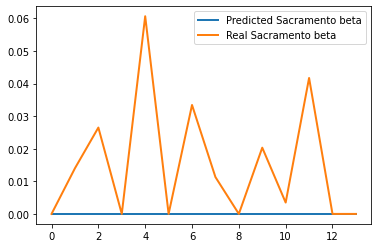

In [121]:
x = range(valid_l)
y1 = mlp1db_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

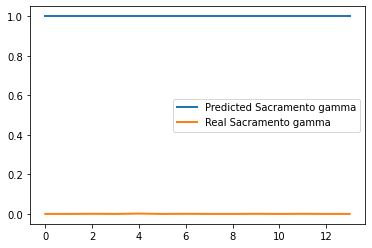

In [122]:
x = range(valid_l)
y1 = mlp1db_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

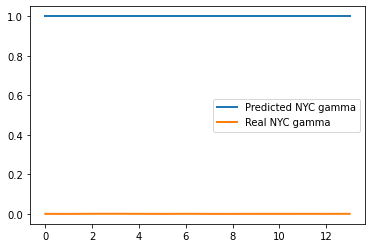

In [123]:
x = range(valid_l)
y1 = mlp1db_validp_gamma_NYC
y2 = valid_gamma_NYC
plt.plot(x, y1, ls="-", lw=2, label="Predicted NYC gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real NYC gamma")
plt.legend()
plt.show()

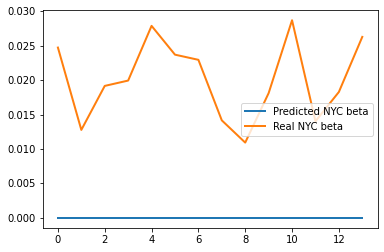

In [124]:
x = range(valid_l)
y1 = mlp1db_validp_beta_NYC
y2 = valid_beta_NYC
plt.plot(x, y1, ls="-", lw=2, label="Predicted NYC beta")
plt.plot(x, y2, ls="-", lw=2, label="Real NYC beta")
plt.legend()
plt.show()

## MLP - SIR (loss = params)

In [52]:
# For debugging
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
# Move model to GPU
mlp_sir = mlp_sir.to(device)

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)

idx = 0
batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
vals = mlp_sir(batch)
loss = th.mean(100*(train_labels_gamma_1d[idx] - vals[:,0].view(3142,1))**2 + (train_labels_beta_1d[idx] - vals[:,1].view(3142,1))**2)

#features: 97


In [168]:
hidden_size = 100
learning_rate = 0.00000005
num_epochs = 10000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_past_gamma_1d[i] = train_past_gamma_1d[i].to(device)
    train_past_beta_1d[i] = train_past_beta_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    train_labels_gamma_1d[i] = train_labels_gamma_1d[i].to(device)
    train_labels_beta_1d[i] = train_labels_beta_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
    if len(train_labels_gamma_1d[i].shape) == 1:
        train_labels_gamma_1d[i] = train_labels_gamma_1d[i].unsqueeze(1)
    if len(train_labels_beta_1d[i].shape) == 1:
        train_labels_beta_1d[i] = train_labels_beta_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_past_gamma_1d[i] = valid_past_gamma_1d[i].to(device)
    valid_past_beta_1d[i] = valid_past_beta_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].to(device)
    valid_labels_beta_1d[i] = valid_labels_beta_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)
    if len(valid_labels_gamma_1d[i].shape) == 1:
         valid_labels_gamma_1d[i] = valid_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        valid_labels_beta_1d[i] = valid_labels_beta_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_past_gamma_1d[i] = test_past_gamma_1d[i].to(device)
    test_past_beta_1d[i] = test_past_beta_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    test_labels_gamma_1d[i] = test_labels_gamma_1d[i].to(device)
    test_labels_beta_1d[i] = test_labels_beta_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
    if len(test_labels_gamma_1d[i].shape) == 1:
        test_labels_gamma_1d[i] = test_labels_gamma_1d[i].unsqueeze(1)
    if len(test_labels_beta_1d[i].shape) == 1:
        test_labels_beta_1d[i] = test_labels_beta_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std


optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        loss = th.mean(100000*(train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(100000*(valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(100000*(test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_loss1), np.mean(test_loss1), np.mean(test_mses), np.mean(test_maes)))

#features: 97
epoch=0, loss=11941.613, validation loss = 6720.769, test loss=5654.323, test mse = 14729131.000, test mae = 754.296
epoch=1, loss=11923.652, validation loss = 6703.085, test loss=5638.383, test mse = 14729134.000, test mae = 754.313
epoch=2, loss=11904.122, validation loss = 6684.845, test loss=5621.950, test mse = 14729136.000, test mae = 754.330
epoch=3, loss=11884.281, validation loss = 6666.600, test loss=5605.517, test mse = 14729136.000, test mae = 754.347
epoch=4, loss=11864.436, validation loss = 6648.468, test loss=5589.191, test mse = 14729137.000, test mae = 754.363
epoch=5, loss=11844.675, validation loss = 6630.479, test loss=5573.001, test mse = 14729139.000, test mae = 754.380
epoch=6, loss=11825.074, validation loss = 6612.734, test loss=5557.037, test mse = 14729142.000, test mae = 754.396
epoch=7, loss=11805.672, validation loss = 6595.194, test loss=5541.262, test mse = 14729145.000, test mae = 754.412
epoch=8, loss=11786.444, validation loss = 6577.84

epoch=70, loss=10872.705, validation loss = 5796.740, test loss=4828.202, test mse = 14729203.000, test mae = 755.081
epoch=71, loss=10860.621, validation loss = 5786.871, test loss=4819.445, test mse = 14729203.000, test mae = 755.088
epoch=72, loss=10848.572, validation loss = 5777.042, test loss=4810.728, test mse = 14729205.000, test mae = 755.096
epoch=73, loss=10836.560, validation loss = 5767.257, test loss=4802.049, test mse = 14729206.000, test mae = 755.103
epoch=74, loss=10824.582, validation loss = 5757.512, test loss=4793.407, test mse = 14729207.000, test mae = 755.110
epoch=75, loss=10812.639, validation loss = 5747.810, test loss=4784.807, test mse = 14729207.000, test mae = 755.118
epoch=76, loss=10800.736, validation loss = 5738.155, test loss=4776.248, test mse = 14729208.000, test mae = 755.125
epoch=77, loss=10788.871, validation loss = 5728.544, test loss=4767.729, test mse = 14729209.000, test mae = 755.132
epoch=78, loss=10777.047, validation loss = 5718.977, te

epoch=140, loss=10118.838, validation loss = 5204.545, test loss=4305.144, test mse = 14729238.000, test mae = 755.504
epoch=141, loss=10109.177, validation loss = 5197.227, test loss=4298.708, test mse = 14729239.000, test mae = 755.509
epoch=142, loss=10099.541, validation loss = 5189.931, test loss=4292.292, test mse = 14729239.000, test mae = 755.513
epoch=143, loss=10089.924, validation loss = 5182.656, test loss=4285.895, test mse = 14729239.000, test mae = 755.518
epoch=144, loss=10080.329, validation loss = 5175.402, test loss=4279.517, test mse = 14729239.000, test mae = 755.523
epoch=145, loss=10070.756, validation loss = 5168.174, test loss=4273.162, test mse = 14729241.000, test mae = 755.528
epoch=146, loss=10061.207, validation loss = 5160.970, test loss=4266.829, test mse = 14729242.000, test mae = 755.533
epoch=147, loss=10051.682, validation loss = 5153.790, test loss=4260.517, test mse = 14729242.000, test mae = 755.537
epoch=148, loss=10042.177, validation loss = 514

epoch=210, loss=9488.205, validation loss = 4739.027, test loss=3897.298, test mse = 14729261.000, test mae = 755.806
epoch=211, loss=9479.741, validation loss = 4732.942, test loss=3891.985, test mse = 14729262.000, test mae = 755.810
epoch=212, loss=9471.290, validation loss = 4726.871, test loss=3886.684, test mse = 14729262.000, test mae = 755.814
epoch=213, loss=9462.850, validation loss = 4720.813, test loss=3881.396, test mse = 14729264.000, test mae = 755.817
epoch=214, loss=9454.420, validation loss = 4714.766, test loss=3876.119, test mse = 14729264.000, test mae = 755.821
epoch=215, loss=9445.998, validation loss = 4708.734, test loss=3870.854, test mse = 14729264.000, test mae = 755.825
epoch=216, loss=9437.589, validation loss = 4702.715, test loss=3865.601, test mse = 14729264.000, test mae = 755.829
epoch=217, loss=9429.191, validation loss = 4696.708, test loss=3860.362, test mse = 14729264.000, test mae = 755.832
epoch=218, loss=9420.806, validation loss = 4690.715, te

epoch=280, loss=8924.717, validation loss = 4343.696, test loss=3553.166, test mse = 14729280.000, test mae = 756.038
epoch=281, loss=8917.058, validation loss = 4338.459, test loss=3548.622, test mse = 14729280.000, test mae = 756.040
epoch=282, loss=8909.408, validation loss = 4333.231, test loss=3544.087, test mse = 14729280.000, test mae = 756.043
epoch=283, loss=8901.768, validation loss = 4328.014, test loss=3539.562, test mse = 14729280.000, test mae = 756.046
epoch=284, loss=8894.137, validation loss = 4322.809, test loss=3535.045, test mse = 14729280.000, test mae = 756.049
epoch=285, loss=8886.518, validation loss = 4317.612, test loss=3530.540, test mse = 14729280.000, test mae = 756.051
epoch=286, loss=8878.907, validation loss = 4312.427, test loss=3526.043, test mse = 14729281.000, test mae = 756.054
epoch=287, loss=8871.308, validation loss = 4307.252, test loss=3521.555, test mse = 14729281.000, test mae = 756.057
epoch=288, loss=8863.715, validation loss = 4302.087, te

epoch=350, loss=8409.824, validation loss = 3999.949, test loss=3255.916, test mse = 14729291.000, test mae = 756.215
epoch=351, loss=8402.773, validation loss = 3995.345, test loss=3251.950, test mse = 14729291.000, test mae = 756.217
epoch=352, loss=8395.730, validation loss = 3990.749, test loss=3247.992, test mse = 14729293.000, test mae = 756.220
epoch=353, loss=8388.696, validation loss = 3986.161, test loss=3244.041, test mse = 14729293.000, test mae = 756.222
epoch=354, loss=8381.668, validation loss = 3981.578, test loss=3240.095, test mse = 14729293.000, test mae = 756.224
epoch=355, loss=8374.646, validation loss = 3977.002, test loss=3236.156, test mse = 14729293.000, test mae = 756.226
epoch=356, loss=8367.632, validation loss = 3972.434, test loss=3232.225, test mse = 14729293.000, test mae = 756.229
epoch=357, loss=8360.626, validation loss = 3967.873, test loss=3228.300, test mse = 14729293.000, test mae = 756.231
epoch=358, loss=8353.627, validation loss = 3963.319, te

epoch=420, loss=7934.153, validation loss = 3695.296, test loss=2994.623, test mse = 14729302.000, test mae = 756.368
epoch=421, loss=7927.609, validation loss = 3691.195, test loss=2991.120, test mse = 14729302.000, test mae = 756.370
epoch=422, loss=7921.073, validation loss = 3687.101, test loss=2987.623, test mse = 14729302.000, test mae = 756.372
epoch=423, loss=7914.543, validation loss = 3683.014, test loss=2984.131, test mse = 14729302.000, test mae = 756.374
epoch=424, loss=7908.020, validation loss = 3678.933, test loss=2980.646, test mse = 14729302.000, test mae = 756.376
epoch=425, loss=7901.502, validation loss = 3674.861, test loss=2977.168, test mse = 14729303.000, test mae = 756.378
epoch=426, loss=7894.993, validation loss = 3670.794, test loss=2973.696, test mse = 14729303.000, test mae = 756.380
epoch=427, loss=7888.488, validation loss = 3666.734, test loss=2970.230, test mse = 14729303.000, test mae = 756.382
epoch=428, loss=7881.990, validation loss = 3662.680, te

epoch=490, loss=7490.884, validation loss = 3423.645, test loss=2763.152, test mse = 14729312.000, test mae = 756.498
epoch=491, loss=7484.761, validation loss = 3419.983, test loss=2760.035, test mse = 14729312.000, test mae = 756.500
epoch=492, loss=7478.645, validation loss = 3416.326, test loss=2756.923, test mse = 14729313.000, test mae = 756.502
epoch=493, loss=7472.533, validation loss = 3412.674, test loss=2753.815, test mse = 14729313.000, test mae = 756.503
epoch=494, loss=7466.426, validation loss = 3409.026, test loss=2750.712, test mse = 14729313.000, test mae = 756.505
epoch=495, loss=7460.325, validation loss = 3405.385, test loss=2747.614, test mse = 14729313.000, test mae = 756.506
epoch=496, loss=7454.228, validation loss = 3401.747, test loss=2744.520, test mse = 14729313.000, test mae = 756.508
epoch=497, loss=7448.136, validation loss = 3398.115, test loss=2741.430, test mse = 14729313.000, test mae = 756.510
epoch=498, loss=7442.049, validation loss = 3394.489, te

epoch=560, loss=7073.519, validation loss = 3178.198, test loss=2554.874, test mse = 14729319.000, test mae = 756.600
epoch=561, loss=7067.703, validation loss = 3174.831, test loss=2552.027, test mse = 14729319.000, test mae = 756.602
epoch=562, loss=7061.891, validation loss = 3171.467, test loss=2549.183, test mse = 14729319.000, test mae = 756.603
epoch=563, loss=7056.084, validation loss = 3168.108, test loss=2546.344, test mse = 14729319.000, test mae = 756.604
epoch=564, loss=7050.281, validation loss = 3164.752, test loss=2543.507, test mse = 14729319.000, test mae = 756.605
epoch=565, loss=7044.482, validation loss = 3161.401, test loss=2540.675, test mse = 14729319.000, test mae = 756.607
epoch=566, loss=7038.688, validation loss = 3158.053, test loss=2537.846, test mse = 14729319.000, test mae = 756.608
epoch=567, loss=7032.898, validation loss = 3154.710, test loss=2535.021, test mse = 14729319.000, test mae = 756.609
epoch=568, loss=7027.113, validation loss = 3151.371, te

epoch=630, loss=6676.171, validation loss = 2951.721, test loss=2363.866, test mse = 14729322.000, test mae = 756.676
epoch=631, loss=6670.629, validation loss = 2948.611, test loss=2361.250, test mse = 14729322.000, test mae = 756.676
epoch=632, loss=6665.091, validation loss = 2945.504, test loss=2358.637, test mse = 14729322.000, test mae = 756.677
epoch=633, loss=6659.557, validation loss = 2942.401, test loss=2356.027, test mse = 14729322.000, test mae = 756.678
epoch=634, loss=6654.027, validation loss = 2939.301, test loss=2353.420, test mse = 14729322.000, test mae = 756.679
epoch=635, loss=6648.500, validation loss = 2936.204, test loss=2350.817, test mse = 14729322.000, test mae = 756.680
epoch=636, loss=6642.977, validation loss = 2933.111, test loss=2348.216, test mse = 14729322.000, test mae = 756.681
epoch=637, loss=6637.457, validation loss = 2930.020, test loss=2345.617, test mse = 14729322.000, test mae = 756.682
epoch=638, loss=6631.940, validation loss = 2926.933, te

epoch=700, loss=6295.725, validation loss = 2740.975, test loss=2187.169, test mse = 14729323.000, test mae = 756.726
epoch=701, loss=6290.396, validation loss = 2738.063, test loss=2184.735, test mse = 14729323.000, test mae = 756.727
epoch=702, loss=6285.073, validation loss = 2735.153, test loss=2182.303, test mse = 14729323.000, test mae = 756.728
epoch=703, loss=6279.753, validation loss = 2732.246, test loss=2179.874, test mse = 14729323.000, test mae = 756.728
epoch=704, loss=6274.437, validation loss = 2729.342, test loss=2177.447, test mse = 14729323.000, test mae = 756.729
epoch=705, loss=6269.123, validation loss = 2726.439, test loss=2175.022, test mse = 14729323.000, test mae = 756.730
epoch=706, loss=6263.813, validation loss = 2723.540, test loss=2172.599, test mse = 14729323.000, test mae = 756.730
epoch=707, loss=6258.506, validation loss = 2720.643, test loss=2170.179, test mse = 14729323.000, test mae = 756.731
epoch=708, loss=6253.201, validation loss = 2717.749, te

epoch=770, loss=5929.451, validation loss = 2542.961, test loss=2022.143, test mse = 14729323.000, test mae = 756.765
epoch=771, loss=5924.310, validation loss = 2540.213, test loss=2019.861, test mse = 14729323.000, test mae = 756.765
epoch=772, loss=5919.172, validation loss = 2537.468, test loss=2017.580, test mse = 14729323.000, test mae = 756.765
epoch=773, loss=5914.036, validation loss = 2534.725, test loss=2015.302, test mse = 14729323.000, test mae = 756.766
epoch=774, loss=5908.904, validation loss = 2531.985, test loss=2013.026, test mse = 14729323.000, test mae = 756.766
epoch=775, loss=5903.775, validation loss = 2529.248, test loss=2010.752, test mse = 14729323.000, test mae = 756.766
epoch=776, loss=5898.649, validation loss = 2526.514, test loss=2008.482, test mse = 14729323.000, test mae = 756.767
epoch=777, loss=5893.526, validation loss = 2523.783, test loss=2006.214, test mse = 14729323.000, test mae = 756.767
epoch=778, loss=5888.407, validation loss = 2521.055, te

epoch=840, loss=5576.415, validation loss = 2356.642, test loss=1867.717, test mse = 14729318.000, test mae = 756.774
epoch=841, loss=5571.467, validation loss = 2354.064, test loss=1865.586, test mse = 14729318.000, test mae = 756.774
epoch=842, loss=5566.521, validation loss = 2351.489, test loss=1863.457, test mse = 14729318.000, test mae = 756.774
epoch=843, loss=5561.580, validation loss = 2348.916, test loss=1861.330, test mse = 14729318.000, test mae = 756.774
epoch=844, loss=5556.642, validation loss = 2346.346, test loss=1859.207, test mse = 14729318.000, test mae = 756.774
epoch=845, loss=5551.706, validation loss = 2343.779, test loss=1857.085, test mse = 14729318.000, test mae = 756.774
epoch=846, loss=5546.773, validation loss = 2341.214, test loss=1854.965, test mse = 14729318.000, test mae = 756.774
epoch=847, loss=5541.845, validation loss = 2338.651, test loss=1852.847, test mse = 14729318.000, test mae = 756.773
epoch=848, loss=5536.918, validation loss = 2336.091, te

epoch=910, loss=5236.608, validation loss = 2181.553, test loss=1723.374, test mse = 14729313.000, test mae = 756.749
epoch=911, loss=5231.846, validation loss = 2179.125, test loss=1721.378, test mse = 14729313.000, test mae = 756.749
epoch=912, loss=5227.086, validation loss = 2176.698, test loss=1719.383, test mse = 14729313.000, test mae = 756.748
epoch=913, loss=5222.328, validation loss = 2174.273, test loss=1717.390, test mse = 14729312.000, test mae = 756.748
epoch=914, loss=5217.572, validation loss = 2171.850, test loss=1715.399, test mse = 14729312.000, test mae = 756.747
epoch=915, loss=5212.818, validation loss = 2169.429, test loss=1713.409, test mse = 14729312.000, test mae = 756.747
epoch=916, loss=5208.066, validation loss = 2167.010, test loss=1711.421, test mse = 14729312.000, test mae = 756.746
epoch=917, loss=5203.316, validation loss = 2164.592, test loss=1709.435, test mse = 14729312.000, test mae = 756.745
epoch=918, loss=5198.568, validation loss = 2162.177, te

epoch=980, loss=4907.997, validation loss = 2015.623, test loss=1587.439, test mse = 14729299.000, test mae = 756.703
epoch=981, loss=4903.382, validation loss = 2013.316, test loss=1585.556, test mse = 14729299.000, test mae = 756.702
epoch=982, loss=4898.770, validation loss = 2011.012, test loss=1583.674, test mse = 14729299.000, test mae = 756.701
epoch=983, loss=4894.161, validation loss = 2008.710, test loss=1581.795, test mse = 14729299.000, test mae = 756.701
epoch=984, loss=4889.554, validation loss = 2006.409, test loss=1579.917, test mse = 14729299.000, test mae = 756.700
epoch=985, loss=4884.950, validation loss = 2004.111, test loss=1578.041, test mse = 14729299.000, test mae = 756.699
epoch=986, loss=4880.349, validation loss = 2001.815, test loss=1576.166, test mse = 14729299.000, test mae = 756.698
epoch=987, loss=4875.750, validation loss = 1999.520, test loss=1574.294, test mse = 14729299.000, test mae = 756.697
epoch=988, loss=4871.154, validation loss = 1997.228, te

epoch=1058, loss=4555.064, validation loss = 1841.319, test loss=1445.557, test mse = 14729283.000, test mae = 756.621
epoch=1059, loss=4550.627, validation loss = 1839.157, test loss=1443.803, test mse = 14729282.000, test mae = 756.619
epoch=1060, loss=4546.193, validation loss = 1836.997, test loss=1442.050, test mse = 14729282.000, test mae = 756.618
epoch=1061, loss=4541.761, validation loss = 1834.839, test loss=1440.299, test mse = 14729282.000, test mae = 756.616
epoch=1062, loss=4537.332, validation loss = 1832.683, test loss=1438.550, test mse = 14729282.000, test mae = 756.615
epoch=1063, loss=4532.904, validation loss = 1830.528, test loss=1436.802, test mse = 14729282.000, test mae = 756.613
epoch=1064, loss=4528.479, validation loss = 1828.375, test loss=1435.055, test mse = 14729281.000, test mae = 756.612
epoch=1065, loss=4524.056, validation loss = 1826.223, test loss=1433.310, test mse = 14729281.000, test mae = 756.610
epoch=1066, loss=4519.634, validation loss = 182

epoch=1127, loss=4254.224, validation loss = 1696.290, test loss=1328.132, test mse = 14729263.000, test mae = 756.505
epoch=1128, loss=4249.955, validation loss = 1694.253, test loss=1326.486, test mse = 14729263.000, test mae = 756.503
epoch=1129, loss=4245.688, validation loss = 1692.217, test loss=1324.842, test mse = 14729262.000, test mae = 756.501
epoch=1130, loss=4241.424, validation loss = 1690.183, test loss=1323.199, test mse = 14729262.000, test mae = 756.500
epoch=1131, loss=4237.163, validation loss = 1688.152, test loss=1321.558, test mse = 14729262.000, test mae = 756.498
epoch=1132, loss=4232.904, validation loss = 1686.121, test loss=1319.919, test mse = 14729262.000, test mae = 756.496
epoch=1133, loss=4228.647, validation loss = 1684.093, test loss=1318.281, test mse = 14729261.000, test mae = 756.494
epoch=1134, loss=4224.393, validation loss = 1682.067, test loss=1316.644, test mse = 14729261.000, test mae = 756.492
epoch=1135, loss=4220.141, validation loss = 168

epoch=1196, loss=3964.974, validation loss = 1559.802, test loss=1218.107, test mse = 14729237.000, test mae = 756.363
epoch=1197, loss=3960.857, validation loss = 1557.884, test loss=1216.563, test mse = 14729235.000, test mae = 756.361
epoch=1198, loss=3956.741, validation loss = 1555.968, test loss=1215.021, test mse = 14729235.000, test mae = 756.359
epoch=1199, loss=3952.628, validation loss = 1554.053, test loss=1213.481, test mse = 14729235.000, test mae = 756.357
epoch=1200, loss=3948.517, validation loss = 1552.139, test loss=1211.941, test mse = 14729235.000, test mae = 756.355
epoch=1201, loss=3944.408, validation loss = 1550.227, test loss=1210.403, test mse = 14729234.000, test mae = 756.353
epoch=1202, loss=3940.302, validation loss = 1548.316, test loss=1208.866, test mse = 14729232.000, test mae = 756.351
epoch=1203, loss=3936.198, validation loss = 1546.407, test loss=1207.331, test mse = 14729232.000, test mae = 756.348
epoch=1204, loss=3932.095, validation loss = 154

epoch=1265, loss=3686.374, validation loss = 1431.368, test loss=1114.986, test mse = 14729209.000, test mae = 756.212
epoch=1266, loss=3682.423, validation loss = 1429.565, test loss=1113.543, test mse = 14729208.000, test mae = 756.210
epoch=1267, loss=3678.475, validation loss = 1427.764, test loss=1112.101, test mse = 14729208.000, test mae = 756.207
epoch=1268, loss=3674.530, validation loss = 1425.966, test loss=1110.660, test mse = 14729208.000, test mae = 756.205
epoch=1269, loss=3670.590, validation loss = 1424.170, test loss=1109.223, test mse = 14729207.000, test mae = 756.203
epoch=1270, loss=3666.652, validation loss = 1422.376, test loss=1107.786, test mse = 14729207.000, test mae = 756.200
epoch=1271, loss=3662.717, validation loss = 1420.583, test loss=1106.351, test mse = 14729207.000, test mae = 756.198
epoch=1272, loss=3658.784, validation loss = 1418.793, test loss=1104.917, test mse = 14729207.000, test mae = 756.196
epoch=1273, loss=3654.854, validation loss = 141

epoch=1334, loss=3419.675, validation loss = 1310.894, test loss=1018.700, test mse = 14729176.000, test mae = 756.038
epoch=1335, loss=3415.890, validation loss = 1309.200, test loss=1017.349, test mse = 14729176.000, test mae = 756.035
epoch=1336, loss=3412.102, validation loss = 1307.507, test loss=1015.999, test mse = 14729175.000, test mae = 756.032
epoch=1337, loss=3408.313, validation loss = 1305.815, test loss=1014.650, test mse = 14729174.000, test mae = 756.029
epoch=1338, loss=3404.524, validation loss = 1304.124, test loss=1013.302, test mse = 14729174.000, test mae = 756.026
epoch=1339, loss=3400.737, validation loss = 1302.435, test loss=1011.955, test mse = 14729174.000, test mae = 756.024
epoch=1340, loss=3396.952, validation loss = 1300.747, test loss=1010.610, test mse = 14729173.000, test mae = 756.021
epoch=1341, loss=3393.169, validation loss = 1299.060, test loss=1009.266, test mse = 14729173.000, test mae = 756.018
epoch=1342, loss=3389.388, validation loss = 129

epoch=1404, loss=3158.931, validation loss = 1195.739, test loss=927.097, test mse = 14729134.000, test mae = 755.821
epoch=1405, loss=3155.263, validation loss = 1194.139, test loss=925.827, test mse = 14729133.000, test mae = 755.817
epoch=1406, loss=3151.597, validation loss = 1192.540, test loss=924.559, test mse = 14729133.000, test mae = 755.814
epoch=1407, loss=3147.932, validation loss = 1190.943, test loss=923.291, test mse = 14729131.000, test mae = 755.810
epoch=1408, loss=3144.271, validation loss = 1189.347, test loss=922.025, test mse = 14729131.000, test mae = 755.807
epoch=1409, loss=3140.610, validation loss = 1187.753, test loss=920.761, test mse = 14729129.000, test mae = 755.804
epoch=1410, loss=3136.953, validation loss = 1186.160, test loss=919.497, test mse = 14729127.000, test mae = 755.800
epoch=1411, loss=3133.297, validation loss = 1184.569, test loss=918.235, test mse = 14729127.000, test mae = 755.796
epoch=1412, loss=3129.644, validation loss = 1182.979, t

epoch=1474, loss=2906.943, validation loss = 1087.034, test loss=841.016, test mse = 14729077.000, test mae = 755.551
epoch=1475, loss=2903.415, validation loss = 1085.530, test loss=839.827, test mse = 14729077.000, test mae = 755.546
epoch=1476, loss=2899.889, validation loss = 1084.027, test loss=838.639, test mse = 14729075.000, test mae = 755.542
epoch=1477, loss=2896.366, validation loss = 1082.525, test loss=837.453, test mse = 14729075.000, test mae = 755.538
epoch=1478, loss=2892.845, validation loss = 1081.025, test loss=836.267, test mse = 14729073.000, test mae = 755.534
epoch=1479, loss=2889.325, validation loss = 1079.526, test loss=835.083, test mse = 14729071.000, test mae = 755.529
epoch=1480, loss=2885.808, validation loss = 1078.029, test loss=833.900, test mse = 14729071.000, test mae = 755.525
epoch=1481, loss=2882.292, validation loss = 1076.533, test loss=832.718, test mse = 14729069.000, test mae = 755.521
epoch=1482, loss=2878.780, validation loss = 1075.039, t

epoch=1544, loss=2665.276, validation loss = 985.246, test loss=760.691, test mse = 14729005.000, test mae = 755.224
epoch=1545, loss=2661.898, validation loss = 983.840, test loss=759.583, test mse = 14729003.000, test mae = 755.219
epoch=1546, loss=2658.522, validation loss = 982.434, test loss=758.475, test mse = 14729003.000, test mae = 755.214
epoch=1547, loss=2655.149, validation loss = 981.028, test loss=757.368, test mse = 14729000.000, test mae = 755.209
epoch=1548, loss=2651.777, validation loss = 979.624, test loss=756.263, test mse = 14728998.000, test mae = 755.204
epoch=1549, loss=2648.407, validation loss = 978.220, test loss=755.158, test mse = 14728997.000, test mae = 755.198
epoch=1550, loss=2645.039, validation loss = 976.819, test loss=754.054, test mse = 14728997.000, test mae = 755.193
epoch=1551, loss=2641.673, validation loss = 975.418, test loss=752.951, test mse = 14728995.000, test mae = 755.188
epoch=1552, loss=2638.310, validation loss = 974.019, test loss=

epoch=1615, loss=2430.056, validation loss = 888.199, test loss=684.396, test mse = 14728911.000, test mae = 754.818
epoch=1616, loss=2426.814, validation loss = 886.875, test loss=683.357, test mse = 14728910.000, test mae = 754.811
epoch=1617, loss=2423.574, validation loss = 885.553, test loss=682.320, test mse = 14728907.000, test mae = 754.805
epoch=1618, loss=2420.337, validation loss = 884.232, test loss=681.283, test mse = 14728903.000, test mae = 754.798
epoch=1619, loss=2417.103, validation loss = 882.912, test loss=680.248, test mse = 14728903.000, test mae = 754.792
epoch=1620, loss=2413.870, validation loss = 881.594, test loss=679.214, test mse = 14728901.000, test mae = 754.785
epoch=1621, loss=2410.640, validation loss = 880.277, test loss=678.181, test mse = 14728899.000, test mae = 754.779
epoch=1622, loss=2407.411, validation loss = 878.960, test loss=677.147, test mse = 14728899.000, test mae = 754.772
epoch=1623, loss=2404.182, validation loss = 877.642, test loss=

epoch=1686, loss=2204.713, validation loss = 797.079, test loss=613.026, test mse = 14728785.000, test mae = 754.300
epoch=1687, loss=2201.621, validation loss = 795.841, test loss=612.058, test mse = 14728783.000, test mae = 754.292
epoch=1688, loss=2198.531, validation loss = 794.605, test loss=611.091, test mse = 14728779.000, test mae = 754.284
epoch=1689, loss=2195.444, validation loss = 793.370, test loss=610.126, test mse = 14728777.000, test mae = 754.275
epoch=1690, loss=2192.360, validation loss = 792.136, test loss=609.162, test mse = 14728774.000, test mae = 754.267
epoch=1691, loss=2189.278, validation loss = 790.904, test loss=608.198, test mse = 14728773.000, test mae = 754.258
epoch=1692, loss=2186.199, validation loss = 789.673, test loss=607.236, test mse = 14728770.000, test mae = 754.250
epoch=1693, loss=2183.122, validation loss = 788.444, test loss=606.275, test mse = 14728769.000, test mae = 754.242
epoch=1694, loss=2180.048, validation loss = 787.216, test loss=

epoch=1757, loss=1991.157, validation loss = 712.261, test loss=546.839, test mse = 14728609.000, test mae = 753.622
epoch=1758, loss=1988.234, validation loss = 711.108, test loss=545.942, test mse = 14728606.000, test mae = 753.610
epoch=1759, loss=1985.313, validation loss = 709.957, test loss=545.045, test mse = 14728605.000, test mae = 753.599
epoch=1760, loss=1982.395, validation loss = 708.807, test loss=544.150, test mse = 14728599.000, test mae = 753.588
epoch=1761, loss=1979.480, validation loss = 707.658, test loss=543.255, test mse = 14728597.000, test mae = 753.577
epoch=1762, loss=1976.567, validation loss = 706.511, test loss=542.362, test mse = 14728594.000, test mae = 753.565
epoch=1763, loss=1973.656, validation loss = 705.364, test loss=541.470, test mse = 14728592.000, test mae = 753.554
epoch=1764, loss=1970.748, validation loss = 704.219, test loss=540.578, test mse = 14728589.000, test mae = 753.543
epoch=1765, loss=1967.842, validation loss = 703.076, test loss=

epoch=1828, loss=1789.668, validation loss = 633.499, test loss=485.601, test mse = 14728349.000, test mae = 752.687
epoch=1829, loss=1786.912, validation loss = 632.431, test loss=484.771, test mse = 14728346.000, test mae = 752.671
epoch=1830, loss=1784.159, validation loss = 631.363, test loss=483.943, test mse = 14728341.000, test mae = 752.656
epoch=1831, loss=1781.407, validation loss = 630.297, test loss=483.115, test mse = 14728334.000, test mae = 752.640
epoch=1832, loss=1778.657, validation loss = 629.232, test loss=482.288, test mse = 14728331.000, test mae = 752.625
epoch=1833, loss=1775.909, validation loss = 628.168, test loss=481.462, test mse = 14728327.000, test mae = 752.609
epoch=1834, loss=1773.163, validation loss = 627.104, test loss=480.637, test mse = 14728320.000, test mae = 752.593
epoch=1835, loss=1770.420, validation loss = 626.042, test loss=479.812, test mse = 14728317.000, test mae = 752.577
epoch=1836, loss=1767.678, validation loss = 624.981, test loss=

epoch=1899, loss=1599.863, validation loss = 560.585, test loss=429.083, test mse = 14727947.000, test mae = 751.399
epoch=1900, loss=1597.279, validation loss = 559.602, test loss=428.321, test mse = 14727941.000, test mae = 751.378
epoch=1901, loss=1594.698, validation loss = 558.619, test loss=427.561, test mse = 14727933.000, test mae = 751.356
epoch=1902, loss=1592.119, validation loss = 557.638, test loss=426.801, test mse = 14727925.000, test mae = 751.334
epoch=1903, loss=1589.543, validation loss = 556.659, test loss=426.043, test mse = 14727918.000, test mae = 751.312
epoch=1904, loss=1586.969, validation loss = 555.680, test loss=425.285, test mse = 14727911.000, test mae = 751.290
epoch=1905, loss=1584.398, validation loss = 554.703, test loss=424.529, test mse = 14727905.000, test mae = 751.268
epoch=1906, loss=1581.830, validation loss = 553.727, test loss=423.773, test mse = 14727897.000, test mae = 751.246
epoch=1907, loss=1579.264, validation loss = 552.752, test loss=

epoch=1970, loss=1422.923, validation loss = 493.767, test loss=377.405, test mse = 14727253.000, test mae = 749.461
epoch=1971, loss=1420.527, validation loss = 492.869, test loss=376.712, test mse = 14727239.000, test mae = 749.426
epoch=1972, loss=1418.133, validation loss = 491.973, test loss=376.019, test mse = 14727225.000, test mae = 749.391
epoch=1973, loss=1415.742, validation loss = 491.077, test loss=375.328, test mse = 14727211.000, test mae = 749.355
epoch=1974, loss=1413.354, validation loss = 490.183, test loss=374.637, test mse = 14727197.000, test mae = 749.318
epoch=1975, loss=1410.969, validation loss = 489.290, test loss=373.948, test mse = 14727184.000, test mae = 749.282
epoch=1976, loss=1408.585, validation loss = 488.398, test loss=373.259, test mse = 14727169.000, test mae = 749.245
epoch=1977, loss=1406.205, validation loss = 487.508, test loss=372.571, test mse = 14727154.000, test mae = 749.208
epoch=1978, loss=1403.828, validation loss = 486.618, test loss=

epoch=2041, loss=1259.146, validation loss = 432.774, test loss=330.355, test mse = 14725553.000, test mae = 745.749
epoch=2042, loss=1256.931, validation loss = 431.954, test loss=329.723, test mse = 14725511.000, test mae = 745.671
epoch=2043, loss=1254.719, validation loss = 431.136, test loss=329.092, test mse = 14725470.000, test mae = 745.593
epoch=2044, loss=1252.510, validation loss = 430.318, test loss=328.463, test mse = 14725427.000, test mae = 745.514
epoch=2045, loss=1250.304, validation loss = 429.502, test loss=327.834, test mse = 14725383.000, test mae = 745.433
epoch=2046, loss=1248.100, validation loss = 428.687, test loss=327.206, test mse = 14725339.000, test mae = 745.352
epoch=2047, loss=1245.900, validation loss = 427.873, test loss=326.579, test mse = 14725296.000, test mae = 745.270
epoch=2048, loss=1243.703, validation loss = 427.061, test loss=325.954, test mse = 14725251.000, test mae = 745.187
epoch=2049, loss=1241.509, validation loss = 426.250, test loss=

epoch=2112, loss=1108.773, validation loss = 377.454, test loss=287.769, test mse = 14718450.000, test mae = 736.141
epoch=2113, loss=1106.754, validation loss = 376.715, test loss=287.201, test mse = 14718208.000, test mae = 735.897
epoch=2114, loss=1104.738, validation loss = 375.978, test loss=286.634, test mse = 14717957.000, test mae = 735.649
epoch=2115, loss=1102.725, validation loss = 375.242, test loss=286.068, test mse = 14717695.000, test mae = 735.395
epoch=2116, loss=1100.714, validation loss = 374.506, test loss=285.503, test mse = 14717423.000, test mae = 735.134
epoch=2117, loss=1098.705, validation loss = 373.772, test loss=284.938, test mse = 14717142.000, test mae = 734.868
epoch=2118, loss=1096.699, validation loss = 373.039, test loss=284.374, test mse = 14716846.000, test mae = 734.595
epoch=2119, loss=1094.696, validation loss = 372.307, test loss=283.811, test mse = 14716539.000, test mae = 734.316
epoch=2120, loss=1092.695, validation loss = 371.576, test loss=

epoch=2183, loss=971.447, validation loss = 327.484, test loss=249.352, test mse = 5119460.500, test mae = 365.875
epoch=2184, loss=969.596, validation loss = 326.813, test loss=248.837, test mse = 5089926.500, test mae = 360.911
epoch=2185, loss=967.746, validation loss = 326.144, test loss=248.323, test mse = 5061791.000, test mae = 356.028
epoch=2186, loss=965.900, validation loss = 325.475, test loss=247.810, test mse = 5035832.500, test mae = 351.263
epoch=2187, loss=964.055, validation loss = 324.808, test loss=247.298, test mse = 5012049.500, test mae = 346.647
epoch=2188, loss=962.214, validation loss = 324.141, test loss=246.787, test mse = 4989597.500, test mae = 342.171
epoch=2189, loss=960.374, validation loss = 323.476, test loss=246.276, test mse = 4968022.500, test mae = 337.810
epoch=2190, loss=958.537, validation loss = 322.811, test loss=245.766, test mse = 4947407.500, test mae = 333.555
epoch=2191, loss=956.703, validation loss = 322.148, test loss=245.257, test mse

epoch=2255, loss=844.312, validation loss = 281.723, test loss=214.267, test mse = 781874.062, test mae = 103.681
epoch=2256, loss=842.638, validation loss = 281.125, test loss=213.809, test mse = 777951.938, test mae = 102.213
epoch=2257, loss=840.966, validation loss = 280.528, test loss=213.351, test mse = 774893.062, test mae = 100.881
epoch=2258, loss=839.297, validation loss = 279.932, test loss=212.895, test mse = 771961.188, test mae = 99.625
epoch=2259, loss=837.630, validation loss = 279.337, test loss=212.439, test mse = 768833.188, test mae = 98.389
epoch=2260, loss=835.966, validation loss = 278.743, test loss=211.984, test mse = 764801.125, test mae = 97.156
epoch=2261, loss=834.304, validation loss = 278.150, test loss=211.530, test mse = 757915.500, test mae = 95.893
epoch=2262, loss=832.644, validation loss = 277.558, test loss=211.076, test mse = 744934.125, test mae = 94.512
epoch=2263, loss=830.987, validation loss = 276.967, test loss=210.624, test mse = 728483.875

epoch=2328, loss=728.407, validation loss = 240.601, test loss=182.801, test mse = 18671.529, test mae = 32.604
epoch=2329, loss=726.907, validation loss = 240.072, test loss=182.397, test mse = 17784.684, test mae = 32.269
epoch=2330, loss=725.409, validation loss = 239.545, test loss=181.994, test mse = 16990.529, test mae = 31.947
epoch=2331, loss=723.914, validation loss = 239.018, test loss=181.591, test mse = 16308.117, test mae = 31.638
epoch=2332, loss=722.421, validation loss = 238.492, test loss=181.189, test mse = 15749.547, test mae = 31.352
epoch=2333, loss=720.930, validation loss = 237.967, test loss=180.788, test mse = 15300.116, test mae = 31.091
epoch=2334, loss=719.441, validation loss = 237.443, test loss=180.388, test mse = 14923.641, test mae = 30.858
epoch=2335, loss=717.955, validation loss = 236.920, test loss=179.988, test mse = 14577.597, test mae = 30.636
epoch=2336, loss=716.471, validation loss = 236.398, test loss=179.589, test mse = 14227.589, test mae =

epoch=2402, loss=623.398, validation loss = 203.806, test loss=154.708, test mse = 7211.719, test mae = 22.779
epoch=2403, loss=622.059, validation loss = 203.340, test loss=154.353, test mse = 7205.268, test mae = 22.716
epoch=2404, loss=620.721, validation loss = 202.874, test loss=153.998, test mse = 7199.063, test mae = 22.653
epoch=2405, loss=619.385, validation loss = 202.409, test loss=153.643, test mse = 7193.089, test mae = 22.591
epoch=2406, loss=618.052, validation loss = 201.945, test loss=153.289, test mse = 7187.326, test mae = 22.529
epoch=2407, loss=616.720, validation loss = 201.481, test loss=152.936, test mse = 7181.761, test mae = 22.469
epoch=2408, loss=615.391, validation loss = 201.019, test loss=152.583, test mse = 7176.378, test mae = 22.409
epoch=2409, loss=614.064, validation loss = 200.557, test loss=152.231, test mse = 7171.164, test mae = 22.350
epoch=2410, loss=612.739, validation loss = 200.096, test loss=151.879, test mse = 7166.104, test mae = 22.291
e

epoch=2476, loss=530.180, validation loss = 171.512, test loss=130.101, test mse = 6967.892, test mae = 19.423
epoch=2477, loss=529.001, validation loss = 171.106, test loss=129.792, test mse = 6966.165, test mae = 19.392
epoch=2478, loss=527.824, validation loss = 170.700, test loss=129.483, test mse = 6964.461, test mae = 19.360
epoch=2479, loss=526.649, validation loss = 170.296, test loss=129.175, test mse = 6962.783, test mae = 19.329
epoch=2480, loss=525.477, validation loss = 169.892, test loss=128.867, test mse = 6961.125, test mae = 19.298
epoch=2481, loss=524.306, validation loss = 169.489, test loss=128.561, test mse = 6959.491, test mae = 19.267
epoch=2482, loss=523.138, validation loss = 169.086, test loss=128.254, test mse = 6957.878, test mae = 19.236
epoch=2483, loss=521.971, validation loss = 168.685, test loss=127.949, test mse = 6956.285, test mae = 19.206
epoch=2484, loss=520.807, validation loss = 168.284, test loss=127.644, test mse = 6954.712, test mae = 19.176
e

epoch=2550, loss=448.472, validation loss = 143.493, test loss=108.784, test mse = 6881.756, test mae = 17.616
epoch=2551, loss=447.442, validation loss = 143.142, test loss=108.517, test mse = 6881.081, test mae = 17.598
epoch=2552, loss=446.415, validation loss = 142.791, test loss=108.251, test mse = 6880.422, test mae = 17.579
epoch=2553, loss=445.389, validation loss = 142.441, test loss=107.985, test mse = 6879.774, test mae = 17.561
epoch=2554, loss=444.365, validation loss = 142.092, test loss=107.720, test mse = 6879.141, test mae = 17.543
epoch=2555, loss=443.344, validation loss = 141.744, test loss=107.455, test mse = 6878.521, test mae = 17.524
epoch=2556, loss=442.324, validation loss = 141.397, test loss=107.191, test mse = 6877.914, test mae = 17.507
epoch=2557, loss=441.307, validation loss = 141.050, test loss=106.927, test mse = 6877.319, test mae = 17.489
epoch=2558, loss=440.291, validation loss = 140.704, test loss=106.664, test mse = 6876.737, test mae = 17.471
e

epoch=2625, loss=376.547, validation loss = 119.048, test loss=90.217, test mse = 6854.489, test mae = 16.504
epoch=2626, loss=375.659, validation loss = 118.747, test loss=89.989, test mse = 6854.286, test mae = 16.492
epoch=2627, loss=374.772, validation loss = 118.447, test loss=89.761, test mse = 6854.085, test mae = 16.481
epoch=2628, loss=373.887, validation loss = 118.147, test loss=89.534, test mse = 6853.887, test mae = 16.469
epoch=2629, loss=373.004, validation loss = 117.848, test loss=89.307, test mse = 6853.690, test mae = 16.458
epoch=2630, loss=372.123, validation loss = 117.550, test loss=89.081, test mse = 6853.495, test mae = 16.446
epoch=2631, loss=371.244, validation loss = 117.253, test loss=88.855, test mse = 6853.302, test mae = 16.435
epoch=2632, loss=370.366, validation loss = 116.956, test loss=88.630, test mse = 6853.112, test mae = 16.423
epoch=2633, loss=369.490, validation loss = 116.659, test loss=88.405, test mse = 6852.923, test mae = 16.412
epoch=2634

epoch=2700, loss=314.727, validation loss = 98.186, test loss=74.398, test mse = 6843.583, test mae = 15.781
epoch=2701, loss=313.966, validation loss = 97.930, test loss=74.204, test mse = 6843.481, test mae = 15.773
epoch=2702, loss=313.206, validation loss = 97.675, test loss=74.011, test mse = 6843.380, test mae = 15.766
epoch=2703, loss=312.448, validation loss = 97.420, test loss=73.818, test mse = 6843.280, test mae = 15.758
epoch=2704, loss=311.692, validation loss = 97.166, test loss=73.625, test mse = 6843.180, test mae = 15.750
epoch=2705, loss=310.937, validation loss = 96.912, test loss=73.433, test mse = 6843.082, test mae = 15.743
epoch=2706, loss=310.184, validation loss = 96.659, test loss=73.241, test mse = 6842.984, test mae = 15.735
epoch=2707, loss=309.432, validation loss = 96.407, test loss=73.050, test mse = 6842.886, test mae = 15.728
epoch=2708, loss=308.682, validation loss = 96.155, test loss=72.859, test mse = 6842.790, test mae = 15.720
epoch=2709, loss=30

epoch=2776, loss=261.443, validation loss = 80.333, test loss=60.882, test mse = 6837.635, test mae = 15.278
epoch=2777, loss=260.800, validation loss = 80.119, test loss=60.720, test mse = 6837.575, test mae = 15.273
epoch=2778, loss=260.158, validation loss = 79.904, test loss=60.557, test mse = 6837.515, test mae = 15.267
epoch=2779, loss=259.518, validation loss = 79.690, test loss=60.396, test mse = 6837.456, test mae = 15.261
epoch=2780, loss=258.880, validation loss = 79.477, test loss=60.234, test mse = 6837.398, test mae = 15.256
epoch=2781, loss=258.243, validation loss = 79.264, test loss=60.073, test mse = 6837.339, test mae = 15.250
epoch=2782, loss=257.607, validation loss = 79.052, test loss=59.913, test mse = 6837.281, test mae = 15.244
epoch=2783, loss=256.973, validation loss = 78.840, test loss=59.753, test mse = 6837.222, test mae = 15.239
epoch=2784, loss=256.340, validation loss = 78.629, test loss=59.593, test mse = 6837.165, test mae = 15.233
epoch=2785, loss=25

epoch=2852, loss=216.590, validation loss = 65.384, test loss=49.583, test mse = 6833.942, test mae = 14.893
epoch=2853, loss=216.051, validation loss = 65.205, test loss=49.447, test mse = 6833.904, test mae = 14.888
epoch=2854, loss=215.514, validation loss = 65.026, test loss=49.313, test mse = 6833.865, test mae = 14.884
epoch=2855, loss=214.979, validation loss = 64.848, test loss=49.178, test mse = 6833.827, test mae = 14.879
epoch=2856, loss=214.444, validation loss = 64.671, test loss=49.044, test mse = 6833.789, test mae = 14.875
epoch=2857, loss=213.911, validation loss = 64.494, test loss=48.910, test mse = 6833.750, test mae = 14.871
epoch=2858, loss=213.379, validation loss = 64.317, test loss=48.777, test mse = 6833.714, test mae = 14.866
epoch=2859, loss=212.849, validation loss = 64.141, test loss=48.644, test mse = 6833.676, test mae = 14.862
epoch=2860, loss=212.320, validation loss = 63.965, test loss=48.511, test mse = 6833.640, test mae = 14.858
epoch=2861, loss=21

epoch=2928, loss=179.217, validation loss = 52.989, test loss=40.228, test mse = 6831.552, test mae = 14.593
epoch=2929, loss=178.771, validation loss = 52.841, test loss=40.116, test mse = 6831.527, test mae = 14.590
epoch=2930, loss=178.326, validation loss = 52.694, test loss=40.005, test mse = 6831.501, test mae = 14.586
epoch=2931, loss=177.882, validation loss = 52.547, test loss=39.894, test mse = 6831.476, test mae = 14.583
epoch=2932, loss=177.439, validation loss = 52.400, test loss=39.783, test mse = 6831.452, test mae = 14.579
epoch=2933, loss=176.997, validation loss = 52.254, test loss=39.673, test mse = 6831.427, test mae = 14.576
epoch=2934, loss=176.557, validation loss = 52.108, test loss=39.563, test mse = 6831.402, test mae = 14.572
epoch=2935, loss=176.117, validation loss = 51.962, test loss=39.453, test mse = 6831.378, test mae = 14.569
epoch=2936, loss=175.679, validation loss = 51.817, test loss=39.344, test mse = 6831.354, test mae = 14.566
epoch=2937, loss=17

epoch=3004, loss=148.302, validation loss = 42.761, test loss=32.522, test mse = 6829.974, test mae = 14.359
epoch=3005, loss=147.934, validation loss = 42.639, test loss=32.431, test mse = 6829.957, test mae = 14.356
epoch=3006, loss=147.567, validation loss = 42.518, test loss=32.339, test mse = 6829.940, test mae = 14.353
epoch=3007, loss=147.201, validation loss = 42.397, test loss=32.248, test mse = 6829.924, test mae = 14.351
epoch=3008, loss=146.836, validation loss = 42.276, test loss=32.157, test mse = 6829.907, test mae = 14.348
epoch=3009, loss=146.471, validation loss = 42.156, test loss=32.067, test mse = 6829.891, test mae = 14.345
epoch=3010, loss=146.108, validation loss = 42.036, test loss=31.976, test mse = 6829.874, test mae = 14.343
epoch=3011, loss=145.746, validation loss = 41.916, test loss=31.886, test mse = 6829.858, test mae = 14.340
epoch=3012, loss=145.385, validation loss = 41.796, test loss=31.796, test mse = 6829.841, test mae = 14.337
epoch=3013, loss=14

epoch=3080, loss=123.016, validation loss = 34.400, test loss=26.235, test mse = 6828.907, test mae = 14.174
epoch=3081, loss=122.717, validation loss = 34.301, test loss=26.161, test mse = 6828.897, test mae = 14.172
epoch=3082, loss=122.420, validation loss = 34.203, test loss=26.087, test mse = 6828.886, test mae = 14.170
epoch=3083, loss=122.123, validation loss = 34.105, test loss=26.014, test mse = 6828.874, test mae = 14.168
epoch=3084, loss=121.827, validation loss = 34.007, test loss=25.940, test mse = 6828.862, test mae = 14.166
epoch=3085, loss=121.532, validation loss = 33.909, test loss=25.867, test mse = 6828.851, test mae = 14.163
epoch=3086, loss=121.238, validation loss = 33.812, test loss=25.794, test mse = 6828.840, test mae = 14.161
epoch=3087, loss=120.945, validation loss = 33.715, test loss=25.721, test mse = 6828.829, test mae = 14.159
epoch=3088, loss=120.652, validation loss = 33.618, test loss=25.648, test mse = 6828.817, test mae = 14.157
epoch=3089, loss=12

epoch=3156, loss=102.613, validation loss = 27.650, test loss=21.168, test mse = 6828.177, test mae = 14.029
epoch=3157, loss=102.374, validation loss = 27.571, test loss=21.109, test mse = 6828.170, test mae = 14.027
epoch=3158, loss=102.136, validation loss = 27.492, test loss=21.050, test mse = 6828.161, test mae = 14.025
epoch=3159, loss=101.899, validation loss = 27.413, test loss=20.991, test mse = 6828.154, test mae = 14.024
epoch=3160, loss=101.662, validation loss = 27.335, test loss=20.932, test mse = 6828.145, test mae = 14.022
epoch=3161, loss=101.425, validation loss = 27.256, test loss=20.873, test mse = 6828.138, test mae = 14.020
epoch=3162, loss=101.190, validation loss = 27.178, test loss=20.815, test mse = 6828.130, test mae = 14.019
epoch=3163, loss=100.955, validation loss = 27.101, test loss=20.756, test mse = 6828.124, test mae = 14.017
epoch=3164, loss=100.721, validation loss = 27.023, test loss=20.698, test mse = 6828.115, test mae = 14.015
epoch=3165, loss=10

epoch=3232, loss=86.361, validation loss = 22.265, test loss=17.132, test mse = 6827.656, test mae = 13.911
epoch=3233, loss=86.172, validation loss = 22.202, test loss=17.085, test mse = 6827.649, test mae = 13.909
epoch=3234, loss=85.983, validation loss = 22.140, test loss=17.038, test mse = 6827.644, test mae = 13.908
epoch=3235, loss=85.795, validation loss = 22.077, test loss=16.992, test mse = 6827.638, test mae = 13.906
epoch=3236, loss=85.607, validation loss = 22.015, test loss=16.945, test mse = 6827.632, test mae = 13.905
epoch=3237, loss=85.420, validation loss = 21.953, test loss=16.898, test mse = 6827.627, test mae = 13.904
epoch=3238, loss=85.234, validation loss = 21.891, test loss=16.852, test mse = 6827.622, test mae = 13.902
epoch=3239, loss=85.048, validation loss = 21.829, test loss=16.806, test mse = 6827.616, test mae = 13.901
epoch=3240, loss=84.862, validation loss = 21.768, test loss=16.760, test mse = 6827.609, test mae = 13.900
epoch=3241, loss=84.677, val

epoch=3308, loss=73.527, validation loss = 17.999, test loss=13.940, test mse = 6827.266, test mae = 13.812
epoch=3309, loss=73.378, validation loss = 17.949, test loss=13.903, test mse = 6827.261, test mae = 13.811
epoch=3310, loss=73.229, validation loss = 17.900, test loss=13.866, test mse = 6827.257, test mae = 13.809
epoch=3311, loss=73.081, validation loss = 17.851, test loss=13.829, test mse = 6827.253, test mae = 13.808
epoch=3312, loss=72.934, validation loss = 17.801, test loss=13.792, test mse = 6827.249, test mae = 13.807
epoch=3313, loss=72.786, validation loss = 17.752, test loss=13.755, test mse = 6827.244, test mae = 13.806
epoch=3314, loss=72.640, validation loss = 17.704, test loss=13.719, test mse = 6827.240, test mae = 13.805
epoch=3315, loss=72.494, validation loss = 17.655, test loss=13.683, test mse = 6827.236, test mae = 13.803
epoch=3316, loss=72.348, validation loss = 17.606, test loss=13.646, test mse = 6827.231, test mae = 13.802
epoch=3317, loss=72.203, val

epoch=3384, loss=63.500, validation loss = 14.650, test loss=11.438, test mse = 6826.974, test mae = 13.728
epoch=3385, loss=63.385, validation loss = 14.611, test loss=11.410, test mse = 6826.970, test mae = 13.727
epoch=3386, loss=63.270, validation loss = 14.573, test loss=11.381, test mse = 6826.968, test mae = 13.726
epoch=3387, loss=63.155, validation loss = 14.534, test loss=11.352, test mse = 6826.964, test mae = 13.725
epoch=3388, loss=63.041, validation loss = 14.496, test loss=11.324, test mse = 6826.961, test mae = 13.724
epoch=3389, loss=62.927, validation loss = 14.458, test loss=11.295, test mse = 6826.957, test mae = 13.723
epoch=3390, loss=62.813, validation loss = 14.420, test loss=11.267, test mse = 6826.954, test mae = 13.722
epoch=3391, loss=62.700, validation loss = 14.382, test loss=11.238, test mse = 6826.951, test mae = 13.721
epoch=3392, loss=62.587, validation loss = 14.344, test loss=11.210, test mse = 6826.948, test mae = 13.720
epoch=3393, loss=62.475, val

epoch=3461, loss=55.688, validation loss = 12.022, test loss=9.479, test mse = 6826.753, test mae = 13.656
epoch=3462, loss=55.599, validation loss = 11.992, test loss=9.457, test mse = 6826.752, test mae = 13.655
epoch=3463, loss=55.512, validation loss = 11.962, test loss=9.435, test mse = 6826.750, test mae = 13.654
epoch=3464, loss=55.424, validation loss = 11.933, test loss=9.413, test mse = 6826.747, test mae = 13.654
epoch=3465, loss=55.337, validation loss = 11.903, test loss=9.391, test mse = 6826.745, test mae = 13.653
epoch=3466, loss=55.250, validation loss = 11.874, test loss=9.369, test mse = 6826.742, test mae = 13.652
epoch=3467, loss=55.163, validation loss = 11.845, test loss=9.347, test mse = 6826.740, test mae = 13.651
epoch=3468, loss=55.077, validation loss = 11.815, test loss=9.325, test mse = 6826.738, test mae = 13.650
epoch=3469, loss=54.991, validation loss = 11.786, test loss=9.304, test mse = 6826.735, test mae = 13.649
epoch=3470, loss=54.906, validation l

epoch=3538, loss=49.754, validation loss = 10.006, test loss=7.980, test mse = 6826.594, test mae = 13.596
epoch=3539, loss=49.687, validation loss = 9.983, test loss=7.963, test mse = 6826.591, test mae = 13.595
epoch=3540, loss=49.621, validation loss = 9.961, test loss=7.946, test mse = 6826.589, test mae = 13.594
epoch=3541, loss=49.555, validation loss = 9.938, test loss=7.929, test mse = 6826.587, test mae = 13.593
epoch=3542, loss=49.489, validation loss = 9.915, test loss=7.912, test mse = 6826.586, test mae = 13.593
epoch=3543, loss=49.423, validation loss = 9.893, test loss=7.895, test mse = 6826.585, test mae = 13.592
epoch=3544, loss=49.358, validation loss = 9.870, test loss=7.879, test mse = 6826.583, test mae = 13.591
epoch=3545, loss=49.292, validation loss = 9.848, test loss=7.862, test mse = 6826.581, test mae = 13.591
epoch=3546, loss=49.227, validation loss = 9.826, test loss=7.846, test mse = 6826.580, test mae = 13.590
epoch=3547, loss=49.163, validation loss = 9.

epoch=3616, loss=45.244, validation loss = 8.455, test loss=6.827, test mse = 6826.474, test mae = 13.544
epoch=3617, loss=45.195, validation loss = 8.437, test loss=6.815, test mse = 6826.473, test mae = 13.543
epoch=3618, loss=45.146, validation loss = 8.420, test loss=6.802, test mse = 6826.472, test mae = 13.543
epoch=3619, loss=45.097, validation loss = 8.403, test loss=6.789, test mse = 6826.470, test mae = 13.542
epoch=3620, loss=45.048, validation loss = 8.386, test loss=6.777, test mse = 6826.469, test mae = 13.542
epoch=3621, loss=44.999, validation loss = 8.370, test loss=6.764, test mse = 6826.468, test mae = 13.541
epoch=3622, loss=44.951, validation loss = 8.353, test loss=6.752, test mse = 6826.466, test mae = 13.540
epoch=3623, loss=44.903, validation loss = 8.336, test loss=6.740, test mse = 6826.465, test mae = 13.540
epoch=3624, loss=44.854, validation loss = 8.319, test loss=6.727, test mse = 6826.464, test mae = 13.539
epoch=3625, loss=44.807, validation loss = 8.3

epoch=3694, loss=41.924, validation loss = 7.296, test loss=5.968, test mse = 6826.388, test mae = 13.501
epoch=3695, loss=41.888, validation loss = 7.283, test loss=5.959, test mse = 6826.387, test mae = 13.500
epoch=3696, loss=41.852, validation loss = 7.270, test loss=5.950, test mse = 6826.387, test mae = 13.500
epoch=3697, loss=41.816, validation loss = 7.258, test loss=5.940, test mse = 6826.386, test mae = 13.499
epoch=3698, loss=41.780, validation loss = 7.245, test loss=5.931, test mse = 6826.385, test mae = 13.499
epoch=3699, loss=41.745, validation loss = 7.232, test loss=5.922, test mse = 6826.383, test mae = 13.498
epoch=3700, loss=41.709, validation loss = 7.220, test loss=5.912, test mse = 6826.383, test mae = 13.497
epoch=3701, loss=41.674, validation loss = 7.207, test loss=5.903, test mse = 6826.382, test mae = 13.497
epoch=3702, loss=41.639, validation loss = 7.195, test loss=5.894, test mse = 6826.380, test mae = 13.496
epoch=3703, loss=41.604, validation loss = 7.1

epoch=3772, loss=39.507, validation loss = 6.437, test loss=5.333, test mse = 6826.327, test mae = 13.464
epoch=3773, loss=39.481, validation loss = 6.428, test loss=5.326, test mse = 6826.326, test mae = 13.464
epoch=3774, loss=39.455, validation loss = 6.418, test loss=5.319, test mse = 6826.325, test mae = 13.463
epoch=3775, loss=39.429, validation loss = 6.409, test loss=5.312, test mse = 6826.325, test mae = 13.463
epoch=3776, loss=39.404, validation loss = 6.400, test loss=5.305, test mse = 6826.323, test mae = 13.462
epoch=3777, loss=39.378, validation loss = 6.390, test loss=5.299, test mse = 6826.323, test mae = 13.462
epoch=3778, loss=39.353, validation loss = 6.381, test loss=5.292, test mse = 6826.321, test mae = 13.462
epoch=3779, loss=39.327, validation loss = 6.372, test loss=5.285, test mse = 6826.321, test mae = 13.461
epoch=3780, loss=39.302, validation loss = 6.363, test loss=5.278, test mse = 6826.321, test mae = 13.461
epoch=3781, loss=39.277, validation loss = 6.3

epoch=3850, loss=37.778, validation loss = 5.809, test loss=4.869, test mse = 6826.282, test mae = 13.433
epoch=3851, loss=37.760, validation loss = 5.802, test loss=4.864, test mse = 6826.282, test mae = 13.433
epoch=3852, loss=37.741, validation loss = 5.796, test loss=4.859, test mse = 6826.281, test mae = 13.433
epoch=3853, loss=37.723, validation loss = 5.789, test loss=4.854, test mse = 6826.281, test mae = 13.432
epoch=3854, loss=37.705, validation loss = 5.782, test loss=4.849, test mse = 6826.280, test mae = 13.432
epoch=3855, loss=37.687, validation loss = 5.775, test loss=4.844, test mse = 6826.280, test mae = 13.432
epoch=3856, loss=37.668, validation loss = 5.769, test loss=4.839, test mse = 6826.280, test mae = 13.431
epoch=3857, loss=37.650, validation loss = 5.762, test loss=4.834, test mse = 6826.279, test mae = 13.431
epoch=3858, loss=37.632, validation loss = 5.755, test loss=4.830, test mse = 6826.278, test mae = 13.431
epoch=3859, loss=37.615, validation loss = 5.7

epoch=3928, loss=36.558, validation loss = 5.355, test loss=4.534, test mse = 6826.251, test mae = 13.407
epoch=3929, loss=36.545, validation loss = 5.350, test loss=4.530, test mse = 6826.251, test mae = 13.407
epoch=3930, loss=36.532, validation loss = 5.345, test loss=4.527, test mse = 6826.251, test mae = 13.407
epoch=3931, loss=36.519, validation loss = 5.340, test loss=4.523, test mse = 6826.250, test mae = 13.406
epoch=3932, loss=36.506, validation loss = 5.335, test loss=4.520, test mse = 6826.250, test mae = 13.406
epoch=3933, loss=36.494, validation loss = 5.330, test loss=4.516, test mse = 6826.250, test mae = 13.406
epoch=3934, loss=36.481, validation loss = 5.325, test loss=4.512, test mse = 6826.250, test mae = 13.406
epoch=3935, loss=36.468, validation loss = 5.321, test loss=4.509, test mse = 6826.250, test mae = 13.405
epoch=3936, loss=36.456, validation loss = 5.316, test loss=4.505, test mse = 6826.250, test mae = 13.405
epoch=3937, loss=36.443, validation loss = 5.3

epoch=4006, loss=35.708, validation loss = 5.028, test loss=4.293, test mse = 6826.229, test mae = 13.385
epoch=4007, loss=35.699, validation loss = 5.025, test loss=4.291, test mse = 6826.229, test mae = 13.385
epoch=4008, loss=35.690, validation loss = 5.021, test loss=4.288, test mse = 6826.229, test mae = 13.385
epoch=4009, loss=35.681, validation loss = 5.018, test loss=4.286, test mse = 6826.229, test mae = 13.385
epoch=4010, loss=35.672, validation loss = 5.014, test loss=4.283, test mse = 6826.228, test mae = 13.384
epoch=4011, loss=35.663, validation loss = 5.011, test loss=4.281, test mse = 6826.228, test mae = 13.384
epoch=4012, loss=35.655, validation loss = 5.007, test loss=4.278, test mse = 6826.228, test mae = 13.384
epoch=4013, loss=35.646, validation loss = 5.004, test loss=4.276, test mse = 6826.228, test mae = 13.384
epoch=4014, loss=35.637, validation loss = 5.001, test loss=4.273, test mse = 6826.228, test mae = 13.383
epoch=4015, loss=35.629, validation loss = 4.9

epoch=4084, loss=35.127, validation loss = 4.797, test loss=4.123, test mse = 6826.215, test mae = 13.367
epoch=4085, loss=35.121, validation loss = 4.795, test loss=4.121, test mse = 6826.214, test mae = 13.367
epoch=4086, loss=35.115, validation loss = 4.792, test loss=4.120, test mse = 6826.214, test mae = 13.367
epoch=4087, loss=35.109, validation loss = 4.790, test loss=4.118, test mse = 6826.214, test mae = 13.366
epoch=4088, loss=35.103, validation loss = 4.787, test loss=4.116, test mse = 6826.214, test mae = 13.366
epoch=4089, loss=35.097, validation loss = 4.785, test loss=4.114, test mse = 6826.214, test mae = 13.366
epoch=4090, loss=35.091, validation loss = 4.782, test loss=4.112, test mse = 6826.214, test mae = 13.366
epoch=4091, loss=35.085, validation loss = 4.780, test loss=4.111, test mse = 6826.214, test mae = 13.365
epoch=4092, loss=35.079, validation loss = 4.778, test loss=4.109, test mse = 6826.214, test mae = 13.365
epoch=4093, loss=35.073, validation loss = 4.7

epoch=4162, loss=34.737, validation loss = 4.635, test loss=4.004, test mse = 6826.204, test mae = 13.351
epoch=4163, loss=34.733, validation loss = 4.633, test loss=4.003, test mse = 6826.204, test mae = 13.351
epoch=4164, loss=34.729, validation loss = 4.632, test loss=4.002, test mse = 6826.204, test mae = 13.351
epoch=4165, loss=34.725, validation loss = 4.630, test loss=4.000, test mse = 6826.204, test mae = 13.351
epoch=4166, loss=34.721, validation loss = 4.628, test loss=3.999, test mse = 6826.204, test mae = 13.350
epoch=4167, loss=34.717, validation loss = 4.627, test loss=3.998, test mse = 6826.204, test mae = 13.350
epoch=4168, loss=34.713, validation loss = 4.625, test loss=3.997, test mse = 6826.204, test mae = 13.350
epoch=4169, loss=34.709, validation loss = 4.623, test loss=3.995, test mse = 6826.204, test mae = 13.350
epoch=4170, loss=34.705, validation loss = 4.621, test loss=3.994, test mse = 6826.204, test mae = 13.350
epoch=4171, loss=34.701, validation loss = 4.6

epoch=4240, loss=34.480, validation loss = 4.523, test loss=3.921, test mse = 6826.198, test mae = 13.338
epoch=4241, loss=34.477, validation loss = 4.521, test loss=3.921, test mse = 6826.198, test mae = 13.337
epoch=4242, loss=34.475, validation loss = 4.520, test loss=3.920, test mse = 6826.198, test mae = 13.337
epoch=4243, loss=34.472, validation loss = 4.519, test loss=3.919, test mse = 6826.198, test mae = 13.337
epoch=4244, loss=34.469, validation loss = 4.518, test loss=3.918, test mse = 6826.198, test mae = 13.337
epoch=4245, loss=34.467, validation loss = 4.517, test loss=3.917, test mse = 6826.198, test mae = 13.337
epoch=4246, loss=34.464, validation loss = 4.516, test loss=3.916, test mse = 6826.198, test mae = 13.337
epoch=4247, loss=34.462, validation loss = 4.514, test loss=3.915, test mse = 6826.197, test mae = 13.336
epoch=4248, loss=34.459, validation loss = 4.513, test loss=3.915, test mse = 6826.198, test mae = 13.336
epoch=4249, loss=34.457, validation loss = 4.5

epoch=4318, loss=34.314, validation loss = 4.445, test loss=3.865, test mse = 6826.194, test mae = 13.326
epoch=4319, loss=34.312, validation loss = 4.445, test loss=3.864, test mse = 6826.194, test mae = 13.326
epoch=4320, loss=34.311, validation loss = 4.444, test loss=3.863, test mse = 6826.194, test mae = 13.326
epoch=4321, loss=34.309, validation loss = 4.443, test loss=3.863, test mse = 6826.194, test mae = 13.325
epoch=4322, loss=34.307, validation loss = 4.442, test loss=3.862, test mse = 6826.194, test mae = 13.325
epoch=4323, loss=34.306, validation loss = 4.441, test loss=3.862, test mse = 6826.194, test mae = 13.325
epoch=4324, loss=34.304, validation loss = 4.441, test loss=3.861, test mse = 6826.194, test mae = 13.325
epoch=4325, loss=34.303, validation loss = 4.440, test loss=3.860, test mse = 6826.194, test mae = 13.325
epoch=4326, loss=34.301, validation loss = 4.439, test loss=3.860, test mse = 6826.194, test mae = 13.325
epoch=4327, loss=34.299, validation loss = 4.4

epoch=4396, loss=34.210, validation loss = 4.393, test loss=3.826, test mse = 6826.191, test mae = 13.316
epoch=4397, loss=34.209, validation loss = 4.392, test loss=3.825, test mse = 6826.191, test mae = 13.316
epoch=4398, loss=34.208, validation loss = 4.392, test loss=3.825, test mse = 6826.191, test mae = 13.315
epoch=4399, loss=34.207, validation loss = 4.391, test loss=3.825, test mse = 6826.191, test mae = 13.315
epoch=4400, loss=34.206, validation loss = 4.391, test loss=3.824, test mse = 6826.191, test mae = 13.315
epoch=4401, loss=34.204, validation loss = 4.390, test loss=3.824, test mse = 6826.191, test mae = 13.315
epoch=4402, loss=34.203, validation loss = 4.390, test loss=3.823, test mse = 6826.191, test mae = 13.315
epoch=4403, loss=34.202, validation loss = 4.389, test loss=3.823, test mse = 6826.191, test mae = 13.315
epoch=4404, loss=34.201, validation loss = 4.389, test loss=3.823, test mse = 6826.191, test mae = 13.315
epoch=4405, loss=34.200, validation loss = 4.3

epoch=4474, loss=34.146, validation loss = 4.357, test loss=3.800, test mse = 6826.191, test mae = 13.307
epoch=4475, loss=34.145, validation loss = 4.357, test loss=3.799, test mse = 6826.191, test mae = 13.307
epoch=4476, loss=34.144, validation loss = 4.357, test loss=3.799, test mse = 6826.191, test mae = 13.307
epoch=4477, loss=34.144, validation loss = 4.356, test loss=3.799, test mse = 6826.191, test mae = 13.306
epoch=4478, loss=34.143, validation loss = 4.356, test loss=3.799, test mse = 6826.191, test mae = 13.306
epoch=4479, loss=34.142, validation loss = 4.356, test loss=3.798, test mse = 6826.191, test mae = 13.306
epoch=4480, loss=34.142, validation loss = 4.355, test loss=3.798, test mse = 6826.191, test mae = 13.306
epoch=4481, loss=34.141, validation loss = 4.355, test loss=3.798, test mse = 6826.191, test mae = 13.306
epoch=4482, loss=34.141, validation loss = 4.355, test loss=3.797, test mse = 6826.191, test mae = 13.306
epoch=4483, loss=34.140, validation loss = 4.3

epoch=4552, loss=34.108, validation loss = 4.334, test loss=3.782, test mse = 6826.191, test mae = 13.299
epoch=4553, loss=34.107, validation loss = 4.334, test loss=3.782, test mse = 6826.191, test mae = 13.299
epoch=4554, loss=34.107, validation loss = 4.333, test loss=3.782, test mse = 6826.191, test mae = 13.299
epoch=4555, loss=34.107, validation loss = 4.333, test loss=3.781, test mse = 6826.191, test mae = 13.299
epoch=4556, loss=34.106, validation loss = 4.333, test loss=3.781, test mse = 6826.191, test mae = 13.299
epoch=4557, loss=34.106, validation loss = 4.333, test loss=3.781, test mse = 6826.191, test mae = 13.298
epoch=4558, loss=34.105, validation loss = 4.332, test loss=3.781, test mse = 6826.191, test mae = 13.298
epoch=4559, loss=34.105, validation loss = 4.332, test loss=3.781, test mse = 6826.191, test mae = 13.298
epoch=4560, loss=34.105, validation loss = 4.332, test loss=3.781, test mse = 6826.191, test mae = 13.298
epoch=4561, loss=34.104, validation loss = 4.3

epoch=4630, loss=34.086, validation loss = 4.318, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4631, loss=34.086, validation loss = 4.318, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4632, loss=34.086, validation loss = 4.318, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4633, loss=34.085, validation loss = 4.318, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4634, loss=34.085, validation loss = 4.317, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4635, loss=34.085, validation loss = 4.317, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4636, loss=34.085, validation loss = 4.317, test loss=3.770, test mse = 6826.191, test mae = 13.292
epoch=4637, loss=34.085, validation loss = 4.317, test loss=3.770, test mse = 6826.191, test mae = 13.291
epoch=4638, loss=34.085, validation loss = 4.317, test loss=3.769, test mse = 6826.191, test mae = 13.291
epoch=4639, loss=34.084, validation loss = 4.3

epoch=4708, loss=34.075, validation loss = 4.308, test loss=3.763, test mse = 6826.192, test mae = 13.286
epoch=4709, loss=34.074, validation loss = 4.308, test loss=3.763, test mse = 6826.192, test mae = 13.286
epoch=4710, loss=34.074, validation loss = 4.308, test loss=3.762, test mse = 6826.192, test mae = 13.286
epoch=4711, loss=34.074, validation loss = 4.308, test loss=3.762, test mse = 6826.192, test mae = 13.286
epoch=4712, loss=34.074, validation loss = 4.307, test loss=3.762, test mse = 6826.192, test mae = 13.286
epoch=4713, loss=34.074, validation loss = 4.307, test loss=3.762, test mse = 6826.192, test mae = 13.286
epoch=4714, loss=34.074, validation loss = 4.307, test loss=3.762, test mse = 6826.192, test mae = 13.286
epoch=4715, loss=34.074, validation loss = 4.307, test loss=3.762, test mse = 6826.192, test mae = 13.285
epoch=4716, loss=34.074, validation loss = 4.307, test loss=3.762, test mse = 6826.192, test mae = 13.285
epoch=4717, loss=34.074, validation loss = 4.3

epoch=4786, loss=34.069, validation loss = 4.301, test loss=3.758, test mse = 6826.193, test mae = 13.281
epoch=4787, loss=34.069, validation loss = 4.301, test loss=3.758, test mse = 6826.193, test mae = 13.281
epoch=4788, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4789, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4790, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4791, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4792, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4793, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4794, loss=34.069, validation loss = 4.301, test loss=3.757, test mse = 6826.193, test mae = 13.280
epoch=4795, loss=34.069, validation loss = 4.3

epoch=4864, loss=34.067, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4865, loss=34.067, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4866, loss=34.067, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4867, loss=34.067, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4868, loss=34.067, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4869, loss=34.066, validation loss = 4.297, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4870, loss=34.066, validation loss = 4.296, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4871, loss=34.066, validation loss = 4.296, test loss=3.754, test mse = 6826.194, test mae = 13.276
epoch=4872, loss=34.066, validation loss = 4.296, test loss=3.754, test mse = 6826.194, test mae = 13.275
epoch=4873, loss=34.066, validation loss = 4.2

epoch=4942, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4943, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4944, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4945, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4946, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4947, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4948, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.272
epoch=4949, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.271
epoch=4950, loss=34.066, validation loss = 4.294, test loss=3.752, test mse = 6826.195, test mae = 13.271
epoch=4951, loss=34.066, validation loss = 4.2

epoch=5020, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5021, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5022, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5023, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5024, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5025, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5026, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5027, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5028, loss=34.066, validation loss = 4.292, test loss=3.751, test mse = 6826.196, test mae = 13.268
epoch=5029, loss=34.066, validation loss = 4.2

epoch=5098, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5099, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5100, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5101, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5102, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5103, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5104, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5105, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5106, loss=34.066, validation loss = 4.291, test loss=3.750, test mse = 6826.198, test mae = 13.265
epoch=5107, loss=34.066, validation loss = 4.2

epoch=5176, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.263
epoch=5177, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5178, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5179, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5180, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5181, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5182, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5183, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5184, loss=34.066, validation loss = 4.290, test loss=3.749, test mse = 6826.199, test mae = 13.262
epoch=5185, loss=34.066, validation loss = 4.2

epoch=5254, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5255, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5256, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5257, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5258, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5259, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5260, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5261, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5262, loss=34.067, validation loss = 4.290, test loss=3.749, test mse = 6826.200, test mae = 13.260
epoch=5263, loss=34.067, validation loss = 4.2

epoch=5332, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5333, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5334, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5335, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5336, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5337, loss=34.067, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5338, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5339, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5340, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.258
epoch=5341, loss=34.066, validation loss = 4.2

epoch=5410, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.257
epoch=5411, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.257
epoch=5412, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.257
epoch=5413, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.257
epoch=5414, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.256
epoch=5415, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.256
epoch=5416, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.256
epoch=5417, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.256
epoch=5418, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.200, test mae = 13.256
epoch=5419, loss=34.066, validation loss = 4.2

epoch=5488, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5489, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5490, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5491, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5492, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5493, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5494, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5495, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5496, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.255
epoch=5497, loss=34.066, validation loss = 4.2

epoch=5566, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5567, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5568, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5569, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5570, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5571, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5572, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5573, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5574, loss=34.066, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.254
epoch=5575, loss=34.066, validation loss = 4.2

epoch=5644, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5645, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5646, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5647, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5648, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5649, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5650, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5651, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5652, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.253
epoch=5653, loss=34.065, validation loss = 4.2

epoch=5722, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5723, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5724, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5725, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5726, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5727, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5728, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5729, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5730, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.252
epoch=5731, loss=34.065, validation loss = 4.2

epoch=5800, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5801, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5802, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5803, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5804, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5805, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5806, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5807, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5808, loss=34.065, validation loss = 4.289, test loss=3.748, test mse = 6826.202, test mae = 13.251
epoch=5809, loss=34.065, validation loss = 4.2

epoch=5878, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5879, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5880, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5881, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5882, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5883, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5884, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5885, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5886, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.251
epoch=5887, loss=34.064, validation loss = 4.2

epoch=5956, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5957, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5958, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5959, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5960, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5961, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5962, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5963, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5964, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=5965, loss=34.064, validation loss = 4.2

epoch=6034, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6035, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6036, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6037, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6038, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6039, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6040, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6041, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6042, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.250
epoch=6043, loss=34.064, validation loss = 4.2

epoch=6112, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6113, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6114, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6115, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6116, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6117, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6118, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6119, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6120, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6121, loss=34.064, validation loss = 4.2

epoch=6190, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6191, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6192, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6193, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6194, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6195, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6196, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6197, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6198, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6199, loss=34.064, validation loss = 4.2

epoch=6268, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6269, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6270, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6271, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6272, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6273, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6274, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6275, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6276, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6277, loss=34.063, validation loss = 4.2

epoch=6346, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6347, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6348, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6349, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6350, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6351, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6352, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6353, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6354, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6355, loss=34.063, validation loss = 4.2

epoch=6424, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6425, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6426, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6427, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6428, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6429, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6430, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6431, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6432, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.249
epoch=6433, loss=34.063, validation loss = 4.2

epoch=6502, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6503, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6504, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6505, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6506, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6507, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6508, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6509, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6510, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6511, loss=34.063, validation loss = 4.2

epoch=6580, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6581, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6582, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6583, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6584, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6585, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6586, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6587, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6588, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6589, loss=34.063, validation loss = 4.2

epoch=6658, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6659, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6660, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6661, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6662, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6663, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6664, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6665, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6666, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6667, loss=34.063, validation loss = 4.2

epoch=6736, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6737, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6738, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6739, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6740, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6741, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6742, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6743, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6744, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6745, loss=34.063, validation loss = 4.2

epoch=6814, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6815, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6816, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6817, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6818, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6819, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6820, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6821, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6822, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6823, loss=34.063, validation loss = 4.2

epoch=6892, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6893, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6894, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6895, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6896, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6897, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6898, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6899, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6900, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6901, loss=34.063, validation loss = 4.2

epoch=6970, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6971, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6972, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6973, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6974, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6975, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6976, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6977, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6978, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=6979, loss=34.063, validation loss = 4.2

epoch=7048, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7049, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7050, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7051, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7052, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7053, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7054, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7055, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7056, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7057, loss=34.063, validation loss = 4.2

epoch=7126, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7127, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7128, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7129, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7130, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7131, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7132, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7133, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7134, loss=34.063, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7135, loss=34.063, validation loss = 4.2

epoch=7204, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7205, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7206, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7207, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7208, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7209, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7210, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7211, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7212, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7213, loss=34.064, validation loss = 4.2

epoch=7282, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7283, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7284, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7285, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7286, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7287, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7288, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7289, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7290, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7291, loss=34.064, validation loss = 4.2

epoch=7360, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7361, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7362, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7363, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7364, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7365, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7366, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7367, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7368, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7369, loss=34.064, validation loss = 4.2

epoch=7438, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7439, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7440, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7441, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7442, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7443, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7444, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7445, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7446, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7447, loss=34.064, validation loss = 4.2

epoch=7516, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7517, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7518, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7519, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7520, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7521, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7522, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7523, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7524, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7525, loss=34.064, validation loss = 4.2

epoch=7594, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7595, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7596, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7597, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7598, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7599, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7600, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7601, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7602, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7603, loss=34.064, validation loss = 4.2

epoch=7672, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7673, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7674, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7675, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7676, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7677, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7678, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7679, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7680, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7681, loss=34.064, validation loss = 4.2

epoch=7750, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7751, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7752, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7753, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7754, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7755, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7756, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7757, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7758, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7759, loss=34.064, validation loss = 4.2

epoch=7828, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7829, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7830, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7831, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7832, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7833, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7834, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7835, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7836, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7837, loss=34.064, validation loss = 4.2

epoch=7906, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7907, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7908, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7909, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7910, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7911, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7912, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7913, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7914, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7915, loss=34.064, validation loss = 4.2

epoch=7984, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7985, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7986, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7987, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7988, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7989, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7990, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7991, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7992, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=7993, loss=34.064, validation loss = 4.2

epoch=8062, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8063, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8064, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8065, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8066, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8067, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8068, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8069, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8070, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8071, loss=34.064, validation loss = 4.2

epoch=8140, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8141, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8142, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8143, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8144, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8145, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8146, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8147, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8148, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8149, loss=34.064, validation loss = 4.2

epoch=8218, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8219, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8220, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8221, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8222, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8223, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8224, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8225, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8226, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8227, loss=34.064, validation loss = 4.2

epoch=8296, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8297, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8298, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8299, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8300, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8301, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8302, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8303, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8304, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8305, loss=34.064, validation loss = 4.2

epoch=8374, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8375, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8376, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8377, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8378, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8379, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8380, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8381, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8382, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8383, loss=34.064, validation loss = 4.2

epoch=8452, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8453, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8454, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8455, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8456, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8457, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8458, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8459, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8460, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8461, loss=34.064, validation loss = 4.2

epoch=8530, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8531, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8532, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8533, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8534, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8535, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8536, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8537, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8538, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8539, loss=34.064, validation loss = 4.2

epoch=8608, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8609, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8610, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8611, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8612, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8613, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8614, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8615, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8616, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8617, loss=34.064, validation loss = 4.2

epoch=8686, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8687, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8688, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8689, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8690, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8691, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8692, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8693, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8694, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8695, loss=34.064, validation loss = 4.2

epoch=8764, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8765, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8766, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8767, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8768, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8769, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8770, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8771, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8772, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8773, loss=34.064, validation loss = 4.2

epoch=8842, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8843, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8844, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8845, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8846, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8847, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8848, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8849, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8850, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8851, loss=34.064, validation loss = 4.2

epoch=8920, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8921, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8922, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8923, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8924, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8925, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8926, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8927, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8928, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8929, loss=34.064, validation loss = 4.2

epoch=8998, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=8999, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9000, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9001, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9002, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9003, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9004, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9005, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9006, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9007, loss=34.064, validation loss = 4.2

epoch=9076, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9077, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9078, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9079, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9080, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9081, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9082, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9083, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9084, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9085, loss=34.064, validation loss = 4.2

epoch=9154, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9155, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9156, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9157, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9158, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9159, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9160, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9161, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9162, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9163, loss=34.064, validation loss = 4.2

epoch=9232, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9233, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9234, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9235, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9236, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9237, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9238, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9239, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9240, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9241, loss=34.064, validation loss = 4.2

epoch=9310, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9311, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9312, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9313, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9314, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9315, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9316, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9317, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9318, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9319, loss=34.064, validation loss = 4.2

epoch=9388, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9389, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9390, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9391, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9392, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9393, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9394, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9395, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9396, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9397, loss=34.064, validation loss = 4.2

epoch=9466, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9467, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9468, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9469, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9470, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9471, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9472, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9473, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9474, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9475, loss=34.064, validation loss = 4.2

epoch=9544, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9545, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9546, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9547, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9548, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9549, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9550, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9551, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9552, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9553, loss=34.064, validation loss = 4.2

epoch=9622, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9623, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9624, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9625, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9626, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9627, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9628, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9629, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9630, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9631, loss=34.064, validation loss = 4.2

epoch=9700, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9701, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9702, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9703, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9704, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9705, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9706, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9707, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9708, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9709, loss=34.064, validation loss = 4.2

epoch=9778, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9779, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9780, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9781, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9782, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9783, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9784, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9785, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9786, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9787, loss=34.064, validation loss = 4.2

epoch=9856, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9857, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9858, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9859, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9860, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9861, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9862, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9863, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9864, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9865, loss=34.064, validation loss = 4.2

epoch=9934, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9935, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9936, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9937, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9938, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9939, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9940, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9941, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9942, loss=34.064, validation loss = 4.289, test loss=3.748, test mse = 6826.203, test mae = 13.248
epoch=9943, loss=34.064, validation loss = 4.2

In [ ]:
with th.no_grad():
    mlp1dp_trainp_R0_NYC = []
    mlp1dp_trainp_R0_Sacramento = []
    mlp1dp_trainp_gamma_NYC = []
    mlp1dp_trainp_beta_NYC = []
    mlp1dp_trainp_gamma_Sacramento = []
    mlp1dp_trainp_beta_Sacramento = []
    mlp1dp_trainp_case_vals = []
    mlp1dp_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dp_trainp_gamma_NYC.append(vals[4][0])
        mlp1dp_trainp_gamma_Sacramento.append(vals[202][0])
        mlp1dp_trainp_beta_NYC.append(vals[4][1])
        mlp1dp_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dp_trainp_R0_NYC.append(R_NYC_div)
        mlp1dp_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dp_trainp_case_vals.append(I_new)
        mlp1dp_trainp_death_vals.append(D_new)

    mlp1dp_validp_R0_NYC = []
    mlp1dp_validp_R0_Sacramento = []
    mlp1dp_validp_gamma_NYC = []
    mlp1dp_validp_beta_NYC = []
    mlp1dp_validp_gamma_Sacramento = []
    mlp1dp_validp_beta_Sacramento = []
    mlp1dp_validp_case_vals = []
    mlp1dp_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp1dp_validp_gamma_NYC.append(vals[4][0])
        mlp1dp_validp_gamma_Sacramento.append(vals[202][0])
        mlp1dp_validp_beta_NYC.append(vals[4][1])
        mlp1dp_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp1dp_validp_R0_NYC.append(R_NYC_div)
        mlp1dp_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp1dp_validp_case_vals.append(I_new)
        mlp1dp_validp_death_vals.append(D_new)

In [ ]:
x = range(valid_l)
y1 = mlp1dp_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
x = range(valid_l)
y1 = mlp1dp_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(valid_l):
    pred_vals.append(mlp1dp_validp_case_vals[i][202])

x = range(valid_l)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(mlp1dp_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
for i,j in zip(mlp1dp_validp_beta_Sacramento, mlp1dp_validp_gamma_Sacramento):
    print(i, j)

In [ ]:
for i,j in zip(mlp1dp_trainp_beta_Sacramento, mlp1dp_trainp_gamma_Sacramento):
    print(i, j)

## GAT - SIR (loss = cases label)

In [ ]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        labels_cases = train_labels_cases_1d[idx]
        labels_deaths = train_labels_deaths_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    count = 0
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
        

            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

In [ ]:
with th.no_grad():
    gat1dc_trainp_R0_NYC = []
    gat1dc_trainp_R0_Sacramento = []
    gat1dc_trainp_gamma_NYC = []
    gat1dc_trainp_beta_NYC = []
    gat1dc_trainp_gamma_Sacramento = []
    gat1dc_trainp_beta_Sacramento = []
    gat1dc_trainp_case_vals = []
    gat1dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dc_trainp_gamma_NYC.append(vals[4][0])
        gat1dc_trainp_gamma_Sacramento.append(vals[202][0])
        gat1dc_trainp_beta_NYC.append(vals[4][1])
        gat1dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dc_trainp_R0_NYC.append(R_NYC_div)
        gat1dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dc_trainp_case_vals.append(I_new)
        gat1dc_trainp_death_vals.append(D_new)

    gat1dc_validp_R0_NYC = []
    gat1dc_validp_R0_Sacramento = []
    gat1dc_validp_gamma_NYC = []
    gat1dc_validp_beta_NYC = []
    gat1dc_validp_gamma_Sacramento = []
    gat1dc_validp_beta_Sacramento = []
    gat1dc_validp_case_vals = []
    gat1dc_validp_death_vals = []
    for idx in range(valid_l):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dc_validp_gamma_NYC.append(vals[4][0])
        gat1dc_validp_gamma_Sacramento.append(vals[202][0])
        gat1dc_validp_beta_NYC.append(vals[4][1])
        gat1dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dc_validp_R0_NYC.append(R_NYC_div)
        gat1dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dc_validp_case_vals.append(I_new)
        gat1dc_validp_death_vals.append(D_new)

In [ ]:
x = range(valid_l)
y1 = gat1dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
x = range(valid_l)
y1 = gat1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(valid_l):
    pred_vals.append(gat1dc_validp_case_vals[i][202])

x = range(14)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(gat1dc_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## GAT - SIR (loss = params)

In [ ]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 10000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases_1d[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases_1d)):
    train_past_cases_1d[i] = train_past_cases_1d[i].to(device)
    train_past_deaths_1d[i] = train_past_deaths_1d[i].to(device)
    train_labels_cases_1d[i] = train_labels_cases_1d[i].to(device)
    train_labels_deaths_1d[i] = train_labels_deaths_1d[i].to(device)
    if len(train_labels_cases_1d[i].shape) == 1:
        train_labels_cases_1d[i] = train_labels_cases_1d[i].unsqueeze(1)
    if len(train_labels_deaths_1d[i].shape) == 1:
        train_labels_deaths_1d[i] = train_labels_deaths_1d[i].unsqueeze(1)
        
for i in range(len(valid_past_cases_1d)):
    valid_past_cases_1d[i] = valid_past_cases_1d[i].to(device)
    valid_past_deaths_1d[i] = valid_past_deaths_1d[i].to(device)
    valid_labels_cases_1d[i] = valid_labels_cases_1d[i].to(device)
    valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].to(device)
    if len(valid_labels_cases_1d[i].shape) == 1:
         valid_labels_cases_1d[i] = valid_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        valid_labels_deaths_1d[i] = valid_labels_deaths_1d[i].unsqueeze(1)

for i in range(len(test_past_cases_1d)):
    test_past_cases_1d[i] = test_past_cases_1d[i].to(device)
    test_past_deaths_1d[i] = test_past_deaths_1d[i].to(device)
    test_labels_cases_1d[i] = test_labels_cases_1d[i].to(device)
    test_labels_deaths_1d[i] = test_labels_deaths_1d[i].to(device)
    if len(test_labels_cases_1d[i].shape) == 1:
        test_labels_cases_1d[i] = test_labels_cases_1d[i].unsqueeze(1)
    if len(test_labels_deaths_1d[i].shape) == 1:
        test_labels_deaths_1d[i] = test_labels_deaths_1d[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

new_eval_err = 1000
optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases_1d)):
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        loss = th.mean(100000*(train_labels_gamma_1d[idx] - vals[:,0])**2 + (train_labels_beta_1d[idx] - vals[:,1])**2)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    count = 0
    with th.no_grad():
        eval_loss1 = []
        eval_errs = []
        test_loss1 = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(14):
            valid_feats = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases_1d[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths_1d[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases_1d[idx]
            eval_labels_deaths = valid_labels_deaths_1d[idx]
            eval_I_new, eval_D_new = sir_1d_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_loss = th.mean(100000*(valid_labels_gamma_1d[idx] - eval_vals[:,0])**2 + (valid_labels_beta_1d[idx] - eval_vals[:,1])**2)
            eval_errs.append(err.cpu().numpy())
            eval_loss1.append(eval_loss.cpu().numpy())
            
            test_feats = th.cat([test_past_cases_1d[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases_1d[idx][:,-1].view(3142,1)
            test_D = test_past_deaths_1d[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases_1d[idx]
            test_deaths = test_labels_deaths_1d[idx]
            test_I_new, test_D_new = sir_1d_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases_1d[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases_1d[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
            test_loss = th.mean(100000*(test_labels_gamma_1d[idx] - test_vals[:,0])**2 + (test_labels_beta_1d[idx] - test_vals[:,1])**2)
            test_loss1.append(test_loss.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

In [ ]:
with th.no_grad():
    gat1dp_trainp_R0_NYC = []
    gat1dp_trainp_R0_Sacramento = []
    gat1dp_trainp_gamma_NYC = []
    gat1dp_trainp_beta_NYC = []
    gat1dp_trainp_gamma_Sacramento = []
    gat1dp_trainp_beta_Sacramento = []
    gat1dp_trainp_case_vals = []
    gat1dp_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dp_trainp_gamma_NYC.append(vals[4][0])
        gat1dp_trainp_gamma_Sacramento.append(vals[202][0])
        gat1dp_trainp_beta_NYC.append(vals[4][1])
        gat1dp_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dp_trainp_R0_NYC.append(R_NYC_div)
        gat1dp_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dp_trainp_case_vals.append(I_new)
        gat1dp_trainp_death_vals.append(D_new)

    gat1dp_validp_R0_NYC = []
    gat1dp_validp_R0_Sacramento = []
    gat1dp_validp_gamma_NYC = []
    gat1dp_validp_beta_NYC = []
    gat1dp_validp_gamma_Sacramento = []
    gat1dp_validp_beta_Sacramento = []
    gat1dp_validp_case_vals = []
    gat1dp_validp_death_vals = []
    for idx in range(valid_l):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat1dp_validp_gamma_NYC.append(vals[4][0])
        gat1dp_validp_gamma_Sacramento.append(vals[202][0])
        gat1dp_validp_beta_NYC.append(vals[4][1])
        gat1dp_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat1dp_validp_R0_NYC.append(R_NYC_div)
        gat1dp_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat1dp_validp_case_vals.append(I_new)
        gat1dp_validp_death_vals.append(D_new)

In [ ]:
x = range(valid_l)
y1 = gat1dp_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
x = range(valid_l)
y1 = gat1dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(valid_l):
    pred_vals.append(gat1dp_validp_case_vals[i][202])

x = range(valid_l)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(gat1dp_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

# 7-day Predictions

## Prepare Data

In [ ]:
attr_cols = []

# Set the variable to True if we want to specify features ourselves.
use_specified_fields = False

if use_specified_fields:
    f = open("fields.txt", "r")
    fields = f.readlines()
    for field in fields:
        field = field.rstrip()
        arr = np.array(df[field])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))
else:
    for i in range(6, 86):
        arr = np.array(df[keys[i]])
        if arr.dtype == np.float32 or arr.dtype == np.float64:
            attr_cols.append(np.array(arr, dtype=np.float32))

attrs = th.tensor(np.stack(attr_cols, 1), dtype=th.float32)
cases = []
# for i in range(87, 216):
for i in range(132, 254):
    cases.append(np.array(df[keys[i]]))
cases = np.stack(cases, 1)
deaths = []
# for i in range(218, 347):
for i in range(300, 422):
    deaths.append(np.array(df[keys[i]]))
deaths = np.stack(deaths, 1)

pop = attrs[:,5]
pop = pop.view(3142, 1)
pop[1834] = 96471 #fixed the population value for Erie
pop[2076] = 12466 #fixed the population value for Shannon

print('attrs:', attrs.shape)
print('cases:', cases.shape)
print('deaths:', deaths.shape)
print(attrs[0])
print(cases[0])
print(deaths[0])

In [ ]:
num_days = cases.shape[1]
num_valid_days = 15
num_test_days = 15
train_valid_split = num_days - num_valid_days - num_test_days
valid_test_split = num_days - num_test_days
in_len = 20
out_len = 7
out_size = 7

train_past_cases = []
train_past_deaths = []
train_labels_cases = []
train_labels_deaths = []
for start in range(14):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))

for start in range(14, train_valid_split - in_len - out_len + 1):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    train_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #train_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),1))
    train_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    train_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #train_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),1))
    train_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))

valid_past_cases = []
valid_past_deaths = []
valid_labels_cases = []
valid_labels_deaths = []
for start in range(train_valid_split - in_len - out_len + 1, valid_test_split - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    valid_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    #valid_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    valid_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    valid_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #valid_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    valid_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-14:end-14], dtype=th.float32),1))
    
test_past_cases = []
test_past_deaths = []
test_labels_cases = []
test_labels_deaths = []
for start in range(valid_test_split - in_len - out_len + 1, num_days - in_len - out_len):
    end = start + in_len + out_len - 1
    end_begin = end - out_len
    test_past_cases.append(th.tensor(cases[:,start:end_begin], dtype=th.float32))
    # test_past_deaths.append(th.mul(th.tensor(deaths[:,start:end_begin], dtype=th.float32),50))
    test_past_deaths.append(th.mul(th.tensor(cases[:,start-14:end_begin-14], dtype=th.float32),1))
    test_labels_cases.append(th.tensor(cases[:,end_begin:end], dtype=th.float32))
    #test_labels_deaths.append(th.mul(th.tensor(deaths[:,end_begin:end], dtype=th.float32),50))
    test_labels_deaths.append(th.mul(th.tensor(cases[:,end_begin-1:end-1], dtype=th.float32),1))

## Helper Functions

In [ ]:
def sir_output(params, I, D):
    gamma = params[:,0]
    beta = params[:,1]
    I[I != I] = 0.0
    D[D != D] = 0.0
    err = th.tensor([0],dtype=th.float)
    err = err.to(device)
    S = pop - I - D
    I_lst = []
    D_lst = []
    for i in range(7):
        S_new = th.add(S, - th.div(th.mul(beta.view(3142,1), th.mul(S, I)), pop))
        I_new = th.add(th.add(I, th.mul(beta.view(3142,1), th.div(th.mul(S,I), pop))), - th.mul(gamma.view(3142,1), I))
        D_new = th.add(D, th.mul(gamma.view(3142,1), I))
        I_lst.append(I_new)
        D_lst.append(D_new)
        S = S_new
        I = I_new
        D = D_new
    return th.cat(I_lst, dim = 1), th.cat(D_lst, dim = 1)

## Training Loop

### MLP - SIR

In [ ]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
mlp_sir = Net_SIR(input_size, hidden_size, output_size)
print('#features:', input_size)

# Move model to GPU
mlp_sir = mlp_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(mlp_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = mlp_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(valid_l):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = mlp_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = mlp_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))
            
#        if np.mean(eval_errs) <= 0.054:
#            R0_NYC = []
#            R0_Sacramento = []
#            gamma_NYC = []
#            beta_NYC = []
#            gamma_Sacramento = []
#            beta_Sacramento = []
#            train_vals = []
#            for idx in range(19, len(train_past_cases)):
#                labels = train_labels_cases[idx]
#                batch = th.cat([train_past_cases[idx], attrs], dim=1)
#                th.manual_seed(1)
#                vals = mlp_sir(batch)
#                gamma_NYC.append(vals[4][0])
#                gamma_Sacramento.append(vals[202][0])
#                beta_NYC.append(vals[4][1])
#                beta_Sacramento.append(vals[202][1])
#                R_NYC_div = th.div(vals[4][1],vals[4][0])
#                R_Sacramento_div = th.div(vals[202][1],vals[202][0])
#                R0_NYC.append(R_NYC_div)
#                R0_Sacramento.append(R_Sacramento_div)  
#                I = train_past_cases[idx][:,-1].view(3142,1)
#                D = train_past_deaths[idx][:,-1].view(3142,1)
#                output = sir_output(vals, I, D, labels)
#                train_vals.append(output)
#            break
#        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

In [ ]:
with th.no_grad():
    mlp7dc_trainp_R0_NYC = []
    mlp7dc_trainp_R0_Sacramento = []
    mlp7dc_trainp_gamma_NYC = []
    mlp7dc_trainp_beta_NYC = []
    mlp7dc_trainp_gamma_Sacramento = []
    mlp7dc_trainp_beta_Sacramento = []
    mlp7dc_trainp_case_vals = []
    mlp7dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp7dc_trainp_gamma_NYC.append(vals[4][0])
        mlp7dc_trainp_gamma_Sacramento.append(vals[202][0])
        mlp7dc_trainp_beta_NYC.append(vals[4][1])
        mlp7dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp7dc_trainp_R0_NYC.append(R_NYC_div)
        mlp7dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp7dc_trainp_case_vals.append(I_new)
        mlp7dc_trainp_death_vals.append(D_new)

    mlp7dc_validp_R0_NYC = []
    mlp7dc_validp_R0_Sacramento = []
    mlp7dc_validp_gamma_NYC = []
    mlp7dc_validp_beta_NYC = []
    mlp7dc_validp_gamma_Sacramento = []
    mlp7dc_validp_beta_Sacramento = []
    mlp7dc_validp_case_vals = []
    mlp7dc_validp_death_vals = []
    for idx in range(14):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = mlp_sir(batch)
        mlp7dc_validp_gamma_NYC.append(vals[4][0])
        mlp7dc_validp_gamma_Sacramento.append(vals[202][0])
        mlp7dc_validp_beta_NYC.append(vals[4][1])
        mlp7dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        mlp7dc_validp_R0_NYC.append(R_NYC_div)
        mlp7dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        mlp7dc_validp_case_vals.append(I_new)
        mlp7dc_validp_death_vals.append(D_new)

In [ ]:
x = range(valid_l)
y1 = mlp7dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
x = range(valid_l)
y1 = mlp7dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento beta")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento beta")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(valid_l):
    pred_vals.append(mlp7dc_validp_case_vals[i][202])

x = range(valid_l)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(mlp7dc_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

### GAT - SIR

In [ ]:
hidden_size = 100
learning_rate = 0.0000005
num_epochs = 1000
batch_size = 1000
output_size = 2

device = th.device('cuda:0')
input_size = train_past_cases[0].shape[1] + attrs.shape[1]
gat_sir = GAT_SIR(g, input_size, hidden_size, output_size, 1)
print('#features:', input_size)

# Move model to GPU
gat_sir = gat_sir.to(device)
# TODO we might want to choose a better loss.
# L2 loss will penalize the data points with larger deaths more. Is this what we want?
# criterion = criterion.to(device)

# Move data to GPU
pop = pop.to(device)
attrs = attrs.to(device)
for i in range(len(train_past_cases)):
    train_past_cases[i] = train_past_cases[i].to(device)
    train_past_deaths[i] = train_past_deaths[i].to(device)
    train_labels_cases[i] = train_labels_cases[i].to(device)
    train_labels_deaths[i] = train_labels_deaths[i].to(device)
    if len(train_labels_cases[i].shape) == 1:
        train_labels_cases[i] = train_labels_cases[i].unsqueeze(1)
    if len(train_labels_deaths[i].shape) == 1:
        train_labels_deaths[i] = train_labels_deaths[i].unsqueeze(1)
        
for i in range(len(valid_past_cases)):
    valid_past_cases[i] = valid_past_cases[i].to(device)
    valid_past_deaths[i] = valid_past_deaths[i].to(device)
    valid_labels_cases[i] = valid_labels_cases[i].to(device)
    valid_labels_deaths[i] = valid_labels_deaths[i].to(device)
    if len(valid_labels_cases[i].shape) == 1:
         valid_labels_cases[i] = valid_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        valid_labels_deaths[i] = valid_labels_deaths[i].unsqueeze(1)

for i in range(len(test_past_cases)):
    test_past_cases[i] = test_past_cases[i].to(device)
    test_past_deaths[i] = test_past_deaths[i].to(device)
    test_labels_cases[i] = test_labels_cases[i].to(device)
    test_labels_deaths[i] = test_labels_deaths[i].to(device)
    if len(test_labels_cases[i].shape) == 1:
        test_labels_cases[i] = test_labels_cases[i].unsqueeze(1)
    if len(test_labels_deaths[i].shape) == 1:
        test_labels_deaths[i] = test_labels_deaths[i].unsqueeze(1)
        
# Normalize attrs
attrs[th.isnan(attrs)] = 0
attr_mean = th.mean(attrs, dim=1, keepdim=True)
attrs = attrs - attr_mean
attr_std = th.std(attrs, dim=1, keepdim=True)
attrs = attrs / attr_std

optimizer = th.optim.Adam(gat_sir.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    losses = []
    for idx in range(19, len(train_past_cases)):
        labels_cases = train_labels_cases[idx]
        labels_deaths = train_labels_deaths[idx]
        batch = th.cat([train_past_cases[idx], attrs], dim=1)
        th.manual_seed(1)
        vals = gat_sir(batch)
        I = train_past_cases[idx][:,-1].view(3142,1)
        D = train_past_deaths[idx][:,-1].view(3142,1)
        I_new, D_new = sir_output(vals, I, D)
        loss = my_msle_ID(I_new, D_new, labels_cases, labels_deaths)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    with th.no_grad():
        eval_errs = []
        test_errs = []
        test_mses = []
        test_maes = []
        for idx in range(valid_l):
            valid_feats = th.cat([valid_past_cases[idx], attrs], dim=1)
            eval_vals = gat_sir(valid_feats)
            eval_I = valid_past_cases[idx][:,-1].view(3142,1)
            eval_D = valid_past_deaths[idx][:,-1].view(3142,1)
            eval_labels_cases = valid_labels_cases[idx]
            eval_labels_deaths = valid_labels_deaths[idx]
            eval_I_new, eval_D_new = sir_output(eval_vals, eval_I, eval_D)
            err = my_msle_ID(eval_I_new, eval_D_new, eval_labels_cases, eval_labels_deaths)
            eval_errs.append(err.cpu().numpy())
            
            
            test_feats = th.cat([test_past_cases[idx], attrs], dim=1)
            test_vals = gat_sir(test_feats)
            test_I = test_past_cases[idx][:,-1].view(3142,1)
            test_D = test_past_deaths[idx][:,-1].view(3142,1)
            test_cases = test_labels_cases[idx]
            test_deaths = test_labels_deaths[idx]
            test_I_new, test_D_new = sir_output(test_vals, test_I, test_D)
            test_err = my_msle_ID(test_I_new, test_D_new, test_cases, test_deaths)
            test_mse = th.mean((test_I_new - test_labels_cases[idx])**2)
            test_mae = th.mean(th.abs(test_I_new - test_labels_cases[idx]))
            test_errs.append(test_err.cpu().numpy())
            test_mses.append(test_mse.cpu().numpy())
            test_maes.append(test_mae.cpu().numpy())
        print('epoch={}, loss={:.3f}, validation loss = {:.3f}, test loss={:.3f}, test mse = {:.3f}, test mae = {:.3f}'.format(epoch, np.mean(losses), np.mean(eval_errs), np.mean(test_errs), np.mean(test_mses), np.mean(test_maes)))

In [ ]:
with th.no_grad():
    gat7dc_trainp_R0_NYC = []
    gat7dc_trainp_R0_Sacramento = []
    gat7dc_trainp_gamma_NYC = []
    gat7dc_trainp_beta_NYC = []
    gat7dc_trainp_gamma_Sacramento = []
    gat7dc_trainp_beta_Sacramento = []
    gat7dc_trainp_case_vals = []
    gat7dc_trainp_death_vals = []
    for idx in range(len(train_past_cases_1d)):
        labels = train_labels_cases_1d[idx]
        batch = th.cat([train_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat7dc_trainp_gamma_NYC.append(vals[4][0])
        gat7dc_trainp_gamma_Sacramento.append(vals[202][0])
        gat7dc_trainp_beta_NYC.append(vals[4][1])
        gat7dc_trainp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat7dc_trainp_R0_NYC.append(R_NYC_div)
        gat7dc_trainp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat7dc_trainp_case_vals.append(I_new)
        gat7dc_trainp_death_vals.append(D_new)

    gat7dc_validp_R0_NYC = []
    gat7dc_validp_R0_Sacramento = []
    gat7dc_validp_gamma_NYC = []
    gat7dc_validp_beta_NYC = []
    gat7dc_validp_gamma_Sacramento = []
    gat7dc_validp_beta_Sacramento = []
    gat7dc_validp_case_vals = []
    gat7dc_validp_death_vals = []
    for idx in range(valid_l):
        labels = valid_labels_cases_1d[idx]
        batch = th.cat([valid_past_cases_1d[idx], attrs], dim=1)
        vals = gat_sir(batch)
        gat7dc_validp_gamma_NYC.append(vals[4][0])
        gat7dc_validp_gamma_Sacramento.append(vals[202][0])
        gat7dc_validp_beta_NYC.append(vals[4][1])
        gat7dc_validp_beta_Sacramento.append(vals[202][1])
        R_NYC_div = th.div(vals[4][1],vals[4][0])
        R_Sacramento_div = th.div(vals[202][1],vals[202][0])
        gat7dc_validp_R0_NYC.append(R_NYC_div)
        gat7dc_validp_R0_Sacramento.append(R_Sacramento_div)  
        I = train_past_cases_1d[idx][:,-1].view(3142,1)
        D = train_past_deaths_1d[idx][:,-1].view(3142,1)
        I_new, D_new = sir_1d_output(vals, I, D)
        gat7dc_validp_case_vals.append(I_new)
        gat7dc_validp_death_vals.append(D_new)

In [ ]:
x = range(valid_l)
y1 = gat7dc_validp_gamma_Sacramento
y2 = valid_gamma_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
x = range(valid_l)
y1 = gat7dc_validp_beta_Sacramento
y2 = valid_beta_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted Sacramento gamma")
plt.plot(x, y2, ls="-", lw=2, label="Real Sacramento gamma")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(valid_l):
    pred_vals.append(gat7dc_validp_case_vals[i][202])

x = range(valid_l)
y1 = pred_vals
y2 = valid_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

In [ ]:
pred_vals = []
for i in range(train_l):
    pred_vals.append(gat7dc_trainp_case_vals[i][202])

x = range(train_l)
y1 = pred_vals
y2 = train_labels_Sacramento
plt.plot(x, y1, ls="-", lw=2, label="Predicted")
plt.plot(x, y2, ls="-", lw=2, label="Real")
plt.legend()
plt.show()

## Comparison

In [ ]:
x = range(34)
y0 = train_beta_Sacramento
y1 = mlp1dc_trainp_beta_Sacramento
y2 = mlp1dp_trainp_beta_Sacramento
y3 = mlp7dc_trainp_beta_Sacramento
y4 = gat7dc_trainp_beta_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Beta for Sacramento")
plt.legend()
plt.show()

In [ ]:
x = range(train_l)
y0 = train_beta_Sacramento
y1 = mlp1dc_trainp_beta_Sacramento
y2 = mlp1dp_trainp_beta_Sacramento
y3 = mlp7dc_trainp_beta_Sacramento
y4 = gat7dc_trainp_beta_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Beta for Sacramento")
plt.legend()
plt.show()

In [ ]:
beta_df = pd.DataFrame()
beta_df['Real'] = [i[0] for i in train_beta_Sacramento]
beta_df['MLP1D_C'] = [i.item() for i in mlp1dc_trainp_beta_Sacramento]
beta_df['MLP1D_P'] = [i.item() for i in mlp1dp_trainp_beta_Sacramento]
beta_df['GAT1D_C'] = [i.item() for i in gat1dc_trainp_beta_Sacramento]
beta_df['GAT1D_P'] = [i.item() for i in gat1dp_trainp_beta_Sacramento]
beta_df['MLP7D_C'] = [i.item() for i in mlp7dc_trainp_beta_Sacramento]
beta_df['GAT7D_C'] = [i.item() for i in gat7dc_trainp_beta_Sacramento]
beta_df

In [ ]:
x = range(34)
y0 = train_gamma_Sacramento
y1 = mlp1dc_trainp_gamma_Sacramento
y2 = mlp1dp_trainp_gamma_Sacramento
y3 = mlp7dc_trainp_gamma_Sacramento
y4 = gat7dc_trainp_gamma_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Gamma for Sacramento")
plt.legend()
plt.show()

In [ ]:
x = range(train_l)
y0 = train_gamma_Sacramento
y1 = mlp1dc_trainp_gamma_Sacramento
y2 = mlp1dp_trainp_gamma_Sacramento
y3 = mlp7dc_trainp_gamma_Sacramento
y4 = gat7dc_trainp_gamma_Sacramento
plt.plot(x, y0, ls="-", lw=2, label="Real")
plt.plot(x, y1, ls="-", lw=2, label="MLP 1 day with case loss")
plt.plot(x, y2, ls="-", lw=2, label="MLP 1 day with parameter loss")
plt.plot(x, y3, ls="-", lw=2, label="MLP 7 days with case loss")
plt.plot(x, y4, ls="-", lw=2, label="GAT 7 days with case loss")
plt.title("Gamma for Sacramento")
plt.legend()
plt.show()

In [ ]:
gamma_df = pd.DataFrame()
gamma_df['Real'] = [i[0] for i in train_gamma_Sacramento]
gamma_df['MLP1D_C'] = [i.item() for i in mlp1dc_trainp_gamma_Sacramento]
gamma_df['MLP1D_P'] = [i.item() for i in mlp1dp_trainp_gamma_Sacramento]
gamma_df['GAT1D_C'] = [i.item() for i in gat1dc_trainp_gamma_Sacramento]
gamma_df['GAT1D_P'] = [i.item() for i in gat1dp_trainp_gamma_Sacramento]
gamma_df['MLP7D_C'] = [i.item() for i in mlp7dc_trainp_gamma_Sacramento]
gamma_df['GAT7D_C'] = [i.item() for i in gat7dc_trainp_gamma_Sacramento]
gamma_df